# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration

The code for this step is contained in the first code cell of this IPython notebook.  
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

(720, 1280, 3)


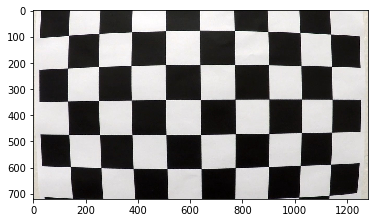

In [55]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./camera_cal/calibration1.jpg')
print(image.shape)
plt.imshow(image)

**Some quick observations**

- Image size is consistent
- Number of intersections slightly differ. There would be the rare occurence where there is 9 by 5 x-y interactions on the chessboard. Normally, most of the images in the calibrartion folder is 9 by 6. The algorithm below is done such that it will ignore such cases

In [56]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_chessboard_corners(fname, nx, ny):
    '''
    Convenience function for testing out chessboard detection
    Returns ret (boolean if result is available), corners coordinates and images
    '''
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
    return ret, corners, img

def get_object_points(nx, ny):
    '''
    Function to get the object points needed to find the points on the chess board
    Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    '''
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    return objp
    
def get_obj_img_points(image_fname_list, nx, ny):
    '''
    Function to obtain the object and image point 
    '''
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Define a default object point
    objp = get_object_points(nx, ny) 
    
    # Step through the list and search for chessboard corners
    for fname in image_fname_list:
        # Find the chessboard corners
        ret, corners, mod_image = get_chessboard_corners(fname, nx, ny)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints
            

In [57]:
# Function testing - all are made to comments as they are only used for testing purposes

# Testing out the functions defined in the above cell
ret, corner, img = get_chessboard_corners('./camera_cal/calibration1.jpg', 9, 5)

True

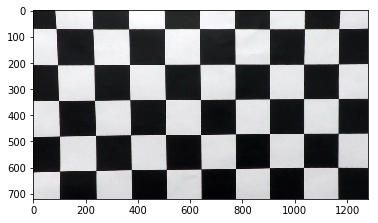

In [58]:
%matplotlib inline

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Get the object points and image points from a set of calibration images
objpoints, imgpoints = get_obj_img_points(images, 9, 6)

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show image
plt.imshow(dst)

# Write the file out into the output folder
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)

## Pipeline (single images)

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:




(720, 1280, 3)


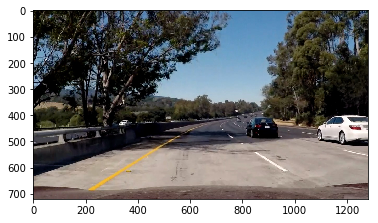

In [281]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Original Image
image = mpimg.imread('./test_images/test5.jpg')
print(image.shape)
plt.imshow(image)

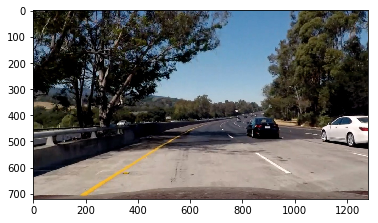

In [381]:
# Undistorted Image
dst = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(dst)

**Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.**

I used a combination of color and gradient thresholds to generate a binary image. In order to test the combinations of binary images at a faster pace, we would create all the required thresholding functions which would include the following:

- rgb threshold functions. They deal with trying to get the image into a single color channel and see if using such a color channel would be able to provide enough information in order to get the lane lines
- hls threshold functions. They deal with trying to get the image into a single color channel but instead of the usual rgb channel, they deal with the hls channel. They will see if using such a color channel would be able to provide enough information in order to get the lane lines
- direction threshold function. They deal with changes in the direction of gradient change of the image
- magniture threshold function. They deal with changes in the magnitude of gradient change of the image
- sobel x threshold. Utiilizes sobel algorithm to get the gradients in the image by the x axis of the image
- sobel y threshold. Utiilizes sobel algorithm to get the gradients in the image by the y axis of the image

In [394]:
# Define color threshold functions - Can choose to utilize which one of the color gradients work best

def rgb_threshold(image, filter=None, mode=None, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Allows one to select color filter and even color thresholding
    '''
    # Apply color filter
    if filter == 'r':
        image = image[:,:,0]
    if filter == 'g':
        image = image[:,:,1]
    if filter == 'b':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if mode == 'binary':
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 1
        return binary_image
    else:
        return image

def hls_threshold(image, filter=None, mode=None, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Image will be converted to hls image. Allow one to select hls filter and hls
    thresholding
    '''
    # Convert to hls image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Apply color filter
    if filter == 'h':
        image = image[:,:,0]
    if filter == 'l':
        image = image[:,:,1]
    if filter == 's':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if mode == 'binary':
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 1
        return binary_image
    else:
        return image

In [500]:
road_image = mpimg.imread("./test_images/test1.jpg")
road_image = cv2.undistort(road_image, mtx, dist, None, mtx)

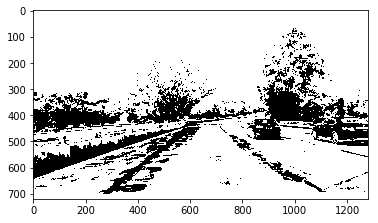

In [501]:
# Testing with just red filter doesn't work
# Test on every single color reveals that none of them work really well because of the shadow. 
# Red may work with some images but it can miserably fail at some of them
rgb_binary = rgb_threshold(road_image, 'r', 'binary', 60, 200)
plt.imshow(rgb_binary, cmap='gray')

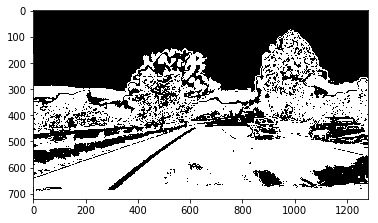

In [515]:
# Testing with just red filter doesn't work
road_image = mpimg.imread("./test_images/test1.jpg")
hls_binary = hls_threshold(road_image, 's', 'binary', 20, 100)
plt.imshow(hls_binary, cmap='gray')

In [516]:
# Define a function called sobel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

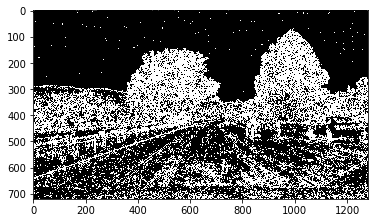

In [517]:
#road_image = mpimg.imread("./test_images/test2.jpg")
gradx = abs_sobel_thresh(road_image, 'x', 4, 200)
plt.imshow(gradx, cmap='gray')

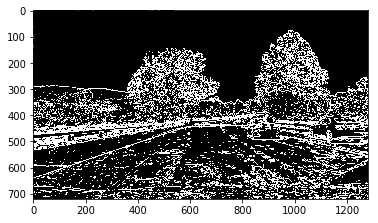

In [518]:
#road_image = mpimg.imread("./test_images/test5.jpg")
grady = abs_sobel_thresh(road_image, 'y', 10, 200)
plt.imshow(grady, cmap='gray')

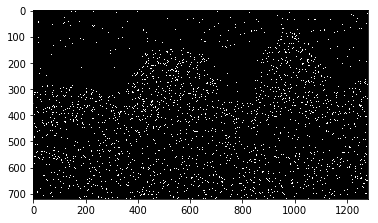

In [519]:
#road_image = mpimg.imread("./test_images/test1.jpg")
dir_binary = dir_threshold(road_image, 3, (0.6, 0.7))
plt.imshow(dir_binary, cmap='gray')

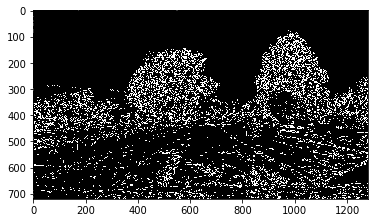

In [520]:
#road_image = mpimg.imread("./test_images/test5.jpg")
mag_binary = mag_thresh(road_image,3, mag_thresh=(15,30))
plt.imshow(mag_binary, cmap='gray')

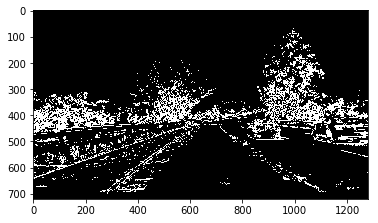

In [521]:
combined = np.zeros_like(rgb_binary)
# combined[((gradx == 1) & (grady == 1)) | 
#        ((mag_binary == 1) & (dir_binary == 0)) | 
#          ((rgb_binary == 0) & (hls_binary == 1))] = 1
# combined[((rgb_binary == 1) | (hls_binary == 1))] = 1
combined[((rgb_binary == 0) & (gradx == 1)) |
         ((rgb_binary == 0) & (grady == 1))] = 1

# combined[((rgb_binary == 1) & ((hls_binary == 0)))] = 1

plt.imshow(combined, cmap='gray')

**Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.**

The code for my perspective transform includes a function called `perpective_warper()`, which appears in the next codeblock.  The `perspective_warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

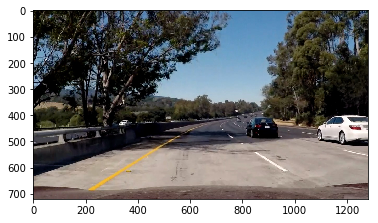

In [548]:
road_image = mpimg.imread("./test_images/test5.jpg")
plt.imshow(road_image)
# Undistort
dst = cv2.undistort(road_image, mtx, dist, None, mtx)
img_size = dst.shape

# # Zoomed-out version
# src = np.float32(
# [[580, 450],
# [40, 720],
# [1240, 720],
# [700, 450]])

# # Zoomed-in version
# src = np.float32(
# [[600, 450],
# [200, 720],
# [1000, 720],
# [680, 450]])

# Zoomed-in version
src = np.float32(
[[490, 500],
[200, 720],
[1000, 720],
[730, 500]])

# dst = np.float32(
#     [[0, 0],
#     [0, 720],
#     [1280, 720],
#     [1280, 0]])

dst = np.float32(
    [[(img_size[1] / 4), 0],
    [(img_size[1] / 4), img_size[0]],
    [(img_size[1] * 3 / 4), img_size[0]],
    [(img_size[1] * 3 / 4), 0]])

# For use in the later portion of this notebook
Minv = cv2.getPerspectiveTransform(dst, src)

def perspective_wrapper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    perspective_transform = cv2.warpPerspective(img, M, img_size)
    
    return perspective_transform

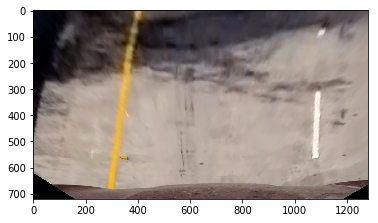

In [549]:
warped_image = perspective_wrapper(road_image, src, dst)
plt.imshow(warped_image)

**Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?**

The lane pixels were fitted to a polynomial with the following functions below.
The comments within the functions describe the purpose of the function and how it would provide

In [550]:
# Function to get the starting point of the function
def get_start_points(binary_warped):
    '''
    Return the starting point for the left and right lanes
    '''
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_initial_indices(binary_warped, leftx_base, rightx_base, nwindows=9, margin = 100, minpix = 50):
    '''
    Get initial left and right lane indices
    Provides the left and right fit in order to get the smoothen out version of the lane lines being detected
    '''
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def plot_lane_fit(binary_warped, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    '''
    Plot results form previous lane line calculations
    No actual calculations is being used for this further downstream
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Color left lane points red
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # Color right lane points blue
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img
    
def get_indices(binary_warped, left_fit, right_fit, margin=100):
    '''
    Get the left and right indices based on previous left and right fits
    '''
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting

    return left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

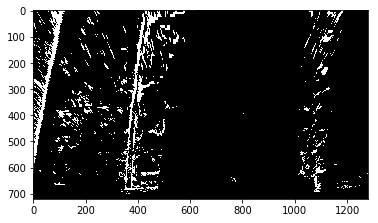

In [551]:
%matplotlib inline

# Get the warped image from above
binary_warped = perspective_wrapper(combined, src, dst)
plt.imshow(binary_warped, cmap='gray')

(720, 0)

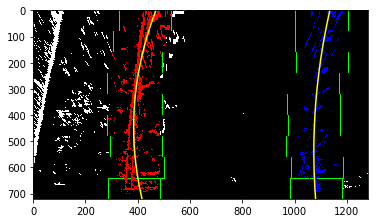

In [552]:
%matplotlib inline

# Run the above functions to get the polyfits for the following road
leftx_base, rightx_base = get_start_points(binary_warped)
out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = get_initial_indices(binary_warped, leftx_base, rightx_base)
out_img = plot_lane_fit(binary_warped, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

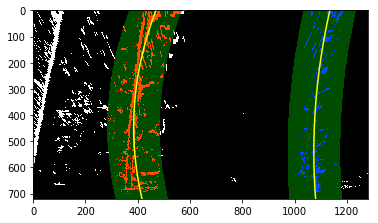

In [553]:
left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = get_indices(binary_warped, left_fit, right_fit)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

margin = 100

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

**Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.**

I did this in the next following block of code

In [554]:
def get_pixel_curvature(max_height, left_fit, right_fit):
    '''
    Generate the curvature based on pixel dimensions
    '''
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad
    
def get_world_curvature(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, ym_per_pix, xm_per_pix):
    y_eval = 719
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [555]:
# Test out functions defined above
get_pixel_curvature(719, left_fit, right_fit)

(1130.0263962449842, 2427.0845528587615)

In [556]:
xm_per_pix = 3.7/500
ym_per_pix = 3/100
get_world_curvature(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, ym_per_pix, xm_per_pix)

(125.36683292728925, 292.97614397356932)

**Observations**

Although, world curvature looks parallel at first glance, when calculations are done, it shows huge differences in the world curvature. This is kind of expected, seeing that this stretch of road is quite straight. Any slight deviations would lead to huge diffences in curvature.

**Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.**

I implemented this step in next set of code blocks. You can view the image for the lane there.

In [557]:
# Function to generate the x points when given a fit object
def generate_fitx_values(fit):
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fitx

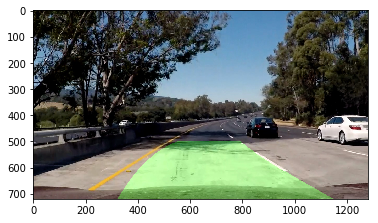

In [558]:
# Initialization to draw the image on
warped = binary_warped
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Get the x-y coordinates on where to draw the lines
ploty = np.linspace(0, 719, num=720)
left_fitx = generate_fitx_values(left_fit)
right_fitx = generate_fitx_values(right_fit)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (road_image.shape[1], road_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(road_image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [602]:
# Define a class to receive the characteristics of each line detection
# This class will only be limited to get information, and not to do calculation
# To store the details of the left line and right line separately
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # Store last n set of fits
        self.fits = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # value of n
        self.n = 10
        self.realWorldYMul = 3/100 # Denomintator is no of pixels covered. For Y is the length of a lane
        self.realWorldXMul = 3.7/500 # Denominator is no of pixels covered. For X is the width of a standard lane
        
    def lineDetected(self, detected):
        '''
        Store boolean on whether line was detected or not
        '''
        self.detected = detected
        
    def storeFits(self, fit):
        '''
        Store last n iterations of fits
        '''
        self.fits.append(fit)
        if len(self.fits) >=  self.n:
            self.fits.pop(0)
        
    def storeXFitted(self, fit):
        '''
        Add new value to the list at the back. If there were more than n fits of the line, remove first instance
        This is not getting the fit but rather the x values produced by the fit
        '''
        no_of_fits = len(self.fits)
        ploty = np.linspace(0, len(self.fits[(no_of_fits - 1)]) - 1, num=len(self.fits[(no_of_fits - 1)]))
        xfitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        self.recent_xfitted.append(xfitx)
        if len(self.recent_xfitted) >= self.n:
            self.recent_xfitted.pop(0)
        
    def getBestX(self):
        '''
        Get the best set of x values of the lines
        '''
        self.bestx = np.mean((self.recent_xfitted), 0)
        
    def getBestFit(self):
        '''
        Get the best fit coordiantes by using the best x coordinates
        '''
        ploty = np.linspace(0, len(self.bestx) - 1, num=len(self.bestx))
        fit = np.polyfit(ploty, self.bestx, 2)
        self.best_fit = fit
        
    def getRadiusOfCurvature(self):
        '''
        Get the real world radius of curvature
        '''
        y_points = np.linspace(0, len(self.bestx) - 1, num=len(self.bestx))
        x_points = self.bestx
        y_points = y_points * self.realWorldYMul
        x_points = x_points * self.realWorldXMul
        fit_cr = np.polyfit(y_points, x_points, 2)
        y_eval = max(y_points)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*self.realWorldYMul + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
    def getBaseLinePos(self, xfitx_secondary):
        '''
        Parameter to accept the second line
        '''
        related_coordinate = len(self.bestx) - 1
        base_point_second_line = xfitx_secondary[related_coordinate]
        base_point = self.bestx[related_coordinate]
        distance_in_pixels = abs(base_point - base_point_second_line)
        self.line_base_pos = distance_in_pixels * self.realWorldXMul
        
    def getDiffs(self):
        current_no = len(self.fits)
        if current_no >= 2:
            self.diffs = self.fits[current_no - 1] - self.fits[current_no - 2]
            
    def setAllX(self, x_pixels):
        self.allx = x_pixels
        
    def setAllY(self, y_pixels):
        self.ally = y_pixels
        
    

## Pipeline (video)

The video produced from the analysis is generated from the code below.

In [603]:
# Code to generate video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [604]:
# Declaring additional functions that were not declared or declared improperly above
def thresholding(image):
    '''
    Comment/Uncomment sections that are not really required
    '''
    rgb_binary = rgb_threshold(image, 'r', 'binary', 60, 200)
    hls_binary = hls_threshold(image, 's', 'binary', 50, 220)
    gradx = abs_sobel_thresh(image, 'x', 5, 200)
    grady = abs_sobel_thresh(image, 'y', 10, 200)
    dir_binary = dir_threshold(image, 3, (0.6, 0.7))
    mag_binary = mag_thresh(image,3, mag_thresh=(15,30))
    
    combined = np.zeros_like(rgb_binary)
    combined[((rgb_binary == 0) & (gradx == 1)) |
             ((rgb_binary == 0) & (grady == 1))] = 1
    
    return combined

In [605]:
# Declaring additional functions that were not declared or declared improperly above
def remapLaneLine(original_image, binary_warped, left_fit, right_fit):
    
    
    # Initialization to draw the image on
    warped = binary_warped
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Get the x-y coordinates on where to draw the lines
    ploty = np.linspace(0, 719, num=720)
    left_fitx = generate_fitx_values(left_fit)
    right_fitx = generate_fitx_values(right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

In [606]:
# Declare left line and right line
left_line = Line()
right_line = Line()

In [607]:
# Some of the variables have to be obtained from the environment
def process_image(image):
    '''
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    The following function will replicate every step taken along the way to reach the end of overlaying the
    lane lines on the video
    '''
    # Distortion Correction
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Color/Gradient Thresholding
    image_thresholded = thresholding(image_undistorted)
    
    # Perspective Transform
    image_warped = perspective_wrapper(image_thresholded, src, dst)
    
    # Reading the data from the class that records the lines
    # If either line was not detected, need to recalibrate the initial points
    if (not left_line.detected) | (not right_line.detected):
        leftx_base, rightx_base = get_start_points(image_warped)
        print(leftx_base)
        print(rightx_base)
        out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = get_initial_indices(image_warped, leftx_base, rightx_base, nwindows=9, margin = 100, minpix = 50)
    else:
        try:
            left_fit = left_line.best_fit
            right_fit = right_line.best_fit
            left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = get_indices(image_warped, left_fit, right_fit, margin=100)
        except:
            leftx_base, rightx_base = get_start_points(image_warped)
            out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = get_initial_indices(image_warped, leftx_base, rightx_base, nwindows=9, margin = 100, minpix = 50)
    
    # Record all left lane info
    left_line.lineDetected(True)
    left_line.storeFits(left_fit)
    left_line.storeXFitted(left_fit)
    left_line.getBestX()
    left_line.getBestFit()
    left_line.getRadiusOfCurvature()
    left_line.getDiffs()
    
    # Record all right lane info
    right_line.lineDetected(True)
    right_line.storeFits(right_fit)
    right_line.storeXFitted(right_fit)
    right_line.getBestX()
    right_line.getBestFit()
    right_line.getRadiusOfCurvature()
    right_line.getDiffs()
    
    # Record the base line position
    left_line.getBaseLinePos(right_line.bestx)
    right_line.getBaseLinePos(left_line.bestx)
    
    # Create the final color image
    finalImage = remapLaneLine(image_undistorted, image_warped, left_line.best_fit, right_line.best_fit)
    
    return finalImage

In [608]:
video_output = 'lane_lines_output.mp4'
clip1 = VideoFileClip("project_video.mp4") # Input
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

408
1103
[ -1.93004730e-05  -6.70525564e-02   4.47470326e+02]
[  4.52214043e-05   1.25667163e-02   1.09969070e+03]
[MoviePy] >>>> Building video lane_lines_output.mp4
[MoviePy] Writing video lane_lines_output.mp4












  0%|          | 0/1261 [00:00<?, ?it/s]









  0%|          | 1/1261 [00:00<05:42,  3.68it/s]

[ -1.93004730e-05  -6.70525564e-02   4.47470326e+02]
[  9.63798390e-05  -1.99172233e-02   1.10459983e+03]












  0%|          | 2/1261 [00:00<05:35,  3.75it/s]

[ -2.98264002e-05  -5.98816931e-02   4.47880553e+02]
[ -8.21324359e-06   5.69181510e-02   1.08839904e+03]












  0%|          | 3/1261 [00:00<05:16,  3.97it/s]

[ -2.67625501e-05  -6.38933690e-02   4.49684293e+02]
[  1.23199685e-05   3.37065086e-02   1.09246761e+03]












  0%|          | 4/1261 [00:00<05:04,  4.13it/s]

[ -2.60313386e-05  -6.51643649e-02   4.50984331e+02]
[ -1.06691132e-06   4.11996104e-02   1.09119138e+03]












  0%|          | 5/1261 [00:01<05:01,  4.16it/s]

[ -4.39347464e-05  -5.49286305e-02   4.50587353e+02]
[  1.34327437e-05   2.51568356e-02   1.09510415e+03]












  0%|          | 6/1261 [00:01<04:51,  4.30it/s]

[ -4.68940707e-05  -5.02089323e-02   4.50589490e+02]
[ -6.81197266e-05   9.81339742e-02   1.08035334e+03]












  1%|          | 7/1261 [00:01<04:42,  4.45it/s]

[ -4.86056726e-05  -4.52938185e-02   4.49247510e+02]
[ -7.66913260e-05   1.04771897e-01   1.08077866e+03]
[ -4.73343341e-05  -4.35163268e-02   4.50102156e+02]











  1%|          | 8/1261 [00:01<04:33,  4.57it/s]









  1%|          | 9/1261 [00:02<04:29,  4.65it/s]


[ -4.26088485e-05   9.82495200e-02   1.07709234e+03]
[ -4.30578786e-05  -4.34070146e-02   4.47922514e+02]
[ -1.23716764e-04   1.21000046e-01   1.07757853e+03]












  1%|          | 10/1261 [00:02<04:24,  4.72it/s]

[ -5.36656081e-05  -3.37099566e-02   4.45231452e+02]
[  3.78968931e-06   6.62711222e-02   1.08094204e+03]












  1%|          | 11/1261 [00:02<04:22,  4.76it/s]

[ -5.70789078e-05  -2.92832265e-02   4.44284892e+02]
[  1.71507173e-05   5.48614299e-02   1.08033553e+03]
[ -5.86793858e-05  -2.31509314e-02   4.38463607e+02]
[ -4.22305047e-05   7.24723390e-02   1.08576417e+03]












  1%|          | 12/1261 [00:02<04:16,  4.88it/s]









  1%|          | 13/1261 [00:02<04:12,  4.94it/s]

[ -4.11436633e-05  -3.41653190e-02   4.39616143e+02]
[ -5.29132442e-06   5.22440003e-02   1.08669611e+03]
[ -3.94689876e-05  -3.37705632e-02   4.39198723e+02]











  1%|          | 14/1261 [00:03<04:10,  4.99it/s]









  1%|          | 15/1261 [00:03<04:05,  5.08it/s]


[  2.68115832e-05   2.90185499e-02   1.09014916e+03]
[ -3.80121047e-05  -3.42985815e-02   4.40522801e+02]
[ -7.20130034e-05   1.11269373e-01   1.06900905e+03]
[ -3.64436043e-05  -3.56325917e-02   4.41082076e+02]
[ -3.13943801e-05   8.77303738e-02   1.06632896e+03]












  1%|▏         | 16/1261 [00:03<04:05,  5.06it/s]









  1%|▏         | 17/1261 [00:03<04:00,  5.18it/s]

[ -6.49930383e-05  -1.86701351e-02   4.38222238e+02]
[ -2.38566707e-05   8.11618283e-02   1.06635448e+03]
[ -6.16390461e-05  -1.86289909e-02   4.37473305e+02]
[ -4.19482217e-05   1.01147869e-01   1.05910392e+03]












  1%|▏         | 18/1261 [00:03<04:02,  5.12it/s]









  2%|▏         | 19/1261 [00:04<04:12,  4.93it/s]

[ -6.23024962e-05  -1.52152021e-02   4.34137111e+02]
[ -6.04224985e-05   1.18203832e-01   1.05714757e+03]
[ -6.62223887e-05  -8.67281497e-03   4.30285026e+02]
[ -4.22556343e-05   1.01882256e-01   1.06038991e+03]












  2%|▏         | 20/1261 [00:04<04:06,  5.04it/s]









  2%|▏         | 21/1261 [00:04<04:03,  5.09it/s]

[ -5.03461680e-05  -1.47327254e-02   4.27582345e+02]
[  8.20882962e-05   4.24639450e-02   1.06715342e+03]












  2%|▏         | 22/1261 [00:04<04:09,  4.96it/s]

[ -4.30048131e-05  -1.61804929e-02   4.23881117e+02]
[  5.03159586e-05   4.45059695e-02   1.07229455e+03]












  2%|▏         | 23/1261 [00:04<04:13,  4.88it/s]

[ -4.14132241e-05  -1.64503993e-02   4.20336621e+02]
[  3.35085719e-05   3.96004590e-02   1.07662066e+03]












  2%|▏         | 24/1261 [00:05<04:12,  4.89it/s]

[ -3.24393345e-05  -2.60063784e-02   4.21860936e+02]
[  3.48235746e-05   3.44899360e-02   1.07618127e+03]












  2%|▏         | 25/1261 [00:05<04:17,  4.79it/s]

[ -3.29697134e-05  -2.99047387e-02   4.22910537e+02]
[  3.65417191e-05   2.65918960e-02   1.07765337e+03]












  2%|▏         | 26/1261 [00:05<04:17,  4.79it/s]

[ -3.57114671e-05  -3.00125899e-02   4.20219573e+02]
[  2.64736744e-05   1.87499173e-02   1.08540495e+03]












  2%|▏         | 27/1261 [00:05<04:16,  4.80it/s]

[ -3.51538576e-05  -3.50559143e-02   4.20738840e+02]
[  7.70928548e-05  -2.47438892e-02   1.09619851e+03]
[ -3.42443011e-05  -3.78948424e-02   4.18761943e+02]
[ -4.07549126e-05   5.91015589e-02   1.08679737e+03]












  2%|▏         | 28/1261 [00:05<04:12,  4.88it/s]









  2%|▏         | 29/1261 [00:06<04:15,  4.82it/s]

[ -2.15384868e-05  -5.12424218e-02   4.22293820e+02]
[ -2.93089136e-05   5.43149707e-02   1.08629816e+03]












  2%|▏         | 30/1261 [00:06<04:19,  4.74it/s]

[ -1.46778339e-05  -6.20175188e-02   4.26529693e+02]
[ -2.47866526e-05   4.98418669e-02   1.08591663e+03]












  2%|▏         | 31/1261 [00:06<04:17,  4.78it/s]

[ -5.59796694e-05  -4.31285912e-02   4.28380940e+02]
[  8.25253076e-05  -3.35548370e-02   1.09811311e+03]
[ -4.21975881e-05  -5.39729832e-02   4.32791671e+02]
[ -6.92668139e-05   1.07138071e-01   1.06786079e+03]












  3%|▎         | 32/1261 [00:06<04:14,  4.83it/s]









  3%|▎         | 33/1261 [00:06<04:16,  4.79it/s]

[ -3.95525647e-05  -5.41960777e-02   4.31676609e+02]
[ -8.59322306e-05   1.12619022e-01   1.07176988e+03]












  3%|▎         | 34/1261 [00:07<04:13,  4.83it/s]

[ -4.46550336e-05  -5.15260289e-02   4.33433236e+02]
[ -6.69740840e-05   1.04797572e-01   1.06933002e+03]












  3%|▎         | 35/1261 [00:07<04:12,  4.86it/s]

[ -6.18306749e-05  -4.20740352e-02   4.33969620e+02]
[ -3.38774625e-05   8.92757897e-02   1.06928372e+03]












  3%|▎         | 36/1261 [00:07<04:12,  4.84it/s]

[ -4.38017747e-05  -5.22459086e-02   4.37297762e+02]
[ -3.42573182e-05   9.11640606e-02   1.06616261e+03]
[ -4.19258131e-05  -5.25232041e-02   4.38220253e+02]











  3%|▎         | 37/1261 [00:07<04:10,  4.89it/s]









  3%|▎         | 38/1261 [00:07<04:18,  4.72it/s]


[ -7.74287656e-06   7.34532871e-02   1.06683880e+03]
[ -4.13429995e-05  -5.31856284e-02   4.40083319e+02]
[ -5.34349701e-06   6.74699846e-02   1.06695312e+03]
[ -4.03883078e-05  -5.44746136e-02   4.42048055e+02]












  3%|▎         | 39/1261 [00:08<04:15,  4.78it/s]









  3%|▎         | 40/1261 [00:08<04:09,  4.89it/s]

[ -1.05072532e-04   1.36395367e-01   1.05232678e+03]
[ -4.26166067e-05  -4.99098536e-02   4.40471330e+02]
[ -2.72654202e-05   7.72871184e-02   1.06410839e+03]












  3%|▎         | 41/1261 [00:08<04:10,  4.87it/s]

[ -3.56273359e-05  -5.30759649e-02   4.41112138e+02]
[ -3.17758136e-06   5.78915387e-02   1.06819329e+03]












  3%|▎         | 42/1261 [00:08<04:25,  4.59it/s]

[ -2.85848096e-05  -5.73859616e-02   4.41962501e+02]
[  1.69753625e-06   4.97728741e-02   1.07202361e+03]












  3%|▎         | 43/1261 [00:09<04:18,  4.71it/s]

[ -4.53523462e-05  -4.77511115e-02   4.41201704e+02]
[ -5.08644334e-06   5.00367347e-02   1.07550104e+03]












  3%|▎         | 44/1261 [00:09<04:15,  4.76it/s]

[ -4.96833736e-05  -4.21212059e-02   4.39047401e+02]
[ -9.02122325e-05   1.24381355e-01   1.06396999e+03]
[ -5.18440304e-05  -3.77419422e-02   4.37366745e+02]
[ -8.32652466e-05   1.16522544e-01   1.06883057e+03]











  4%|▎         | 45/1261 [00:09<04:11,  4.84it/s]









  4%|▎         | 46/1261 [00:09<04:13,  4.79it/s]


[ -5.40808778e-05  -3.50906421e-02   4.36411947e+02]
[ -1.11969159e-05   8.31787171e-02   1.06902852e+03]
[ -6.09180878e-05  -2.69479929e-02   4.33568427e+02]
[  9.35091013e-06   7.08061285e-02   1.07120218e+03]












  4%|▎         | 47/1261 [00:09<04:09,  4.87it/s]









  4%|▍         | 48/1261 [00:10<04:19,  4.67it/s]

[ -6.47668333e-05  -2.34718291e-02   4.33185162e+02]
[  6.26172174e-06   6.91379057e-02   1.06967424e+03]
[ -6.11607173e-05  -2.26515445e-02   4.30508454e+02]











  4%|▍         | 49/1261 [00:10<04:11,  4.81it/s]









  4%|▍         | 50/1261 [00:10<04:04,  4.95it/s]


[ -3.56294509e-06   6.90149471e-02   1.07333233e+03]
[ -6.32018326e-05  -1.92571872e-02   4.30061016e+02]
[ -1.85368024e-05   7.40887644e-02   1.07221409e+03]












  4%|▍         | 51/1261 [00:10<04:06,  4.91it/s]

[ -6.09245636e-05  -1.73307042e-02   4.28479003e+02]
[ -9.18212603e-05   1.12069620e-01   1.06743388e+03]












  4%|▍         | 52/1261 [00:10<04:08,  4.87it/s]









  4%|▍         | 53/1261 [00:11<03:55,  5.12it/s]

[ -4.96570677e-05  -2.56227741e-02   4.30377648e+02]
[  5.50822739e-05   1.50553249e-02   1.08011455e+03]
[ -4.75612431e-05  -2.34321945e-02   4.29234032e+02]
[ -1.32570468e-05   6.54819730e-02   1.06891989e+03]












  4%|▍         | 54/1261 [00:11<03:53,  5.16it/s]

[ -4.04501112e-05  -2.57731990e-02   4.27993617e+02]
[ -1.75409938e-05   6.47524235e-02   1.06934581e+03]
[ -6.04938449e-05  -1.29604195e-02   4.25362497e+02]











  4%|▍         | 55/1261 [00:11<03:54,  5.14it/s]









  4%|▍         | 56/1261 [00:11<03:51,  5.21it/s]


[ -4.12693277e-06   5.28320761e-02   1.07260098e+03]
[ -6.67848767e-05  -6.30404913e-03   4.22561970e+02]
[  4.50904583e-06   4.35211341e-02   1.07600939e+03]












  5%|▍         | 57/1261 [00:11<04:08,  4.84it/s]

[ -6.05001860e-05  -8.23411024e-03   4.21489119e+02]
[ -9.59375476e-05   1.32414827e-01   1.06058196e+03]












  5%|▍         | 58/1261 [00:12<04:23,  4.57it/s]

[ -5.74932654e-05  -8.59147900e-03   4.19632849e+02]
[ -7.82602248e-05   1.21650368e-01   1.05954548e+03]












  5%|▍         | 59/1261 [00:12<04:16,  4.69it/s]









  5%|▍         | 60/1261 [00:12<04:03,  4.93it/s]

[ -5.46142458e-05  -1.25771068e-02   4.21819906e+02]
[ -2.66038664e-05   1.03913737e-01   1.05353937e+03]
[ -4.36767824e-05  -2.07129583e-02   4.23025593e+02]
[ -1.61840020e-05   9.73366640e-02   1.04796318e+03]
[ -3.92456412e-05  -2.50083963e-02   4.23145502e+02]
[  3.17041174e-05   7.62435065e-02   1.04768647e+03]












  5%|▍         | 61/1261 [00:12<03:57,  5.05it/s]









  5%|▍         | 62/1261 [00:12<03:49,  5.23it/s]

[ -3.10815069e-05  -3.33526100e-02   4.24608995e+02]
[  1.43971607e-05   7.99728249e-02   1.04493668e+03]
[ -2.38939897e-05  -3.89109194e-02   4.23570267e+02]
[  3.13701177e-05   5.80589653e-02   1.05080025e+03]












  5%|▍         | 63/1261 [00:13<03:52,  5.15it/s]









  5%|▌         | 64/1261 [00:13<03:56,  5.06it/s]

[ -1.10141749e-05  -5.25810618e-02   4.26236121e+02]
[  3.00718362e-04  -1.44141695e-01   1.08580421e+03]
[ -4.66674230e-06  -5.76479963e-02   4.25615073e+02]
[ -6.70686911e-06   7.68499751e-02   1.04779969e+03]












  5%|▌         | 65/1261 [00:13<03:58,  5.02it/s]









  5%|▌         | 66/1261 [00:13<04:03,  4.90it/s]

[  8.77751575e-06  -7.20382366e-02   4.28807911e+02]
[ -1.32530342e-05   7.53524466e-02   1.04822826e+03]
[  2.30643252e-05  -8.35534351e-02   4.29466210e+02]
[ -6.74052234e-06   6.25201985e-02   1.05206540e+03]












  5%|▌         | 67/1261 [00:13<03:55,  5.08it/s]









  5%|▌         | 68/1261 [00:14<03:46,  5.27it/s]

[ -4.37469233e-06  -7.16191030e-02   4.27575428e+02]
[  1.27044919e-05   4.17336278e-02   1.05746921e+03]
[ -1.06643867e-05  -7.28830978e-02   4.29900355e+02]
[ -8.91207277e-05   1.36357862e-01   1.03674965e+03]












  5%|▌         | 69/1261 [00:14<03:44,  5.30it/s]









  6%|▌         | 70/1261 [00:14<03:47,  5.24it/s]

[ -1.90324234e-05  -6.76467794e-02   4.27567596e+02]
[ -8.91947179e-05   1.34154881e-01   1.03943348e+03]












  6%|▌         | 71/1261 [00:14<04:02,  4.91it/s]

[ -3.38256723e-05  -5.87544989e-02   4.27217867e+02]
[ -2.07063140e-05   1.03981787e-01   1.03852559e+03]












  6%|▌         | 72/1261 [00:14<04:18,  4.59it/s]

[ -4.41068943e-05  -5.05136896e-02   4.24753423e+02]
[  2.58915255e-05   7.43455379e-02   1.04160697e+03]
[ -5.59864132e-05  -3.92061027e-02   4.21759277e+02]
[ -1.55465919e-06   7.59140182e-02   1.04268768e+03]












  6%|▌         | 73/1261 [00:15<04:13,  4.69it/s]









  6%|▌         | 74/1261 [00:15<04:17,  4.60it/s]

[ -6.70163110e-05  -2.87126561e-02   4.19262613e+02]
[  4.49077504e-05   4.77818427e-02   1.04475103e+03]












  6%|▌         | 75/1261 [00:15<04:13,  4.69it/s]









  6%|▌         | 76/1261 [00:15<04:00,  4.93it/s]

[ -7.25735173e-05  -2.10121412e-02   4.15378091e+02]
[  3.10727109e-05   4.13358519e-02   1.04955954e+03]
[ -6.98015735e-05  -2.01260250e-02   4.14744932e+02]
[  4.67427325e-05   2.17970305e-02   1.05310993e+03]












  6%|▌         | 77/1261 [00:15<04:02,  4.89it/s]

[ -6.55700409e-05  -1.56018483e-02   4.08741438e+02]
[  9.85931883e-05  -3.02571629e-02   1.06915293e+03]












  6%|▌         | 78/1261 [00:16<04:04,  4.84it/s]

[ -4.88303381e-05  -2.20718860e-02   4.06479084e+02]
[ -8.87403589e-06   4.02407332e-02   1.06009995e+03]
[ -2.39048574e-05  -3.53006827e-02   4.04494013e+02]
[  1.77755690e-05   1.40998328e-02   1.06717732e+03]












  6%|▋         | 79/1261 [00:16<03:56,  4.99it/s]









  6%|▋         | 80/1261 [00:16<03:55,  5.01it/s]

[ -3.62694165e-05  -2.93475603e-02   4.02158236e+02]
[  1.00041911e-06   2.28708694e-02   1.06626357e+03]
[ -3.26873609e-05  -3.31600408e-02   4.02045799e+02]
[  1.52009745e-05   5.42012756e-03   1.07020758e+03]












  6%|▋         | 81/1261 [00:16<03:50,  5.11it/s]









  7%|▋         | 82/1261 [00:16<03:44,  5.25it/s]

[ -1.80619982e-05  -4.45566010e-02   4.01260174e+02]
[ -1.00957403e-04   1.09068960e-01   1.05148887e+03]
[ -4.78371497e-06  -5.60492775e-02   4.01366631e+02]
[ -7.53929123e-05   9.44453676e-02   1.05286277e+03]












  7%|▋         | 83/1261 [00:17<03:44,  5.24it/s]









  7%|▋         | 84/1261 [00:17<03:41,  5.31it/s]

[  7.03526745e-06  -6.30050370e-02   3.97867009e+02]
[  1.84898113e-05   5.06005038e-02   1.06107893e+03]
[  1.20839284e-05  -7.10905159e-02   3.99408879e+02]
[  1.28247946e-05   4.59558978e-02   1.06160904e+03]












  7%|▋         | 85/1261 [00:17<03:40,  5.32it/s]









  7%|▋         | 86/1261 [00:17<03:44,  5.23it/s]









  7%|▋         | 87/1261 [00:17<03:40,  5.33it/s]

[  4.83083779e-06  -7.12550653e-02   4.00699470e+02]
[  4.37842966e-06   4.51115278e-02   1.06200458e+03]
[ -3.54860664e-06  -7.42512867e-02   4.06742633e+02]
[  2.15096629e-05   3.85535728e-02   1.05717018e+03]












  7%|▋         | 88/1261 [00:17<03:40,  5.31it/s]

[ -1.21195041e-05  -7.53711892e-02   4.11185962e+02]
[ -1.12538727e-05   5.56098542e-02   1.05142363e+03]
[ -1.90682425e-05  -7.56859903e-02   4.14659244e+02]
[  1.00986871e-04  -2.25572377e-02   1.06273746e+03]












  7%|▋         | 89/1261 [00:18<03:39,  5.34it/s]









  7%|▋         | 90/1261 [00:18<03:50,  5.08it/s]

[ -1.58806064e-05  -8.17421770e-02   4.20423322e+02]
[  2.89258238e-06   5.12529639e-02   1.04585577e+03]












  7%|▋         | 91/1261 [00:18<03:48,  5.12it/s]

[ -3.37272374e-06  -8.86259712e-02   4.20370759e+02]
[  3.45673299e-05   2.87796962e-02   1.05120734e+03]
[  4.01636870e-06  -9.37078243e-02   4.21459248e+02]
[ -5.21868032e-06   4.32973937e-02   1.05361048e+03]












  7%|▋         | 92/1261 [00:18<03:53,  5.02it/s]









  7%|▋         | 93/1261 [00:19<03:58,  4.90it/s]

[ -1.18542337e-05  -8.98470081e-02   4.24573560e+02]
[  5.19634717e-06   3.03507454e-02   1.05591943e+03]












  7%|▋         | 94/1261 [00:19<03:59,  4.87it/s]

[ -1.88854802e-05  -8.69703449e-02   4.26705300e+02]
[ -9.34568860e-05   1.22492633e-01   1.03663665e+03]












  8%|▊         | 95/1261 [00:19<04:04,  4.78it/s]

[ -2.80235431e-05  -8.01217545e-02   4.25031726e+02]
[ -8.97052323e-05   1.15925380e-01   1.03905418e+03]












  8%|▊         | 96/1261 [00:19<04:00,  4.85it/s]

[ -4.04443222e-05  -7.16729808e-02   4.24471049e+02]
[  7.94602604e-05   4.66730113e-02   1.04156844e+03]












  8%|▊         | 97/1261 [00:19<04:10,  4.65it/s]

[ -4.25880849e-05  -6.81725953e-02   4.24762129e+02]
[  6.64727414e-05   3.97154026e-02   1.04293735e+03]
[ -4.15436896e-05  -6.52154538e-02   4.22856287e+02]
[  5.07210078e-05   3.07696769e-02   1.04830519e+03]












  8%|▊         | 98/1261 [00:20<04:04,  4.76it/s]









  8%|▊         | 99/1261 [00:20<04:05,  4.73it/s]

[ -5.00200063e-05  -5.95177027e-02   4.23929179e+02]
[  4.80277750e-05   2.29076647e-02   1.04857778e+03]
[ -5.19677628e-05  -5.60531609e-02   4.22650630e+02]
[  4.12468263e-05   1.42021477e-02   1.05367697e+03]












  8%|▊         | 100/1261 [00:20<03:55,  4.94it/s]









  8%|▊         | 101/1261 [00:20<03:57,  4.89it/s]

[ -6.01943145e-05  -4.79725414e-02   4.23043138e+02]
[  4.20109594e-05   6.02151998e-03   1.05706550e+03]
[ -5.30503693e-05  -5.16258761e-02   4.24580207e+02]
[  1.26931800e-04  -6.69837140e-02   1.07091962e+03]












  8%|▊         | 102/1261 [00:20<03:53,  4.96it/s]









  8%|▊         | 103/1261 [00:21<03:55,  4.91it/s]

[ -3.71424310e-05  -5.99525142e-02   4.25530724e+02]
[ -1.21797017e-05   3.60482047e-02   1.05500819e+03]
[ -1.90217647e-05  -6.96899701e-02   4.27269829e+02]












  8%|▊         | 104/1261 [00:21<03:56,  4.89it/s]

[ -1.50248972e-05   3.47196228e-02   1.05782073e+03]












  8%|▊         | 105/1261 [00:21<03:57,  4.86it/s]

[ -1.86737302e-06  -7.85845050e-02   4.26115370e+02]
[ -2.91467667e-06   2.06684791e-02   1.06616316e+03]












  8%|▊         | 106/1261 [00:21<03:58,  4.83it/s]

[ -2.83126714e-05  -6.37548122e-02   4.24297818e+02]
[ -8.16510260e-06   1.88756998e-02   1.07172314e+03]
[ -2.88995046e-05  -6.18808847e-02   4.23389468e+02]











  8%|▊         | 107/1261 [00:21<03:59,  4.83it/s]









  9%|▊         | 108/1261 [00:22<04:01,  4.78it/s]


[ -1.24522154e-05   1.37639068e-02   1.07999259e+03]
[ -3.20643527e-05  -6.17821199e-02   4.27070150e+02]
[ -1.01412669e-04   1.06459164e-01   1.05995334e+03]
[ -3.05962005e-05  -6.45418713e-02   4.28266799e+02]











  9%|▊         | 109/1261 [00:22<03:58,  4.82it/s]


[  4.84123788e-05   4.46543851e-02   1.06248311e+03]












  9%|▊         | 110/1261 [00:22<04:02,  4.74it/s]

[ -3.43875370e-05  -6.30157393e-02   4.28815091e+02]
[ -7.64589110e-05   8.95189274e-02   1.06129667e+03]
[ -3.24232427e-05  -6.47832469e-02   4.30227426e+02]
[  7.87381871e-06   5.06911399e-02   1.06348842e+03]












  9%|▉         | 111/1261 [00:22<03:59,  4.80it/s]









  9%|▉         | 112/1261 [00:22<03:57,  4.84it/s]

[ -3.30598881e-05  -6.20236248e-02   4.27548410e+02]
[  1.14706536e-06   4.71562145e-02   1.06978556e+03]
[ -3.38192987e-05  -6.28861626e-02   4.30688165e+02]
[  4.49090456e-07   4.72040491e-02   1.06719208e+03]












  9%|▉         | 113/1261 [00:23<03:50,  4.98it/s]









  9%|▉         | 114/1261 [00:23<03:54,  4.90it/s]









  9%|▉         | 115/1261 [00:23<03:44,  5.11it/s]

[ -3.50934037e-05  -6.15267702e-02   4.32008517e+02]
[ -7.72675130e-06   4.90391632e-02   1.06753612e+03]
[ -3.59011037e-05  -6.32608566e-02   4.35328738e+02]
[  9.04024750e-05  -2.42233456e-02   1.07860060e+03]












  9%|▉         | 116/1261 [00:23<03:42,  5.15it/s]

[ -2.77710337e-05  -6.81027810e-02   4.36895369e+02]
[  3.15125655e-06   3.72645173e-02   1.06687658e+03]
[ -9.20161429e-06  -7.72963589e-02   4.37449969e+02]
[  1.80609289e-05   1.90336577e-02   1.07274843e+03]












  9%|▉         | 117/1261 [00:23<03:38,  5.24it/s]









  9%|▉         | 118/1261 [00:24<03:34,  5.33it/s]

[ -3.45308193e-05  -6.46533342e-02   4.37456047e+02]
[  2.53157588e-05   7.17751456e-03   1.07646592e+03]












  9%|▉         | 119/1261 [00:24<03:39,  5.19it/s]









 10%|▉         | 120/1261 [00:24<03:35,  5.31it/s]

[ -3.52083444e-05  -6.41102159e-02   4.38308374e+02]
[  1.81711449e-05   1.15308284e-02   1.07692303e+03]
[ -3.27431464e-05  -6.77019397e-02   4.41792464e+02]
[ -7.45070589e-05   9.75915701e-02   1.05952101e+03]












 10%|▉         | 121/1261 [00:24<03:39,  5.18it/s]









 10%|▉         | 122/1261 [00:24<03:41,  5.13it/s]

[ -4.15544340e-05  -5.98849834e-02   4.40925261e+02]
[ -7.25956321e-05   9.83183306e-02   1.06220264e+03]
[ -5.12111443e-05  -5.25161252e-02   4.41360559e+02]
[ -5.48298642e-05   9.04368305e-02   1.06202807e+03]
[ -5.48264134e-05  -4.98284805e-02   4.42734560e+02]
[ -9.81540770e-06   7.48305862e-02   1.05932884e+03]












 10%|▉         | 123/1261 [00:25<03:42,  5.11it/s]









 10%|▉         | 124/1261 [00:25<03:40,  5.15it/s]

[ -5.59369546e-05  -4.73969531e-02   4.42800619e+02]
[  2.21709306e-06   6.28047833e-02   1.06124312e+03]
[ -5.38828054e-05  -4.89097263e-02   4.44334530e+02]
[  5.53647193e-06   5.70761153e-02   1.06229075e+03]












 10%|▉         | 125/1261 [00:25<03:37,  5.23it/s]









 10%|▉         | 126/1261 [00:25<03:36,  5.25it/s]

[ -4.44701579e-05  -5.15630369e-02   4.42174489e+02]
[ -4.46994837e-05   7.41493697e-02   1.06603975e+03]
[ -4.06549022e-05  -5.41671418e-02   4.43921483e+02]
[  2.83655898e-04  -1.42893232e-01   1.10072685e+03]












 10%|█         | 127/1261 [00:25<03:34,  5.28it/s]









 10%|█         | 128/1261 [00:26<03:38,  5.17it/s]

[ -3.49479492e-05  -5.38278388e-02   4.42877472e+02]
[ -1.51387477e-05   5.65676410e-02   1.07069966e+03]
[ -3.07917702e-05  -5.51312169e-02   4.45468844e+02]
[ -3.20756801e-05   7.20024567e-02   1.06476811e+03]












 10%|█         | 129/1261 [00:26<03:35,  5.25it/s]









 10%|█         | 130/1261 [00:26<03:40,  5.14it/s]

[ -5.58267383e-05  -4.18587192e-02   4.43680390e+02]
[ -2.43742966e-05   6.40719091e-02   1.06708960e+03]
[ -4.88171607e-05  -4.64471876e-02   4.44917278e+02]
[ -2.24441929e-05   6.38251279e-02   1.06766119e+03]












 10%|█         | 131/1261 [00:26<03:41,  5.11it/s]









 10%|█         | 132/1261 [00:26<03:42,  5.07it/s]

[ -5.65239524e-05  -4.00000880e-02   4.45603854e+02]
[ -8.37384027e-05   1.21730844e-01   1.05514826e+03]
[ -5.60739060e-05  -3.86295353e-02   4.45208184e+02]
[ -8.13349812e-05   1.20762209e-01   1.05781580e+03]












 11%|█         | 133/1261 [00:26<03:39,  5.14it/s]









 11%|█         | 134/1261 [00:27<03:40,  5.11it/s]

[ -5.06799999e-05  -4.08785491e-02   4.46274431e+02]
[ -4.20451534e-06   9.16752484e-02   1.05789468e+03]
[ -4.69034399e-05  -4.05216373e-02   4.46135904e+02]
[ -3.45044015e-05   9.89623755e-02   1.05951829e+03]












 11%|█         | 135/1261 [00:27<03:41,  5.08it/s]









 11%|█         | 136/1261 [00:27<03:48,  4.93it/s]

[ -4.82742666e-05  -3.64918840e-02   4.44725995e+02]
[  5.26202366e-07   7.85016984e-02   1.06419855e+03]
[ -5.26175716e-05  -3.16341590e-02   4.42804775e+02]
[ -2.32020579e-05   8.34573518e-02   1.06659070e+03]












 11%|█         | 137/1261 [00:27<03:45,  4.99it/s]









 11%|█         | 138/1261 [00:28<03:48,  4.92it/s]

[ -5.66347783e-05  -2.74865075e-02   4.40191056e+02]
[ -1.54048942e-05   7.36430915e-02   1.07207357e+03]
[ -5.92282903e-05  -2.27842106e-02   4.37837963e+02]
[ -2.59663899e-05   7.70746217e-02   1.07231634e+03]












 11%|█         | 139/1261 [00:28<03:46,  4.96it/s]









 11%|█         | 140/1261 [00:28<03:44,  4.99it/s]

[ -4.13578554e-05  -3.19529662e-02   4.35918543e+02]
[  5.36831626e-07   4.79026984e-02   1.08199609e+03]
[ -2.05883788e-05  -4.55344689e-02   4.36974574e+02]
[ -3.53639016e-05   6.77286898e-02   1.07961591e+03]












 11%|█         | 141/1261 [00:28<03:42,  5.03it/s]









 11%|█▏        | 142/1261 [00:28<03:48,  4.90it/s]

[  9.00029066e-06  -6.79753570e-02   4.39602404e+02]
[  8.43554736e-06   3.59429135e-02   1.08439315e+03]
[ -2.65311801e-05  -5.18991136e-02   4.40050610e+02]
[  2.39332198e-05   2.43392911e-02   1.08341893e+03]












 11%|█▏        | 143/1261 [00:29<03:44,  4.97it/s]









 11%|█▏        | 144/1261 [00:29<03:44,  4.98it/s]

[ -2.30802113e-05  -5.60280188e-02   4.40392705e+02]
[  3.19539852e-05   1.16724904e-02   1.08597793e+03]












 11%|█▏        | 145/1261 [00:29<03:48,  4.89it/s]

[ -3.32737224e-05  -5.04306525e-02   4.39556191e+02]
[ -9.03698225e-05   1.20309465e-01   1.06743411e+03]












 12%|█▏        | 146/1261 [00:29<03:48,  4.87it/s]

[ -3.46695702e-05  -5.20290218e-02   4.41088824e+02]
[ -8.86753621e-05   1.25180800e-01   1.06420865e+03]
[ -3.50683983e-05  -5.18712193e-02   4.41060693e+02]
[ -3.30469771e-05   9.71354496e-02   1.06734987e+03]












 12%|█▏        | 147/1261 [00:29<03:48,  4.88it/s]









 12%|█▏        | 148/1261 [00:30<03:47,  4.89it/s]

[ -4.95776171e-05  -4.53083304e-02   4.44846539e+02]
[ -6.34448789e-05   1.10888329e-01   1.05881097e+03]
[ -5.23955375e-05  -4.25475664e-02   4.44464105e+02]
[ -2.56087984e-05   9.95176718e-02   1.05878853e+03]












 12%|█▏        | 149/1261 [00:30<03:43,  4.97it/s]









 12%|█▏        | 150/1261 [00:30<03:38,  5.08it/s]

[ -5.70869211e-05  -3.55809254e-02   4.41743448e+02]
[  3.74776529e-06   7.40047969e-02   1.06419626e+03]












 12%|█▏        | 151/1261 [00:30<03:41,  5.01it/s]

[ -6.05684944e-05  -3.11552962e-02   4.39370407e+02]
[  5.49905308e-05   3.52835816e-02   1.07102780e+03]
[ -5.72061474e-05  -3.16576667e-02   4.36970137e+02]
[ -4.97277296e-05   9.58100649e-02   1.06307488e+03]












 12%|█▏        | 152/1261 [00:30<03:37,  5.10it/s]









 12%|█▏        | 153/1261 [07:17<37:35:28, 122.14s/it]

[ -4.04826082e-05  -4.08990777e-02   4.38487018e+02]
[ -2.22797689e-06   5.95970467e-02   1.06653627e+03]
[ -3.32705210e-05  -4.20669652e-02   4.34760715e+02]
[  2.13762683e-06   4.92471303e-02   1.07280511e+03]












 12%|█▏        | 154/1261 [07:17<26:18:30, 85.56s/it] 









 12%|█▏        | 155/1261 [07:17<18:25:05, 59.95s/it]

[ -3.08587072e-05  -4.46338092e-02   4.32803074e+02]
[  1.82022267e-05   3.04696951e-02   1.07895697e+03]
[ -1.73389425e-05  -5.39127509e-02   4.32675764e+02]
[  1.42059822e-05   2.48198092e-02   1.08156747e+03]












 12%|█▏        | 156/1261 [07:18<12:53:54, 42.02s/it]









 12%|█▏        | 157/1261 [07:18<9:02:21, 29.48s/it] 

[ -1.11579580e-05  -5.80669282e-02   4.31866699e+02]
[ -5.96888058e-05   9.09223139e-02   1.06827139e+03]












 13%|█▎        | 158/1261 [07:18<6:20:26, 20.69s/it]

[ -5.76455913e-06  -6.73808378e-02   4.34975352e+02]
[ -6.38980910e-05   9.65555024e-02   1.06304867e+03]












 13%|█▎        | 159/1261 [07:18<4:27:15, 14.55s/it]

[ -8.49961521e-06  -6.66187867e-02   4.32860994e+02]
[ -6.36447168e-05   9.78562207e-02   1.06299628e+03]












 13%|█▎        | 160/1261 [07:18<3:08:03, 10.25s/it]

[ -1.44762135e-05  -6.49635514e-02   4.32717286e+02]
[ -7.73434436e-05   1.06242311e-01   1.05886671e+03]












 13%|█▎        | 161/1261 [07:19<2:12:39,  7.24s/it]

[ -2.59494691e-05  -5.54847129e-02   4.29169732e+02]
[ -4.83850044e-05   9.05449230e-02   1.06304766e+03]
[ -3.95456732e-05  -4.50837200e-02   4.26579035e+02]
[ -2.32963462e-05   8.27387812e-02   1.06356665e+03]












 13%|█▎        | 162/1261 [07:19<1:33:54,  5.13s/it]









 13%|█▎        | 163/1261 [07:19<1:06:44,  3.65s/it]

[ -3.92347160e-05  -4.40721994e-02   4.24062981e+02]
[ -2.41383653e-05   7.67495494e-02   1.06693689e+03]
[ -4.37294005e-05  -4.17257520e-02   4.25124422e+02]
[ -8.37792492e-05   1.16060009e-01   1.05747037e+03]












 13%|█▎        | 164/1261 [07:19<47:45,  2.61s/it]  









 13%|█▎        | 165/1261 [07:19<34:45,  1.90s/it]

[ -3.28341198e-05  -5.07273711e-02   4.28062803e+02]
[ -1.80684352e-04   2.00661806e-01   1.03515836e+03]












 13%|█▎        | 166/1261 [07:20<25:30,  1.40s/it]

[ -2.13134487e-05  -5.58566014e-02   4.26699244e+02]
[ -1.92238811e-04   2.31417681e-01   1.02389668e+03]












 13%|█▎        | 167/1261 [07:20<19:14,  1.06s/it]

[ -3.58957827e-05  -5.04226700e-02   4.27597642e+02]
[ -5.17376421e-05   1.03254685e-01   1.05038074e+03]












 13%|█▎        | 168/1261 [07:20<14:41,  1.24it/s]

[ -3.34539916e-05  -4.72127003e-02   4.23486156e+02]
[ -1.60818200e-05   6.46523964e-02   1.06315147e+03]












 13%|█▎        | 169/1261 [07:20<11:23,  1.60it/s]

[ -3.04724994e-05  -4.76447409e-02   4.21456083e+02]
[ -1.63713413e-05   6.85877096e-02   1.06160263e+03]
[ -3.06929037e-05  -4.56140910e-02   4.17828287e+02]
[ -5.14600842e-05   9.30111322e-02   1.06007130e+03]












 13%|█▎        | 170/1261 [07:21<09:03,  2.01it/s]









 14%|█▎        | 171/1261 [07:21<07:23,  2.46it/s]

[ -3.26797081e-05  -4.34926225e-02   4.16179455e+02]
[ -5.91837167e-05   9.11843802e-02   1.06016084e+03]
[ -3.67305917e-05  -4.01213804e-02   4.14756511e+02]
[ -3.96726356e-05   7.93905310e-02   1.05910046e+03]












 14%|█▎        | 172/1261 [07:21<06:10,  2.94it/s]









 14%|█▎        | 173/1261 [07:21<05:23,  3.36it/s]









 14%|█▍        | 174/1261 [07:21<04:43,  3.84it/s]

[ -4.26972335e-05  -3.64287795e-02   4.13999543e+02]
[ -6.94303912e-05   8.48799368e-02   1.05630248e+03]
[ -3.85323034e-05  -4.03734136e-02   4.15840998e+02]
[ -7.38329504e-05   9.52003903e-02   1.04974640e+03]












 14%|█▍        | 175/1261 [07:21<04:14,  4.26it/s]

[ -3.66303612e-05  -4.13575477e-02   4.16163730e+02]
[ -9.20509723e-06   6.06273546e-02   1.05207191e+03]
[ -3.16486840e-05  -4.33324799e-02   4.15203665e+02]
[ -1.55826066e-04   1.45420914e-01   1.04069357e+03]












 14%|█▍        | 176/1261 [07:22<03:57,  4.56it/s]









 14%|█▍        | 177/1261 [07:22<03:53,  4.64it/s]









 14%|█▍        | 178/1261 [07:22<03:38,  4.96it/s]

[ -2.96966893e-05  -3.79786128e-02   4.10306689e+02]
[ -1.30784357e-04   1.38252638e-01   1.04380048e+03]
[ -2.60773454e-05  -3.69644934e-02   4.08616636e+02]
[ -1.05527173e-04   9.63191979e-02   1.06020828e+03]












 14%|█▍        | 179/1261 [07:22<03:32,  5.10it/s]









 14%|█▍        | 180/1261 [07:22<03:27,  5.21it/s]

[ -8.56494395e-07  -5.25232868e-02   4.09500949e+02]
[ -3.11160356e-05   4.95772146e-02   1.06995493e+03]
[ -2.67524752e-05  -3.91515911e-02   4.07106250e+02]
[ -3.70605729e-05   5.15828156e-02   1.07450886e+03]












 14%|█▍        | 181/1261 [07:23<03:33,  5.06it/s]

[ -2.11977869e-05  -4.72793856e-02   4.10234470e+02]
[ -3.34605268e-05   4.71605056e-02   1.07663660e+03]












 14%|█▍        | 182/1261 [07:23<03:36,  4.98it/s]

[ -1.91145474e-05  -5.23667390e-02   4.09510997e+02]
[ -1.14093283e-04   1.20033461e-01   1.06663746e+03]












 15%|█▍        | 183/1261 [07:23<03:35,  5.00it/s]









 15%|█▍        | 184/1261 [07:23<03:29,  5.14it/s]

[  4.61280875e-07  -7.19529492e-02   4.14931028e+02]
[ -1.10060696e-04   1.22366771e-01   1.06343573e+03]
[  1.48339614e-05  -9.01828111e-02   4.20505540e+02]
[ -1.98647637e-04   1.62362358e-01   1.05658436e+03]












 15%|█▍        | 185/1261 [07:23<03:35,  5.00it/s]

[  2.41263776e-05  -1.04861319e-01   4.25892406e+02]
[ -1.79855288e-04   1.50575503e-01   1.05388662e+03]
[ -2.77433456e-06  -9.79425689e-02   4.32647682e+02]
[ -2.47157555e-04   2.11057213e-01   1.03737450e+03]












 15%|█▍        | 186/1261 [07:24<03:33,  5.03it/s]









 15%|█▍        | 187/1261 [07:24<03:33,  5.02it/s]

[ -2.17857152e-05  -8.65211551e-02   4.33266125e+02]
[ -1.87390142e-04   1.82450918e-01   1.03966485e+03]
[ -4.35254624e-05  -7.24528540e-02   4.34989484e+02]
[ -3.12559683e-04   2.69385415e-01   1.02283674e+03]












 15%|█▍        | 188/1261 [07:24<03:29,  5.12it/s]









 15%|█▍        | 189/1261 [07:24<03:27,  5.17it/s]

[ -4.75351376e-05  -6.45424211e-02   4.35015495e+02]
[ -5.30560708e-04   4.59795996e-01   9.84600959e+02]
[ -4.63296094e-05  -5.86773511e-02   4.35631107e+02]
[ -2.79877325e-04   2.55561932e-01   1.02695574e+03]












 15%|█▌        | 190/1261 [07:24<03:30,  5.09it/s]









 15%|█▌        | 191/1261 [07:25<03:26,  5.19it/s]









 15%|█▌        | 192/1261 [07:25<03:23,  5.24it/s]

[ -1.97522025e-05  -7.02708898e-02   4.38790026e+02]
[ -2.83027990e-04   2.73748689e-01   1.02098986e+03]
[ -3.49554001e-05  -5.61177788e-02   4.36353960e+02]
[ -1.85043570e-04   2.09642656e-01   1.03213229e+03]












 15%|█▌        | 193/1261 [07:25<03:18,  5.38it/s]









 15%|█▌        | 194/1261 [07:25<03:12,  5.53it/s]

[ -3.79302650e-05  -5.47683729e-02   4.38579682e+02]
[ -2.07201100e-04   2.26908987e-01   1.02978170e+03]
[ -5.89505292e-05  -4.23054018e-02   4.37713904e+02]
[ -1.81968529e-04   2.00963305e-01   1.03583150e+03]












 15%|█▌        | 195/1261 [07:25<03:15,  5.45it/s]

[ -4.59516794e-05  -4.83656158e-02   4.37813174e+02]
[ -1.28735572e-04   1.64172097e-01   1.03703865e+03]
[ -4.73676742e-05  -4.18063953e-02   4.30866822e+02]
[ -2.00249993e-04   1.69181800e-01   1.04719339e+03]












 16%|█▌        | 196/1261 [07:25<03:13,  5.49it/s]









 16%|█▌        | 197/1261 [07:26<03:16,  5.41it/s]

[ -3.91786422e-05  -4.00696429e-02   4.24352658e+02]
[ -1.62205791e-04   1.45883669e-01   1.05702872e+03]
[ -2.44879881e-05  -4.36382774e-02   4.18316603e+02]
[ -1.14307555e-04   1.10583272e-01   1.06789116e+03]












 16%|█▌        | 198/1261 [07:26<03:21,  5.28it/s]









 16%|█▌        | 199/1261 [07:26<03:30,  5.06it/s]

[ -1.26963924e-05  -4.56590208e-02   4.12517189e+02]
[ -8.22299665e-05   9.71334613e-02   1.07519855e+03]












 16%|█▌        | 200/1261 [07:26<03:38,  4.85it/s]

[ -4.04126691e-05  -3.18917506e-02   4.11077218e+02]
[ -7.50428333e-05   9.00433094e-02   1.07403675e+03]












 16%|█▌        | 201/1261 [07:27<03:41,  4.80it/s]

[ -3.79327105e-05  -3.27651527e-02   4.08672028e+02]
[ -2.23548728e-04   1.87049585e-01   1.05962865e+03]












 16%|█▌        | 202/1261 [07:27<03:39,  4.81it/s]

[ -2.55992719e-05  -4.23721764e-02   4.10643748e+02]
[ -3.46333169e-04   3.13266517e-01   1.02692819e+03]
[ -1.14156787e-05  -5.23744605e-02   4.12332685e+02]
[ -7.64597306e-05   9.99442526e-02   1.06548163e+03]












 16%|█▌        | 203/1261 [07:27<03:35,  4.92it/s]









 16%|█▌        | 204/1261 [07:27<03:32,  4.98it/s]

[ -2.76432081e-05  -4.46513016e-02   4.10834992e+02]
[ -4.77111785e-05   8.14045085e-02   1.06785339e+03]
[ -5.33923023e-05  -3.19229111e-02   4.11769281e+02]












 16%|█▋        | 205/1261 [07:27<03:33,  4.95it/s]









 16%|█▋        | 206/1261 [07:28<03:34,  4.92it/s]

[ -4.13220743e-06   4.96278343e-02   1.06970313e+03]
[ -6.51500039e-05  -2.58393591e-02   4.12195334e+02]
[  3.95453038e-05   8.13388165e-03   1.07790732e+03]
[ -7.12190847e-05  -2.58653451e-02   4.16837078e+02]
[ -1.20436614e-04   1.46536784e-01   1.04924762e+03]












 16%|█▋        | 207/1261 [07:28<03:28,  5.06it/s]









 16%|█▋        | 208/1261 [07:28<03:26,  5.09it/s]

[ -7.62923339e-05  -2.43269193e-02   4.18745367e+02]
[ -1.39073200e-04   1.55720979e-01   1.04377627e+03]
[ -6.99347307e-05  -2.39718841e-02   4.16461203e+02]
[ -1.27563789e-04   1.40904408e-01   1.04800757e+03]












 17%|█▋        | 209/1261 [07:28<03:26,  5.10it/s]









 17%|█▋        | 210/1261 [07:28<03:40,  4.78it/s]

[ -6.70632937e-05  -2.44213747e-02   4.14718192e+02]
[ -1.03172093e-04   1.27928328e-01   1.05134965e+03]












 17%|█▋        | 211/1261 [07:29<03:41,  4.73it/s]

[ -6.92429989e-05  -2.08002904e-02   4.10841893e+02]
[ -6.97725831e-05   9.84106188e-02   1.06053342e+03]
[ -3.66884692e-05  -4.31252812e-02   4.14362785e+02]











 17%|█▋        | 212/1261 [07:29<03:38,  4.80it/s]









 17%|█▋        | 213/1261 [07:29<03:34,  4.88it/s]









 17%|█▋        | 214/1261 [07:29<03:24,  5.12it/s]


[ -7.92017206e-05   1.07051531e-01   1.05730788e+03]
[ -1.94283444e-05  -5.69564053e-02   4.16019415e+02]
[ -1.47310847e-04   1.48408155e-01   1.05086454e+03]
[ -2.02433938e-05  -5.81361374e-02   4.17032871e+02]
[ -2.56901800e-04   2.43765910e-01   1.02999245e+03]












 17%|█▋        | 215/1261 [07:29<03:19,  5.25it/s]

[ -2.46040867e-05  -5.73569430e-02   4.17249476e+02]
[ -1.06491064e-04   1.21802861e-01   1.05180742e+03]
[ -3.45323752e-05  -5.39880948e-02   4.16456139e+02]
[ -7.26641199e-05   1.05024008e-01   1.05188134e+03]












 17%|█▋        | 216/1261 [07:29<03:18,  5.26it/s]









 17%|█▋        | 217/1261 [07:30<03:20,  5.22it/s]









 17%|█▋        | 218/1261 [07:30<03:14,  5.36it/s]

[ -5.07861726e-05  -4.30455737e-02   4.15334530e+02]
[ -2.77048691e-05   8.03693144e-02   1.05105625e+03]
[ -5.34104586e-05  -3.61151544e-02   4.11389932e+02]
[  1.55603239e-05   3.61470726e-02   1.06214335e+03]












 17%|█▋        | 219/1261 [07:30<03:14,  5.36it/s]

[ -6.40629383e-05  -2.97719764e-02   4.12373601e+02]
[ -3.57539441e-05   9.90786516e-02   1.04096327e+03]












 17%|█▋        | 220/1261 [07:30<03:29,  4.98it/s]









 18%|█▊        | 221/1261 [07:30<03:20,  5.20it/s]

[ -5.76252613e-05  -2.62272962e-02   4.07532158e+02]
[ -5.01300867e-05   8.72934824e-02   1.04559872e+03]
[ -5.90607647e-05  -2.29182934e-02   4.06210094e+02]
[ -2.07530013e-04   1.67115800e-01   1.04041581e+03]












 18%|█▊        | 222/1261 [07:31<03:20,  5.19it/s]

[ -5.56996188e-05  -2.41240455e-02   4.05758238e+02]
[ -1.39719798e-04   1.42412888e-01   1.03932511e+03]












 18%|█▊        | 223/1261 [07:31<03:25,  5.04it/s]

[ -4.57666508e-05  -2.84226401e-02   4.05002215e+02]
[ -1.77035624e-04   1.69368891e-01   1.03564977e+03]
[ -3.56756599e-05  -3.74617562e-02   4.08589224e+02]
[ -1.04705547e-04   1.49546184e-01   1.02885434e+03]












 18%|█▊        | 224/1261 [07:31<03:23,  5.10it/s]









 18%|█▊        | 225/1261 [07:31<03:18,  5.22it/s]

[ -3.03793172e-05  -4.07623141e-02   4.07438852e+02]
[ -1.65450818e-04   1.83869843e-01   1.02335817e+03]












 18%|█▊        | 226/1261 [07:31<03:23,  5.09it/s]

[ -3.08325407e-05  -4.06168351e-02   4.08471887e+02]
[ -3.21521188e-04   3.15229111e-01   9.92660355e+02]
[ -2.40987142e-05  -4.21705956e-02   4.06632881e+02]
[ -1.06198780e-04   1.43306899e-01   1.02545559e+03]












 18%|█▊        | 227/1261 [07:32<03:21,  5.14it/s]









 18%|█▊        | 228/1261 [07:32<03:19,  5.18it/s]

[ -3.12563448e-08  -5.43311949e-02   4.04787232e+02]
[ -8.15621949e-05   1.14706326e-01   1.03353072e+03]
[ -3.83969264e-05  -3.13863228e-02   4.01252450e+02]
[  8.48756000e-06   4.80805681e-02   1.04211969e+03]












 18%|█▊        | 229/1261 [07:32<03:18,  5.20it/s]









 18%|█▊        | 230/1261 [07:32<03:21,  5.12it/s]

[ -3.40679510e-05  -3.05329885e-02   3.96844818e+02]
[ -6.72154682e-05   9.97774425e-02   1.03687406e+03]












 18%|█▊        | 231/1261 [07:32<03:24,  5.03it/s]

[ -4.05500533e-05  -2.90224721e-02   3.96543843e+02]
[ -8.34410410e-05   1.19016451e-01   1.03041753e+03]












 18%|█▊        | 232/1261 [07:33<03:26,  4.97it/s]

[ -3.97193689e-05  -2.75297322e-02   3.92427608e+02]
[ -8.05067690e-05   1.07893378e-01   1.03495481e+03]
[ -3.68659495e-05  -3.03674738e-02   3.91073091e+02]
[ -1.58175963e-04   1.32729385e-01   1.03248582e+03]












 18%|█▊        | 233/1261 [07:33<03:24,  5.03it/s]









 19%|█▊        | 234/1261 [07:33<03:22,  5.07it/s]

[ -2.85044870e-05  -3.60469616e-02   3.90281915e+02]
[ -1.20466468e-04   1.18514088e-01   1.03106325e+03]
[ -2.51152691e-05  -3.90205904e-02   3.88941168e+02]
[ -8.69952931e-05   1.00083416e-01   1.03127869e+03]












 19%|█▊        | 235/1261 [07:33<03:17,  5.19it/s]









 19%|█▊        | 236/1261 [07:33<03:22,  5.06it/s]

[ -3.16758415e-05  -3.88511844e-02   3.91318399e+02]
[ -5.27201179e-05   9.53934538e-02   1.02495364e+03]
[ -3.33456490e-05  -3.73241555e-02   3.89759931e+02]
[ -9.97227491e-05   1.14497711e-01   1.02336017e+03]












 19%|█▉        | 237/1261 [07:34<03:18,  5.16it/s]









 19%|█▉        | 238/1261 [07:34<03:22,  5.05it/s]

[ -3.11215840e-05  -3.92048027e-02   3.90274135e+02]
[ -2.24645223e-04   2.09258453e-01   1.00538239e+03]
[ -2.22946732e-05  -4.68183177e-02   3.91124740e+02]
[ -1.41881230e-04   1.37314596e-01   1.01970610e+03]












 19%|█▉        | 239/1261 [07:34<03:20,  5.10it/s]









 19%|█▉        | 240/1261 [07:34<03:17,  5.16it/s]

[  2.06356551e-06  -6.01109808e-02   3.90835487e+02]
[ -1.26696904e-04   1.27866885e-01   1.02407082e+03]
[ -2.84526011e-05  -4.52727537e-02   3.89364956e+02]











 19%|█▉        | 241/1261 [07:34<03:18,  5.13it/s]









 19%|█▉        | 242/1261 [07:35<03:17,  5.16it/s]









 19%|█▉        | 243/1261 [07:35<03:10,  5.35it/s]


[ -2.71799046e-05   6.03130325e-02   1.03302982e+03]
[ -2.44905323e-05  -4.65819149e-02   3.85787876e+02]
[ -1.14705972e-04   1.19759862e-01   1.03046851e+03]
[ -2.02399574e-05  -5.61746329e-02   3.90146518e+02]
[ -1.10030522e-04   1.30094053e-01   1.02302338e+03]












 19%|█▉        | 244/1261 [07:35<03:07,  5.42it/s]









 19%|█▉        | 245/1261 [07:35<03:03,  5.55it/s]

[ -1.76093127e-05  -5.77904854e-02   3.88914993e+02]
[ -1.18160882e-04   1.31571343e-01   1.02392421e+03]
[ -1.50992528e-05  -6.53156103e-02   3.91915227e+02]
[ -1.79631130e-04   1.57295387e-01   1.01804911e+03]












 20%|█▉        | 246/1261 [07:35<03:03,  5.53it/s]

[ -1.49927415e-05  -6.87432015e-02   3.93290165e+02]
[ -9.83409560e-05   1.16600727e-01   1.01744722e+03]
[ -2.07915210e-05  -6.46103307e-02   3.91278021e+02]
[ -7.89431364e-05   1.11414762e-01   1.01806763e+03]












 20%|█▉        | 247/1261 [07:35<03:05,  5.46it/s]









 20%|█▉        | 248/1261 [07:36<03:08,  5.36it/s]

[ -2.92018004e-05  -6.29881392e-02   3.94660616e+02]
[ -1.03881175e-04   1.27589248e-01   1.01159872e+03]
[ -4.56381050e-05  -4.93193791e-02   3.91040827e+02]
[ -1.90379307e-04   1.61492204e-01   1.01192944e+03]












 20%|█▉        | 249/1261 [07:36<03:10,  5.30it/s]









 20%|█▉        | 250/1261 [07:36<03:13,  5.24it/s]

[ -4.82760713e-05  -4.73056079e-02   3.91434538e+02]
[ -2.27417176e-04   2.00620185e-01   1.00312350e+03]












 20%|█▉        | 251/1261 [07:36<03:20,  5.05it/s]

[ -4.50396901e-05  -4.56755317e-02   3.89279595e+02]
[ -1.48088031e-04   1.35242747e-01   1.01892706e+03]












 20%|█▉        | 252/1261 [07:36<03:29,  4.81it/s]

[ -1.79644200e-05  -6.10106261e-02   3.90074295e+02]
[ -1.65738087e-04   1.49330481e-01   1.01949727e+03]












 20%|██        | 253/1261 [07:37<03:39,  4.58it/s]

[ -3.42331385e-05  -5.63216043e-02   3.90681858e+02]
[ -1.04771679e-04   1.22573556e-01   1.01931384e+03]












 20%|██        | 254/1261 [07:37<03:39,  4.58it/s]









 20%|██        | 255/1261 [07:37<03:26,  4.88it/s]

[ -2.18455353e-05  -6.36725300e-02   3.90154767e+02]
[ -4.17312165e-05   6.07620734e-02   1.03666095e+03]
[ -1.97437997e-05  -7.00835318e-02   3.94617139e+02]
[ -1.06056303e-04   1.19956531e-01   1.02437698e+03]












 20%|██        | 256/1261 [07:37<03:18,  5.06it/s]

[ -2.38339510e-05  -6.91021136e-02   3.94814036e+02]
[ -1.37797920e-04   1.36127986e-01   1.02315068e+03]
[ -3.42195854e-05  -6.41513563e-02   3.96332520e+02]
[ -1.97875018e-04   1.63790265e-01   1.02064524e+03]












 20%|██        | 257/1261 [07:38<03:19,  5.03it/s]









 20%|██        | 258/1261 [07:38<03:22,  4.96it/s]

[ -4.95975709e-05  -5.53287532e-02   3.97188787e+02]
[ -1.66764435e-04   1.40912531e-01   1.01935359e+03]












 21%|██        | 259/1261 [07:38<03:26,  4.84it/s]

[ -6.07535802e-05  -4.60471701e-02   3.95766805e+02]
[ -1.96079690e-04   1.51676313e-01   1.02117088e+03]
[ -5.79816168e-05  -4.81852957e-02   3.98532420e+02]
[ -1.19058859e-04   1.22094596e-01   1.02093599e+03]












 21%|██        | 260/1261 [07:38<03:24,  4.90it/s]









 21%|██        | 261/1261 [07:38<03:18,  5.04it/s]

[ -4.78665434e-05  -5.09717007e-02   3.96513505e+02]
[ -9.30627621e-05   1.02380116e-01   1.02816455e+03]
[ -3.47061658e-05  -6.08558113e-02   3.99304798e+02]
[ -2.02282426e-04   1.68892309e-01   1.01980347e+03]












 21%|██        | 262/1261 [07:39<03:14,  5.13it/s]









 21%|██        | 263/1261 [07:39<03:11,  5.20it/s]

[ -1.89226297e-05  -6.96612539e-02   4.00294147e+02]
[ -2.73035659e-04   2.36014411e-01   1.00728385e+03]
[ -2.30853490e-07  -8.35233650e-02   4.01578378e+02]
[ -1.61818172e-04   1.45608697e-01   1.02732161e+03]












 21%|██        | 264/1261 [07:39<03:09,  5.25it/s]









 21%|██        | 265/1261 [07:39<03:08,  5.30it/s]

[ -1.16606865e-05  -7.95239619e-02   4.01716550e+02]
[ -1.05247395e-04   1.04083608e-01   1.03644770e+03]
[ -9.69738873e-06  -8.14211115e-02   3.99868177e+02]
[ -6.18338921e-05   6.60557257e-02   1.04838945e+03]












 21%|██        | 266/1261 [07:39<03:05,  5.36it/s]









 21%|██        | 267/1261 [07:39<03:06,  5.33it/s]









 21%|██▏       | 268/1261 [07:40<03:03,  5.40it/s]

[ -1.93410029e-05  -7.83902210e-02   4.02263808e+02]
[ -5.39409992e-05   6.31448991e-02   1.04829175e+03]
[ -2.92582621e-05  -7.30694065e-02   4.01392978e+02]
[ -9.38512001e-05   8.73309901e-02   1.04704680e+03]












 21%|██▏       | 269/1261 [07:40<03:03,  5.40it/s]









 21%|██▏       | 270/1261 [07:40<03:02,  5.44it/s]

[ -3.33087196e-05  -6.88183491e-02   3.98972388e+02]
[ -1.10283586e-04   8.42592575e-02   1.05087153e+03]
[ -3.69351377e-05  -6.85615266e-02   3.99797576e+02]
[ -1.47299321e-04   1.06787474e-01   1.04802227e+03]












 21%|██▏       | 271/1261 [07:40<03:03,  5.39it/s]









 22%|██▏       | 272/1261 [07:40<03:00,  5.49it/s]

[ -4.36557796e-05  -6.65282279e-02   4.01849490e+02]
[ -1.34596422e-04   1.12208351e-01   1.04447549e+03]
[ -4.14041204e-05  -7.16729875e-02   4.07359627e+02]
[ -1.20380228e-04   1.22809767e-01   1.03662735e+03]












 22%|██▏       | 273/1261 [07:41<02:57,  5.57it/s]









 22%|██▏       | 274/1261 [07:41<02:52,  5.74it/s]

[ -3.52679630e-05  -7.54201816e-02   4.08960740e+02]
[ -9.26824144e-05   1.00561473e-01   1.03918030e+03]
[ -3.14822037e-05  -8.09340698e-02   4.13757105e+02]
[ -2.17477154e-04   1.95984277e-01   1.01977021e+03]












 22%|██▏       | 275/1261 [07:41<02:51,  5.74it/s]









 22%|██▏       | 276/1261 [07:41<02:53,  5.68it/s]

[ -2.06745507e-05  -8.47958783e-02   4.13810734e+02]
[ -1.67748544e-04   1.42515365e-01   1.03457334e+03]
[ -1.35158058e-05  -8.71364854e-02   4.12973338e+02]
[ -1.93991634e-04   1.62829468e-01   1.03655877e+03]












 22%|██▏       | 277/1261 [07:41<02:55,  5.61it/s]









 22%|██▏       | 278/1261 [07:41<02:54,  5.63it/s]

[ -2.60631094e-05  -8.05698106e-02   4.12629881e+02]
[ -1.05198233e-04   1.04987054e-01   1.04586536e+03]
[ -2.97352833e-05  -7.65840614e-02   4.11525529e+02]
[ -9.54912027e-05   9.73295868e-02   1.04991107e+03]












 22%|██▏       | 279/1261 [07:42<02:55,  5.60it/s]









 22%|██▏       | 280/1261 [07:42<02:54,  5.62it/s]

[ -3.13372048e-05  -7.80461902e-02   4.15457862e+02]
[ -9.55200430e-05   1.02848581e-01   1.04656862e+03]
[ -3.33482106e-05  -7.72934553e-02   4.16552471e+02]
[ -8.37728469e-05   9.03072239e-02   1.04914128e+03]












 22%|██▏       | 281/1261 [07:42<02:56,  5.56it/s]









 22%|██▏       | 282/1261 [07:42<02:54,  5.61it/s]

[ -3.69941328e-05  -7.44545749e-02   4.17186855e+02]
[ -1.08071445e-04   9.69427559e-02   1.04939332e+03]
[ -3.37224291e-05  -7.82918179e-02   4.20486182e+02]
[ -1.22330331e-04   9.99948299e-02   1.04717444e+03]












 22%|██▏       | 283/1261 [07:42<02:56,  5.55it/s]









 23%|██▎       | 284/1261 [07:42<02:54,  5.59it/s]

[ -3.10861920e-05  -7.80574907e-02   4.19926586e+02]
[ -1.02926051e-04   8.98606490e-02   1.05217918e+03]
[ -2.98812503e-05  -7.97573530e-02   4.22415886e+02]
[ -1.09015820e-04   1.00973813e-01   1.05093627e+03]












 23%|██▎       | 285/1261 [07:43<02:55,  5.57it/s]









 23%|██▎       | 286/1261 [07:43<02:54,  5.59it/s]

[ -2.77977788e-05  -7.90351979e-02   4.22213023e+02]
[ -5.71651464e-05   6.55897981e-02   1.05939953e+03]
[ -2.60027957e-05  -7.84464410e-02   4.21012376e+02]
[ -3.29700154e-04   2.42970408e-01   1.03639720e+03]












 23%|██▎       | 287/1261 [07:43<02:51,  5.68it/s]









 23%|██▎       | 288/1261 [07:43<02:48,  5.76it/s]

[ -2.56463849e-05  -7.90348277e-02   4.22445015e+02]
[ -2.41555177e-04   1.99850689e-01   1.04129105e+03]
[ -1.62008662e-05  -8.29827509e-02   4.22436844e+02]
[ -1.19893320e-04   1.01493447e-01   1.06506392e+03]












 23%|██▎       | 289/1261 [07:43<02:51,  5.68it/s]

[ -2.47504284e-05  -8.29792946e-02   4.27408574e+02]
[ -3.56938611e-05   4.53462311e-02   1.07165034e+03]
[ -2.44266196e-05  -8.32203894e-02   4.27290106e+02]
[ -7.88605159e-05   7.79145558e-02   1.06876899e+03]












 23%|██▎       | 290/1261 [07:44<02:53,  5.58it/s]









 23%|██▎       | 291/1261 [07:44<03:02,  5.32it/s]

[ -3.04140922e-05  -8.32288129e-02   4.31409866e+02]
[ -6.42569383e-05   7.68080877e-02   1.06508519e+03]












 23%|██▎       | 292/1261 [07:44<03:09,  5.12it/s]

[ -2.37607821e-05  -8.80757556e-02   4.33982845e+02]
[ -5.80871667e-05   7.40926070e-02   1.06435598e+03]












 23%|██▎       | 293/1261 [07:44<03:17,  4.89it/s]

[ -2.13711192e-05  -8.79160466e-02   4.33708681e+02]
[ -8.40259897e-05   8.03527205e-02   1.06589116e+03]












 23%|██▎       | 294/1261 [07:44<03:14,  4.97it/s]









 23%|██▎       | 295/1261 [07:45<03:05,  5.21it/s]









 23%|██▎       | 296/1261 [07:45<03:01,  5.32it/s]

[ -2.26479118e-05  -8.76051291e-02   4.35477650e+02]
[ -9.30681797e-05   8.35092139e-02   1.06350510e+03]
[ -2.16308053e-05  -8.67009645e-02   4.34860056e+02]
[ -8.67537634e-05   7.79353457e-02   1.06567057e+03]
[ -2.43348773e-05  -8.52526495e-02   4.35871163e+02]
[ -5.82882977e-05   7.04569392e-02   1.06472690e+03]












 24%|██▎       | 297/1261 [07:45<03:01,  5.32it/s]

[ -1.78584116e-05  -8.73687446e-02   4.34651802e+02]
[ -6.69754923e-06   3.56817739e-02   1.07037572e+03]
[ -1.95571579e-05  -8.30265243e-02   4.32853390e+02]
[ -7.34216499e-05   7.99085919e-02   1.06472174e+03]












 24%|██▎       | 298/1261 [07:45<03:04,  5.21it/s]









 24%|██▎       | 299/1261 [07:45<03:09,  5.09it/s]

[ -9.82467511e-06  -8.79660772e-02   4.32453353e+02]
[ -1.23547198e-04   1.17284361e-01   1.05821129e+03]
[  5.47275006e-06  -9.49365847e-02   4.30858645e+02]
[ -3.50343364e-05   4.67109890e-02   1.07459927e+03]












 24%|██▍       | 300/1261 [07:46<03:04,  5.21it/s]









 24%|██▍       | 301/1261 [07:46<03:07,  5.13it/s]









 24%|██▍       | 302/1261 [07:46<03:03,  5.23it/s]

[ -2.13327189e-05  -8.23769316e-02   4.30358097e+02]
[ -2.61751932e-06   2.71152336e-02   1.07579286e+03]
[ -1.28519630e-05  -8.43238559e-02   4.27042500e+02]
[ -1.99620681e-05   3.30372970e-02   1.08001785e+03]












 24%|██▍       | 303/1261 [07:46<03:02,  5.26it/s]









 24%|██▍       | 304/1261 [07:46<02:58,  5.35it/s]

[ -5.91245634e-06  -8.97479788e-02   4.27830075e+02]
[  1.38904568e-05   1.36709665e-03   1.08736222e+03]
[ -1.33872631e-05  -8.74132148e-02   4.28251225e+02]
[ -8.63701472e-05   8.46343032e-02   1.07162343e+03]












 24%|██▍       | 305/1261 [07:46<02:59,  5.32it/s]









 24%|██▍       | 306/1261 [07:47<02:56,  5.41it/s]

[ -1.99372543e-05  -8.16177415e-02   4.26125186e+02]
[ -1.26350496e-04   9.32278527e-02   1.07371127e+03]
[ -2.37266044e-05  -8.21972425e-02   4.29824449e+02]
[ -1.02966672e-04   8.90385462e-02   1.06698622e+03]












 24%|██▍       | 307/1261 [07:47<02:58,  5.35it/s]

[ -2.38105218e-05  -7.91819273e-02   4.27503544e+02]
[ -1.06487962e-04   8.80104127e-02   1.07143420e+03]
[ -2.44830972e-05  -8.44646139e-02   4.34528002e+02]
[ -1.02057680e-04   1.02439735e-01   1.06242744e+03]












 24%|██▍       | 308/1261 [07:47<02:59,  5.31it/s]









 25%|██▍       | 309/1261 [07:47<03:14,  4.90it/s]

[ -2.93377518e-05  -8.04221414e-02   4.34469552e+02]
[ -5.86264997e-05   7.54379143e-02   1.06720335e+03]
[ -2.59482039e-05  -8.29135539e-02   4.36452664e+02]
[ -2.66689830e-04   2.09967059e-01   1.04597599e+03]












 25%|██▍       | 310/1261 [07:47<03:12,  4.94it/s]









 25%|██▍       | 311/1261 [07:48<03:07,  5.07it/s]

[ -2.40439707e-05  -8.46074835e-02   4.39505765e+02]
[ -1.86374713e-05   4.83126728e-02   1.06821950e+03]
[ -3.58161272e-06  -9.73579447e-02   4.41275970e+02]
[ -5.56197760e-05   7.66915865e-02   1.06367639e+03]












 25%|██▍       | 312/1261 [07:48<03:03,  5.18it/s]









 25%|██▍       | 313/1261 [07:48<03:00,  5.24it/s]









 25%|██▍       | 314/1261 [07:48<02:56,  5.37it/s]

[ -8.55234251e-06  -1.03015481e-01   4.47529768e+02]
[ -2.34438887e-06   4.53099547e-02   1.06278268e+03]
[  1.30252794e-08  -1.08266292e-01   4.48029690e+02]
[ -2.33182506e-05   5.15817186e-02   1.06608674e+03]












 25%|██▍       | 315/1261 [07:48<02:56,  5.36it/s]

[  4.98726160e-06  -1.12967124e-01   4.49280768e+02]
[ -6.60991191e-05   8.64189715e-02   1.06128050e+03]
[  1.05433219e-05  -1.16622680e-01   4.49164073e+02]
[ -6.44379592e-05   8.06488061e-02   1.06576794e+03]












 25%|██▌       | 316/1261 [07:49<02:59,  5.27it/s]









 25%|██▌       | 317/1261 [07:49<02:58,  5.29it/s]

[  4.40977295e-06  -1.11911677e-01   4.48373153e+02]
[ -9.69386903e-05   7.72921533e-02   1.06848824e+03]
[ -1.11472557e-05  -1.05021308e-01   4.51847162e+02]
[ -8.78137636e-05   7.56675709e-02   1.06330655e+03]












 25%|██▌       | 318/1261 [07:49<02:55,  5.36it/s]









 25%|██▌       | 319/1261 [07:49<02:53,  5.43it/s]

[ -2.03659021e-05  -9.79146365e-02   4.50457987e+02]
[ -7.78540799e-05   6.35999787e-02   1.06689972e+03]
[ -2.85061944e-05  -9.35264750e-02   4.52402437e+02]
[  9.21757745e-06   2.94148866e-02   1.06737588e+03]












 25%|██▌       | 320/1261 [07:49<02:53,  5.44it/s]









 25%|██▌       | 321/1261 [07:49<02:53,  5.42it/s]









 26%|██▌       | 322/1261 [07:50<02:51,  5.46it/s]

[ -2.38467782e-05  -9.37448050e-02   4.51083556e+02]
[  2.36458477e-05   9.84745738e-03   1.07423357e+03]
[ -1.84086544e-05  -9.57396118e-02   4.50964077e+02]
[  1.99502838e-05   4.58015272e-03   1.07733853e+03]












 26%|██▌       | 323/1261 [07:50<02:50,  5.50it/s]

[ -1.19246455e-05  -9.91305158e-02   4.51673964e+02]
[ -1.29179796e-04   1.21922993e-01   1.05480794e+03]












 26%|██▌       | 324/1261 [07:50<02:59,  5.21it/s]

[  1.10458303e-05  -1.08490479e-01   4.48842667e+02]
[ -3.39766994e-05   3.14197737e-02   1.07998761e+03]
[  3.60755454e-06  -1.08496948e-01   4.50240568e+02]
[  1.17271410e-05  -7.69861191e-04   1.08418418e+03]












 26%|██▌       | 325/1261 [07:50<02:59,  5.21it/s]









 26%|██▌       | 326/1261 [07:50<03:00,  5.19it/s]

[  1.02606012e-05  -1.14433894e-01   4.50803172e+02]
[  4.58555440e-05  -3.39550057e-02   1.09251453e+03]
[  8.68818449e-06  -1.13220531e-01   4.48538452e+02]
[  4.12326321e-05  -3.30161005e-02   1.09520460e+03]












 26%|██▌       | 327/1261 [07:51<02:59,  5.21it/s]









 26%|██▌       | 328/1261 [07:51<02:58,  5.23it/s]

[  4.04459482e-06  -1.11007300e-01   4.47763893e+02]
[ -4.37777929e-05   4.08226430e-02   1.08321253e+03]
[  5.80005125e-06  -1.09897074e-01   4.43609134e+02]
[ -1.54025565e-05   2.22537542e-02   1.09088649e+03]












 26%|██▌       | 329/1261 [07:51<02:55,  5.30it/s]









 26%|██▌       | 330/1261 [07:51<02:56,  5.28it/s]

[  9.64562802e-06  -1.16542180e-01   4.47401821e+02]
[ -7.80108621e-05   5.37953520e-02   1.08531176e+03]
[  1.02125360e-05  -1.19342286e-01   4.49256465e+02]
[ -3.84468327e-05   3.82613923e-02   1.08392248e+03]












 26%|██▌       | 331/1261 [07:51<02:57,  5.24it/s]









 26%|██▋       | 332/1261 [07:52<02:56,  5.25it/s]

[  4.18632427e-06  -1.21006234e-01   4.54728328e+02]
[ -5.25067986e-06   3.14900019e-02   1.07686796e+03]
[  2.36736588e-07  -1.21033192e-01   4.56239655e+02]
[  2.84526888e-05   8.74519928e-03   1.07761544e+03]












 26%|██▋       | 333/1261 [07:52<02:55,  5.29it/s]









 26%|██▋       | 334/1261 [07:52<02:55,  5.28it/s]

[ -2.55362616e-06  -1.17228634e-01   4.55198962e+02]
[ -7.96449121e-05   7.48872550e-02   1.06880274e+03]
[  6.45541929e-07  -1.18865602e-01   4.55778298e+02]
[ -3.32736197e-05   4.59918793e-02   1.07387280e+03]












 27%|██▋       | 335/1261 [07:52<02:54,  5.30it/s]









 27%|██▋       | 336/1261 [07:52<02:54,  5.30it/s]

[  1.57679738e-05  -1.20748319e-01   4.51234999e+02]
[ -6.30520262e-06   1.35666252e-02   1.08840202e+03]
[  7.26976786e-06  -1.19747622e-01   4.51943536e+02]











 27%|██▋       | 337/1261 [07:53<02:57,  5.20it/s]









 27%|██▋       | 338/1261 [07:53<03:07,  4.92it/s]


[  2.90278882e-05  -1.30458576e-02   1.09398759e+03]
[  9.43274798e-06  -1.20920353e-01   4.52010271e+02]
[  1.70364190e-05  -1.42974443e-02   1.09831904e+03]












 27%|██▋       | 339/1261 [07:53<03:12,  4.80it/s]

[  6.04099851e-06  -1.19327122e-01   4.52501890e+02]
[  7.76832503e-05  -6.82158005e-02   1.10954630e+03]












 27%|██▋       | 340/1261 [07:53<03:17,  4.66it/s]

[  5.21590723e-06  -1.24062894e-01   4.57020950e+02]
[ -4.27671259e-05   5.38337630e-02   1.07968941e+03]
[  1.17680572e-06  -1.21645580e-01   4.57375286e+02]
[ -3.55092550e-05   5.61643834e-02   1.07970163e+03]












 27%|██▋       | 341/1261 [07:53<03:11,  4.79it/s]









 27%|██▋       | 342/1261 [07:54<03:08,  4.87it/s]

[ -5.69663827e-06  -1.21583796e-01   4.62044522e+02]
[ -1.49389831e-05   4.59051624e-02   1.07444627e+03]
[ -1.20204535e-05  -1.14226626e-01   4.59052979e+02]
[  4.01277482e-06   2.73739134e-02   1.07849369e+03]












 27%|██▋       | 343/1261 [07:54<03:04,  4.97it/s]









 27%|██▋       | 344/1261 [07:54<03:04,  4.98it/s]

[ -9.05370751e-06  -1.11623646e-01   4.56309995e+02]
[  3.88899583e-05   2.94379227e-03   1.08344437e+03]
[ -1.22996147e-05  -1.06623088e-01   4.54684076e+02]
[  5.63166714e-05  -1.13470065e-02   1.08650299e+03]












 27%|██▋       | 345/1261 [07:54<03:00,  5.08it/s]









 27%|██▋       | 346/1261 [07:54<02:59,  5.08it/s]

[ -1.47288962e-05  -1.00608587e-01   4.51413119e+02]
[  3.01405502e-05  -8.00226877e-03   1.09049114e+03]












 28%|██▊       | 347/1261 [07:55<03:06,  4.91it/s]

[ -1.45981836e-05  -9.98416268e-02   4.52971346e+02]
[  2.81784479e-05  -9.41055270e-03   1.08964593e+03]












 28%|██▊       | 348/1261 [07:55<03:08,  4.83it/s]

[ -2.31472074e-06  -1.03275865e-01   4.50367889e+02]
[  3.12912876e-05  -1.76642596e-02   1.09533307e+03]












 28%|██▊       | 349/1261 [07:55<03:06,  4.88it/s]









 28%|██▊       | 350/1261 [07:55<03:04,  4.94it/s]

[ -1.32246638e-05  -1.00102986e-01   4.51579055e+02]
[  3.71383788e-05  -2.62839583e-02   1.09705022e+03]
[  2.71011489e-06  -1.07613907e-01   4.49678463e+02]
[  6.00673501e-05  -6.00393405e-02   1.11035883e+03]
[  9.51973724e-06  -1.13373753e-01   4.50507922e+02]
[  3.85109835e-05  -4.25174139e-02   1.10756218e+03]












 28%|██▊       | 351/1261 [07:55<03:01,  5.02it/s]









 28%|██▊       | 352/1261 [07:56<03:00,  5.03it/s]

[  1.61710293e-05  -1.20567249e-01   4.51642549e+02]
[ -6.81462851e-05   5.91959337e-02   1.08699774e+03]
[  1.91897939e-05  -1.21907982e-01   4.49147922e+02]
[ -6.65560421e-05   5.57512217e-02   1.09093985e+03]












 28%|██▊       | 353/1261 [07:56<02:58,  5.10it/s]









 28%|██▊       | 354/1261 [07:56<02:55,  5.18it/s]









 28%|██▊       | 355/1261 [07:56<02:49,  5.34it/s]

[  2.40967327e-05  -1.30277104e-01   4.51977893e+02]
[ -4.08055660e-05   3.62549317e-02   1.08941196e+03]
[  2.28709601e-05  -1.30892292e-01   4.51591926e+02]
[  1.34903663e-05   1.21723413e-02   1.09201978e+03]












 28%|██▊       | 356/1261 [07:56<02:49,  5.34it/s]

[  1.07114639e-05  -1.26472045e-01   4.52673763e+02]
[  4.10001928e-05  -5.70510884e-03   1.09335628e+03]
[  5.58836371e-07  -1.23648427e-01   4.56063253e+02]
[  3.13106901e-05  -7.18979370e-03   1.09072027e+03]












 28%|██▊       | 357/1261 [07:57<02:51,  5.28it/s]









 28%|██▊       | 358/1261 [07:57<02:47,  5.40it/s]

[  1.59783491e-06  -1.23285413e-01   4.55624646e+02]
[ -4.15139910e-05   2.34809667e-02   1.09030216e+03]












 28%|██▊       | 359/1261 [07:57<02:52,  5.22it/s]

[ -2.24508730e-06  -1.23386150e-01   4.59578108e+02]
[ -6.30146966e-05   5.06106347e-02   1.08198687e+03]
[  4.63824838e-07  -1.22343931e-01   4.58725432e+02]











 29%|██▊       | 360/1261 [07:57<02:55,  5.14it/s]









 29%|██▊       | 361/1261 [07:57<02:57,  5.06it/s]


[ -1.52786782e-06   3.45633202e-03   1.09274818e+03]
[ -4.08577520e-06  -1.19266069e-01   4.59060225e+02]
[ -1.03312369e-05   4.36165374e-03   1.09504962e+03]
[ -1.91198976e-05  -1.08816202e-01   4.59515281e+02]
[  3.03591213e-05  -2.98885008e-02   1.09990226e+03]












 29%|██▊       | 362/1261 [07:58<02:58,  5.05it/s]









 29%|██▉       | 363/1261 [07:58<03:02,  4.91it/s]

[ -2.91648056e-05  -9.80589129e-02   4.57999579e+02]
[  6.34714502e-05  -5.62047697e-02   1.10572923e+03]
[ -3.15264918e-05  -9.74011780e-02   4.61612429e+02]
[ -5.14014251e-05   5.21160740e-02   1.08178301e+03]












 29%|██▉       | 364/1261 [07:58<02:58,  5.01it/s]









 29%|██▉       | 365/1261 [07:58<03:01,  4.93it/s]

[ -3.37614520e-05  -9.14861407e-02   4.59013163e+02]
[ -5.42093067e-06   3.13740917e-02   1.08503741e+03]
[ -3.08461002e-05  -9.02827651e-02   4.58109550e+02]
[ -3.94342958e-05   3.90325111e-02   1.08405393e+03]












 29%|██▉       | 366/1261 [07:58<02:58,  5.01it/s]









 29%|██▉       | 367/1261 [07:59<03:00,  4.94it/s]









 29%|██▉       | 368/1261 [07:59<02:54,  5.12it/s]

[ -2.66644745e-05  -8.81939461e-02   4.54983566e+02]
[ -3.32035495e-05   3.28703334e-02   1.08580440e+03]
[ -2.15541346e-05  -8.57542895e-02   4.51315443e+02]
[  7.27204399e-06   9.43311905e-03   1.09027242e+03]












 29%|██▉       | 369/1261 [07:59<02:50,  5.23it/s]









 29%|██▉       | 370/1261 [07:59<02:44,  5.41it/s]

[ -2.17006799e-05  -8.53936433e-02   4.51839844e+02]
[  4.67876766e-05  -1.15048952e-02   1.08941371e+03]
[ -1.47564453e-05  -8.65813080e-02   4.48438297e+02]
[  2.87579765e-05  -6.27081366e-03   1.09173508e+03]












 29%|██▉       | 371/1261 [07:59<02:43,  5.44it/s]









 30%|██▉       | 372/1261 [07:59<02:39,  5.57it/s]

[  1.87045055e-06  -9.70573841e-02   4.48169686e+02]
[  1.10751019e-04  -6.92745987e-02   1.10264560e+03]
[  2.44159042e-05  -1.11132196e-01   4.46355634e+02]
[  3.80947779e-05  -2.27534230e-02   1.09663993e+03]












 30%|██▉       | 373/1261 [08:00<02:37,  5.63it/s]

[  5.39596882e-05  -1.30854637e-01   4.46224662e+02]
[  8.26636872e-05  -5.62912389e-02   1.10236319e+03]
[  4.64699418e-05  -1.35580332e-01   4.48492230e+02]
[  6.25845419e-05  -5.09772049e-02   1.10176152e+03]












 30%|██▉       | 374/1261 [08:00<02:40,  5.54it/s]









 30%|██▉       | 375/1261 [08:00<02:41,  5.48it/s]

[  5.15432626e-05  -1.45069594e-01   4.50674772e+02]
[ -6.06146286e-06   1.12554666e-02   1.08847627e+03]
[  4.99616866e-05  -1.54517927e-01   4.56566870e+02]
[ -4.10688662e-05   5.17510168e-02   1.07625628e+03]












 30%|██▉       | 376/1261 [08:00<02:44,  5.37it/s]









 30%|██▉       | 377/1261 [08:00<02:51,  5.16it/s]

[  3.91220250e-05  -1.50665384e-01   4.56270557e+02]
[ -1.47060428e-05   3.62070715e-02   1.07694022e+03]
[  3.10972654e-05  -1.50378511e-01   4.58313287e+02]











 30%|██▉       | 378/1261 [08:01<02:52,  5.12it/s]









 30%|███       | 379/1261 [08:01<02:55,  5.02it/s]









 30%|███       | 380/1261 [08:01<02:50,  5.17it/s]


[  1.89144173e-05   2.24699428e-02   1.07603454e+03]
[  2.20294790e-05  -1.45097597e-01   4.56832627e+02]
[  3.74200697e-05   8.11959205e-03   1.08080366e+03]
[  1.94120830e-05  -1.43754234e-01   4.56614551e+02]
[  7.25414463e-05  -1.74310418e-02   1.08677234e+03]












 30%|███       | 381/1261 [08:01<02:54,  5.06it/s]

[  1.90363617e-05  -1.43004758e-01   4.56122138e+02]
[  5.31464931e-05  -1.27267891e-02   1.08884015e+03]












 30%|███       | 382/1261 [08:01<02:55,  5.00it/s]

[  9.01578516e-06  -1.37042594e-01   4.55803895e+02]
[  1.56111098e-05  -2.31961697e-03   1.08869680e+03]
[  1.11910454e-05  -1.41094234e-01   4.58613900e+02]
[  6.07063705e-05  -1.99319867e-02   1.08767489e+03]












 30%|███       | 383/1261 [08:02<02:54,  5.04it/s]









 30%|███       | 384/1261 [08:02<02:50,  5.13it/s]

[  1.14975216e-05  -1.40790428e-01   4.59541504e+02]
[  4.32126138e-05  -1.85938753e-02   1.08943014e+03]












 31%|███       | 385/1261 [08:02<02:55,  4.98it/s]

[  2.22506611e-05  -1.46285244e-01   4.60372297e+02]
[  4.87396620e-05  -3.20479004e-02   1.09494384e+03]
[ -3.30115578e-06  -1.30300040e-01   4.57550235e+02]











 31%|███       | 386/1261 [08:02<02:55,  4.98it/s]









 31%|███       | 387/1261 [08:02<02:58,  4.89it/s]


[  1.70178221e-05  -4.12382906e-03   1.08929456e+03]
[ -5.93235806e-06  -1.25228180e-01   4.54626981e+02]
[  1.07131694e-04  -9.28994480e-02   1.11184633e+03]












 31%|███       | 388/1261 [08:03<03:01,  4.81it/s]

[ -1.15518359e-05  -1.20438634e-01   4.55221794e+02]
[ -5.32419235e-05   4.90493390e-02   1.08467762e+03]












 31%|███       | 389/1261 [08:03<03:01,  4.81it/s]

[ -1.85665122e-05  -1.11872352e-01   4.51973202e+02]
[ -2.08526663e-05   3.35741639e-02   1.08747433e+03]












 31%|███       | 390/1261 [08:03<03:11,  4.55it/s]

[ -2.38871297e-05  -1.03222607e-01   4.48427005e+02]
[  2.81508203e-05   2.23022471e-03   1.08950592e+03]












 31%|███       | 391/1261 [08:03<03:11,  4.55it/s]

[ -3.17058661e-05  -9.38908885e-02   4.45965609e+02]
[  1.35274471e-04  -3.98224643e-02   1.09142271e+03]












 31%|███       | 392/1261 [08:03<03:09,  4.58it/s]

[ -3.22548508e-05  -8.83146541e-02   4.42577689e+02]
[  7.78993148e-05  -2.72359581e-02   1.09217079e+03]
[ -2.67985192e-05  -9.09241738e-02   4.44242604e+02]
[  8.88290246e-05  -3.90959181e-02   1.09037034e+03]












 31%|███       | 393/1261 [08:04<03:01,  4.79it/s]









 31%|███       | 394/1261 [08:04<02:51,  5.04it/s]









 31%|███▏      | 395/1261 [08:04<02:44,  5.28it/s]

[ -1.66299366e-05  -9.27169081e-02   4.41081070e+02]
[  1.70258435e-04  -9.96499445e-02   1.10145884e+03]
[ -3.07319379e-06  -1.01117901e-01   4.41621934e+02]
[  3.07928388e-04  -2.20442472e-01   1.12467697e+03]












 31%|███▏      | 396/1261 [08:04<02:42,  5.33it/s]

[  1.87687717e-05  -1.13708609e-01   4.41546996e+02]
[  6.47741707e-05  -3.90631524e-02   1.09085331e+03]
[  3.51048548e-05  -1.23887631e-01   4.40678014e+02]
[  3.01813478e-05  -2.13381262e-02   1.09123365e+03]












 31%|███▏      | 397/1261 [08:04<02:40,  5.37it/s]









 32%|███▏      | 398/1261 [08:05<02:36,  5.50it/s]









 32%|███▏      | 399/1261 [08:05<02:33,  5.63it/s]

[  1.72636098e-05  -1.17636407e-01   4.40123160e+02]
[  3.71031543e-05  -3.18779849e-02   1.09451088e+03]
[  1.27324669e-05  -1.15539031e-01   4.38861662e+02]
[  4.79450956e-05  -4.91190516e-02   1.10101340e+03]












 32%|███▏      | 400/1261 [08:05<02:33,  5.62it/s]









 32%|███▏      | 401/1261 [08:05<02:31,  5.68it/s]

[  8.45319371e-06  -1.14950657e-01   4.39507760e+02]
[ -5.77157458e-05   5.15694427e-02   1.08043301e+03]
[  5.15169796e-06  -1.13607521e-01   4.38429394e+02]
[ -2.81656455e-05   3.81604138e-02   1.08192051e+03]












 32%|███▏      | 402/1261 [08:05<02:33,  5.58it/s]









 32%|███▏      | 403/1261 [08:05<02:34,  5.55it/s]

[ -2.27622796e-06  -1.08903565e-01   4.37366699e+02]
[ -4.67404044e-07   2.16266198e-02   1.08229946e+03]
[ -1.14667812e-05  -1.03114232e-01   4.37862005e+02]
[  6.81905856e-05  -1.09451842e-02   1.08091684e+03]












 32%|███▏      | 404/1261 [08:06<02:39,  5.36it/s]

[ -1.22306979e-05  -1.00330462e-01   4.35253956e+02]
[  8.94606239e-05  -3.11575217e-02   1.08523956e+03]












 32%|███▏      | 405/1261 [08:06<02:44,  5.20it/s]

[ -1.36795065e-05  -1.00519171e-01   4.36214953e+02]
[  8.39464677e-05  -3.54186520e-02   1.08412705e+03]
[ -2.75197999e-05  -8.62006642e-02   4.31591665e+02]
[  1.29043576e-04  -7.53606815e-02   1.09235218e+03]












 32%|███▏      | 406/1261 [08:06<02:42,  5.26it/s]









 32%|███▏      | 407/1261 [08:06<02:43,  5.21it/s]









 32%|███▏      | 408/1261 [08:06<02:40,  5.33it/s]

[ -3.11971233e-05  -7.99532376e-02   4.28489266e+02]
[  3.88459560e-04  -2.81116500e-01   1.13107595e+03]
[ -2.05984893e-05  -8.29534968e-02   4.27069493e+02]
[  8.56874687e-05  -4.92107999e-02   1.08579666e+03]












 32%|███▏      | 409/1261 [08:07<02:42,  5.23it/s]

[  1.31322351e-05  -9.98578564e-02   4.26752204e+02]
[  6.05168890e-05  -4.33370925e-02   1.08695731e+03]
[ -1.35375951e-05  -8.83944783e-02   4.26407958e+02]
[  5.61281874e-05  -4.35491707e-02   1.08598556e+03]












 33%|███▎      | 410/1261 [08:07<02:42,  5.23it/s]









 33%|███▎      | 411/1261 [08:07<02:46,  5.11it/s]

[  1.29514584e-07  -9.70306928e-02   4.25277417e+02]
[  9.59771420e-05  -8.07138235e-02   1.09321425e+03]
[  1.27263801e-05  -1.06581387e-01   4.25906631e+02]
[ -1.14838724e-06   1.04550965e-02   1.07427680e+03]












 33%|███▎      | 412/1261 [08:07<02:47,  5.06it/s]









 33%|███▎      | 413/1261 [08:07<02:47,  5.08it/s]

[  2.13827363e-05  -1.14432809e-01   4.26259643e+02]
[  8.06753774e-06   1.08581026e-02   1.07394386e+03]
[  2.90388691e-05  -1.21273016e-01   4.27270028e+02]
[  4.86171491e-05  -7.98383287e-03   1.07464694e+03]












 33%|███▎      | 414/1261 [08:08<02:44,  5.15it/s]









 33%|███▎      | 415/1261 [08:08<02:46,  5.08it/s]

[  1.05629042e-05  -1.16377551e-01   4.29797907e+02]
[  5.31872387e-05  -8.92204643e-03   1.07016463e+03]
[  1.27154364e-05  -1.15293078e-01   4.26107808e+02]
[  1.10675920e-04  -4.76479471e-02   1.07797289e+03]












 33%|███▎      | 416/1261 [08:08<02:47,  5.05it/s]









 33%|███▎      | 417/1261 [08:08<02:49,  4.99it/s]

[  6.72146380e-06  -1.16861308e-01   4.27920073e+02]
[  6.92878499e-05  -2.82238860e-02   1.07437107e+03]
[  1.97735715e-06  -1.12395997e-01   4.26088246e+02]
[  1.84532927e-04  -1.08583238e-01   1.08768432e+03]












 33%|███▎      | 418/1261 [08:08<02:45,  5.08it/s]









 33%|███▎      | 419/1261 [08:09<02:44,  5.11it/s]

[ -2.24686955e-06  -1.08972355e-01   4.24804400e+02]
[  2.01336598e-04  -1.43366375e-01   1.09819248e+03]
[  1.05298868e-05  -1.18848339e-01   4.28492071e+02]
[  7.13539864e-05  -3.46692966e-02   1.07327117e+03]












 33%|███▎      | 420/1261 [08:09<02:43,  5.14it/s]









 33%|███▎      | 421/1261 [08:09<02:44,  5.10it/s]









 33%|███▎      | 422/1261 [08:09<02:38,  5.30it/s]

[  2.33153474e-05  -1.27591314e-01   4.29255425e+02]
[  1.22612043e-04  -7.64934395e-02   1.07975303e+03]
[ -2.02446153e-06  -1.17572682e-01   4.31234790e+02]
[  6.56512480e-05  -3.72923497e-02   1.07082446e+03]












 34%|███▎      | 423/1261 [08:09<02:43,  5.12it/s]

[ -3.90014315e-06  -1.14639132e-01   4.28153124e+02]
[  1.03925458e-04  -8.66997632e-02   1.08535912e+03]
[ -5.31006906e-06  -1.13562638e-01   4.26772521e+02]
[ -1.87404783e-05   2.46656311e-02   1.06356012e+03]












 34%|███▎      | 424/1261 [08:10<02:40,  5.20it/s]









 34%|███▎      | 425/1261 [08:10<02:43,  5.11it/s]

[ -9.98776712e-06  -1.09347245e-01   4.25571831e+02]
[  1.25272249e-06   1.54048004e-02   1.06223366e+03]
[ -1.48856029e-05  -1.01573008e-01   4.20378994e+02]
[  1.82309958e-04  -6.22651893e-02   1.07026657e+03]












 34%|███▍      | 426/1261 [08:10<02:40,  5.19it/s]









 34%|███▍      | 427/1261 [08:10<02:42,  5.13it/s]

[ -1.89142663e-05  -9.88759207e-02   4.20695954e+02]
[  6.68419042e-05  -2.18428092e-02   1.06654737e+03]












 34%|███▍      | 428/1261 [08:10<02:52,  4.83it/s]

[ -1.80015995e-05  -9.83995696e-02   4.19510687e+02]
[  1.25656687e-04  -5.54868516e-02   1.06970516e+03]












 34%|███▍      | 429/1261 [08:11<02:52,  4.81it/s]

[ -1.63604491e-05  -9.96689145e-02   4.19676960e+02]
[  8.46869519e-05  -4.43437865e-02   1.06743827e+03]












 34%|███▍      | 430/1261 [08:11<02:52,  4.82it/s]

[ -1.44201461e-05  -9.92745475e-02   4.18483140e+02]
[  1.58508109e-04  -1.02130810e-01   1.07714481e+03]












 34%|███▍      | 431/1261 [08:11<02:53,  4.77it/s]









 34%|███▍      | 432/1261 [08:11<02:46,  4.99it/s]

[ -8.58129607e-06  -9.88015869e-02   4.14428885e+02]
[  6.48943962e-05  -5.51474171e-02   1.07493351e+03]
[  1.98830276e-07  -1.04163624e-01   4.14760865e+02]
[  2.77737486e-05  -1.94843804e-02   1.06610801e+03]












 34%|███▍      | 433/1261 [08:11<02:44,  5.03it/s]









 34%|███▍      | 434/1261 [08:12<02:38,  5.22it/s]

[  1.47789206e-05  -1.07914733e-01   4.10179858e+02]
[  5.13447948e-05  -4.30958170e-02   1.07394143e+03]
[ -9.80300595e-06  -9.63778433e-02   4.09925898e+02]
[  3.79662968e-05  -4.07841521e-02   1.07534080e+03]












 34%|███▍      | 435/1261 [08:12<02:37,  5.24it/s]









 35%|███▍      | 436/1261 [08:12<02:32,  5.39it/s]

[ -5.33844669e-06  -9.96701130e-02   4.09768167e+02]
[  7.78292724e-05  -7.63445687e-02   1.08201553e+03]
[ -7.90476979e-06  -1.00392311e-01   4.10922062e+02]
[ -2.21453790e-05   1.75561440e-02   1.06297478e+03]












 35%|███▍      | 437/1261 [08:12<02:36,  5.27it/s]

[ -6.37676976e-06  -1.05058065e-01   4.14594553e+02]
[  5.44236573e-05  -7.07122645e-03   1.05894446e+03]
[ -5.52021498e-06  -1.03818645e-01   4.11332975e+02]
[  1.11798623e-05   1.20999715e-03   1.06187514e+03]












 35%|███▍      | 438/1261 [08:12<02:38,  5.19it/s]









 35%|███▍      | 439/1261 [08:12<02:39,  5.16it/s]

[ -6.99266611e-06  -1.05956555e-01   4.14967167e+02]
[  5.67132859e-05  -1.65777342e-02   1.05894116e+03]












 35%|███▍      | 440/1261 [08:13<02:49,  4.85it/s]

[ -1.83079640e-06  -1.13669149e-01   4.18885286e+02]
[  4.12948522e-05  -1.33368572e-02   1.05586008e+03]
[ -1.29740711e-06  -1.11745308e-01   4.16369305e+02]
[  8.24971902e-05  -4.27061286e-02   1.06272164e+03]












 35%|███▍      | 441/1261 [08:13<02:43,  5.01it/s]









 35%|███▌      | 442/1261 [08:13<02:42,  5.04it/s]









 35%|███▌      | 443/1261 [08:13<02:34,  5.29it/s]

[ -1.65363559e-08  -1.12240664e-01   4.15363462e+02]
[  1.06687466e-04  -6.82275526e-02   1.06793786e+03]
[  2.98151805e-07  -1.05039148e-01   4.07371885e+02]
[  3.45447158e-04  -2.67559626e-01   1.11224337e+03]












 35%|███▌      | 444/1261 [08:13<02:35,  5.26it/s]

[  6.04196206e-06  -1.07555557e-01   4.06754123e+02]
[  4.55343639e-05  -3.80062104e-02   1.06898118e+03]
[  1.98290452e-05  -1.14822893e-01   4.04447275e+02]
[  3.80273950e-05  -4.14099793e-02   1.07297409e+03]












 35%|███▌      | 445/1261 [08:14<02:37,  5.17it/s]









 35%|███▌      | 446/1261 [08:14<02:37,  5.16it/s]

[ -6.87350274e-07  -1.06616318e-01   4.04387185e+02]
[  4.79818846e-05  -5.15675575e-02   1.07453300e+03]
[  1.25551883e-06  -1.11885869e-01   4.07722657e+02]
[  2.20804419e-05  -2.95720336e-02   1.06811292e+03]












 35%|███▌      | 447/1261 [08:14<02:35,  5.22it/s]









 36%|███▌      | 448/1261 [08:14<02:36,  5.20it/s]

[  7.04985159e-06  -1.15852555e-01   4.06542769e+02]
[ -3.99232598e-05   2.90168128e-02   1.05807752e+03]
[  1.99111724e-05  -1.30343322e-01   4.10462578e+02]
[ -7.92557231e-06   2.02124125e-02   1.05528961e+03]












 36%|███▌      | 449/1261 [08:14<02:34,  5.24it/s]









 36%|███▌      | 450/1261 [08:15<02:31,  5.35it/s]

[  2.49573889e-05  -1.35878369e-01   4.10495833e+02]
[  3.40058669e-05  -2.04835710e-03   1.05712845e+03]
[  1.87134467e-05  -1.35199138e-01   4.11445433e+02]
[  8.44069727e-06   2.69726231e-03   1.05711573e+03]












 36%|███▌      | 451/1261 [08:15<02:31,  5.34it/s]









 36%|███▌      | 452/1261 [08:15<02:32,  5.31it/s]

[  1.56473095e-05  -1.34624650e-01   4.11628445e+02]
[ -1.50409541e-05   9.54310777e-03   1.05677795e+03]
[  1.55805591e-05  -1.35268554e-01   4.10807504e+02]
[  4.91723986e-05  -2.44725949e-02   1.06353688e+03]












 36%|███▌      | 453/1261 [08:15<02:32,  5.30it/s]









 36%|███▌      | 454/1261 [08:15<02:34,  5.23it/s]

[  1.07074240e-05  -1.37551443e-01   4.16104658e+02]
[ -4.94661429e-05   3.20416678e-02   1.05388791e+03]
[  5.47721774e-06  -1.35201111e-01   4.17268209e+02]
[  5.14285066e-05  -2.40876855e-02   1.06117570e+03]












 36%|███▌      | 455/1261 [08:16<02:33,  5.25it/s]









 36%|███▌      | 456/1261 [08:16<02:37,  5.13it/s]

[  9.95153917e-06  -1.36142240e-01   4.17878130e+02]
[  2.68653037e-05  -2.05291076e-02   1.06422183e+03]
[  1.60800970e-05  -1.40173875e-01   4.20254123e+02]
[  1.16610704e-05  -1.25575646e-02   1.06391731e+03]












 36%|███▌      | 457/1261 [08:16<02:35,  5.19it/s]









 36%|███▋      | 458/1261 [08:16<02:38,  5.07it/s]

[  1.53256362e-09  -1.33465895e-01   4.20915511e+02]
[  2.10443944e-06  -8.05428070e-03   1.06534419e+03]












 36%|███▋      | 459/1261 [08:16<02:41,  4.97it/s]

[ -2.14757290e-06  -1.36072092e-01   4.25689109e+02]
[ -1.89709088e-05   1.91384827e-02   1.05645079e+03]












 36%|███▋      | 460/1261 [08:17<02:43,  4.90it/s]

[ -3.21487617e-06  -1.33336237e-01   4.24191507e+02]
[ -4.13717569e-05   3.17920212e-02   1.05730992e+03]












 37%|███▋      | 461/1261 [08:17<02:44,  4.86it/s]

[  2.38728054e-07  -1.35053795e-01   4.24793344e+02]
[  1.53008313e-05   4.54683750e-03   1.05910712e+03]
[  5.60050101e-06  -1.36514399e-01   4.22717544e+02]
[  2.46759224e-05  -8.85576562e-03   1.06362916e+03]












 37%|███▋      | 462/1261 [08:17<02:40,  4.98it/s]









 37%|███▋      | 463/1261 [08:17<02:38,  5.02it/s]

[  1.38782970e-05  -1.39994455e-01   4.21047522e+02]
[  1.67863949e-05  -1.14926164e-02   1.06796556e+03]
[  1.67476943e-05  -1.47428770e-01   4.26646619e+02]
[  2.11953158e-05  -9.79062830e-03   1.06376149e+03]












 37%|███▋      | 464/1261 [08:17<02:37,  5.07it/s]









 37%|███▋      | 465/1261 [08:18<02:35,  5.12it/s]

[  8.88782021e-06  -1.43512166e-01   4.26698936e+02]
[  1.71974457e-05  -9.70728812e-03   1.06421215e+03]












 37%|███▋      | 466/1261 [08:18<02:41,  4.93it/s]

[  3.28187910e-06  -1.43144383e-01   4.29709490e+02]
[  3.21446509e-06  -4.96559040e-03   1.06221272e+03]












 37%|███▋      | 467/1261 [08:18<02:44,  4.83it/s]

[  1.50106689e-08  -1.40623292e-01   4.29220438e+02]
[ -3.11685461e-05   2.01904055e-02   1.05816842e+03]
[  4.20483008e-06  -1.40568717e-01   4.29618611e+02]
[ -8.82657302e-06   6.72191447e-03   1.05997082e+03]












 37%|███▋      | 468/1261 [08:18<02:41,  4.91it/s]









 37%|███▋      | 469/1261 [08:18<02:39,  4.97it/s]

[  1.56841259e-05  -1.46280311e-01   4.31126748e+02]
[  1.56082227e-05  -1.28611960e-02   1.06293930e+03]
[ -8.55827418e-06  -1.28049128e-01   4.25524012e+02]
[ -2.40120312e-05   2.19352153e-02   1.05724217e+03]












 37%|███▋      | 470/1261 [08:19<02:35,  5.08it/s]









 37%|███▋      | 471/1261 [08:19<02:33,  5.13it/s]

[ -5.26930969e-06  -1.32951328e-01   4.29077291e+02]
[ -2.95373709e-05   2.38741736e-02   1.05710136e+03]
[ -5.40859025e-06  -1.30321784e-01   4.27656449e+02]
[ -2.69233127e-05   1.97153055e-02   1.05922757e+03]












 37%|███▋      | 472/1261 [08:19<02:32,  5.17it/s]









 38%|███▊      | 473/1261 [08:19<02:31,  5.21it/s]

[  2.83192829e-07  -1.32926973e-01   4.28628902e+02]
[  3.08696947e-05  -1.00420886e-02   1.06049103e+03]
[ -8.70786403e-06  -1.26536360e-01   4.29502249e+02]
[  3.77143165e-05  -1.05825424e-02   1.05850944e+03]












 38%|███▊      | 474/1261 [08:19<02:29,  5.27it/s]









 38%|███▊      | 475/1261 [08:20<02:32,  5.16it/s]

[ -1.94441031e-05  -1.13497379e-01   4.23945052e+02]
[  4.29220870e-05  -2.68218146e-02   1.06551960e+03]
[ -2.86194091e-05  -1.04565656e-01   4.23517920e+02]
[  5.77794253e-05  -3.47745291e-02   1.06607256e+03]












 38%|███▊      | 476/1261 [08:20<02:29,  5.25it/s]









 38%|███▊      | 477/1261 [08:20<02:29,  5.24it/s]









 38%|███▊      | 478/1261 [08:20<02:26,  5.34it/s]

[ -2.86545922e-05  -1.00339704e-01   4.20078890e+02]
[  4.93811996e-05  -4.49109393e-02   1.07280393e+03]
[ -2.74313762e-05  -9.63865623e-02   4.17795111e+02]
[  2.93609765e-05  -3.41009983e-02   1.07378371e+03]












 38%|███▊      | 479/1261 [08:20<02:32,  5.14it/s]

[ -2.10510816e-05  -9.37801887e-02   4.15792488e+02]
[  1.85211758e-05  -3.37188965e-02   1.07565757e+03]
[ -8.90016777e-06  -9.75113252e-02   4.12757526e+02]











 38%|███▊      | 480/1261 [08:21<02:33,  5.09it/s]


[  1.88412534e-05  -3.63508342e-02   1.08001561e+03]
[ -2.47457155e-06  -1.04215980e-01   4.14845750e+02]












 38%|███▊      | 481/1261 [08:21<02:34,  5.06it/s]

[  4.87525215e-05  -6.50414118e-02   1.08622596e+03]
[ -9.36148828e-06  -9.60562960e-02   4.09691505e+02]
[  3.25516462e-05  -5.51466843e-02   1.08729388e+03]












 38%|███▊      | 482/1261 [08:21<02:30,  5.18it/s]









 38%|███▊      | 483/1261 [08:21<02:29,  5.22it/s]









 38%|███▊      | 484/1261 [08:21<02:25,  5.33it/s]

[ -1.73461379e-06  -1.00524042e-01   4.08061572e+02]
[  3.70360427e-05  -6.44403141e-02   1.09237084e+03]
[  6.26580398e-07  -1.06095564e-01   4.10873120e+02]
[ -2.47645255e-05  -6.10545529e-03   1.08045007e+03]












 38%|███▊      | 485/1261 [1:50:45<397:18:03, 1843.15s/it]

[  1.16430469e-05  -1.15168378e-01   4.11361132e+02]
[  3.15842111e-05  -3.08944180e-02   1.08279259e+03]
[  1.99426062e-05  -1.27446282e-01   4.16899080e+02]
[ -8.91475025e-06  -1.00815660e-02   1.07794960e+03]












 39%|███▊      | 486/1261 [1:50:45<277:45:56, 1290.27s/it]









 39%|███▊      | 487/1261 [1:50:45<194:11:58, 903.25s/it] 

[  2.41503014e-05  -1.33378435e-01   4.19028684e+02]
[  1.27539680e-06  -1.13299540e-02   1.07810366e+03]
[  1.73750702e-05  -1.36162781e-01   4.23840784e+02]
[ -9.05531945e-06  -2.32805487e-03   1.07373339e+03]












 39%|███▊      | 488/1261 [1:50:45<135:46:36, 632.34s/it]









 39%|███▉      | 489/1261 [1:50:45<94:56:01, 442.70s/it] 

[  8.52765660e-06  -1.34357628e-01   4.26765067e+02]
[  9.97417303e-06  -1.24429240e-02   1.07275556e+03]












 39%|███▉      | 490/1261 [1:50:46<66:22:50, 309.95s/it]

[  5.80036671e-06  -1.32238383e-01   4.26489239e+02]
[  2.25120749e-05  -2.20326692e-02   1.07507271e+03]












 39%|███▉      | 491/1261 [1:50:46<46:25:10, 217.03s/it]

[ -4.53523537e-06  -1.23624032e-01   4.26960319e+02]
[ -4.39177754e-06  -4.08054312e-03   1.07128209e+03]
[  1.08490093e-06  -1.23443804e-01   4.24257975e+02]
[ -1.24956995e-05   2.35429477e-04   1.07267859e+03]











 39%|███▉      | 492/1261 [1:50:46<32:27:52, 151.98s/it]









 39%|███▉      | 493/1261 [1:50:46<22:42:33, 106.45s/it]


[ -1.18013136e-05  -1.15714802e-01   4.23291822e+02]
[  1.04352550e-05  -2.06954319e-02   1.07719574e+03]
[ -2.60832430e-06  -1.17008930e-01   4.20232410e+02]
[  1.20246339e-05  -2.53213046e-02   1.08051649e+03]












 39%|███▉      | 494/1261 [1:50:46<15:53:17, 74.57s/it] 









 39%|███▉      | 495/1261 [1:50:47<11:07:14, 52.26s/it]

[  9.16828871e-07  -1.17826140e-01   4.18692842e+02]
[  2.16731962e-05  -3.76688049e-02   1.08542784e+03]












 39%|███▉      | 496/1261 [1:50:47<7:47:16, 36.65s/it] 

[  8.32189921e-06  -1.24136913e-01   4.20212400e+02]
[  4.97598547e-07  -1.63913829e-02   1.07903858e+03]












 39%|███▉      | 497/1261 [1:50:47<5:27:29, 25.72s/it]

[  1.15081032e-05  -1.26833729e-01   4.20614301e+02]
[ -1.14572412e-04   3.18412302e-02   1.07677842e+03]












 39%|███▉      | 498/1261 [1:50:47<3:49:44, 18.07s/it]

[  8.85622417e-06  -1.27214198e-01   4.22640674e+02]
[ -5.17657134e-06  -6.04787950e-03   1.07535262e+03]












 40%|███▉      | 499/1261 [1:50:48<2:41:24, 12.71s/it]

[  3.59462527e-06  -1.21909657e-01   4.19202216e+02]
[ -7.64556665e-06  -6.03255777e-03   1.07752293e+03]
[ -3.78822307e-06  -1.13124113e-01   4.14816310e+02]
[ -1.00814478e-05  -7.98646395e-03   1.08188048e+03]











 40%|███▉      | 500/1261 [1:50:48<1:53:35,  8.96s/it]









 40%|███▉      | 501/1261 [1:50:48<1:20:09,  6.33s/it]


[ -1.03798644e-05  -1.04805933e-01   4.11750991e+02]
[ -2.19910764e-05  -3.30923618e-03   1.08470496e+03]
[ -1.27799402e-05  -9.75499730e-02   4.07697801e+02]
[  1.99798766e-05  -3.35106700e-02   1.09463775e+03]












 40%|███▉      | 502/1261 [1:50:48<56:46,  4.49s/it]  









 40%|███▉      | 503/1261 [1:50:48<40:28,  3.20s/it]

[ -1.98192390e-06  -1.07939098e-01   4.13040893e+02]
[ -5.46751160e-05   2.61893995e-02   1.08097902e+03]
[  6.95682800e-06  -1.11979337e-01   4.12813841e+02]
[  3.75659531e-05  -5.25011855e-02   1.09800171e+03]












 40%|███▉      | 504/1261 [1:50:49<29:02,  2.30s/it]









 40%|████      | 505/1261 [1:50:49<21:02,  1.67s/it]

[ -6.04821076e-07  -1.08881005e-01   4.12629645e+02]
[  4.99938797e-05  -6.88323351e-02   1.10362306e+03]












 40%|████      | 506/1261 [1:50:49<15:31,  1.23s/it]

[  4.01478968e-06  -1.13002390e-01   4.13707427e+02]
[  4.21687483e-05  -6.30252827e-02   1.10261003e+03]












 40%|████      | 507/1261 [1:50:49<11:38,  1.08it/s]

[  9.68798305e-06  -1.16526861e-01   4.12605190e+02]
[  4.34827763e-05  -7.64539349e-02   1.11128306e+03]












 40%|████      | 508/1261 [1:50:49<08:55,  1.41it/s]

[  1.31967583e-05  -1.20180293e-01   4.13800975e+02]
[ -9.14351825e-05   5.31473799e-02   1.08393914e+03]












 40%|████      | 509/1261 [1:50:50<07:00,  1.79it/s]

[  3.48399605e-06  -1.12926822e-01   4.10877301e+02]
[  7.77882195e-05  -1.36796391e-02   1.08576159e+03]
[ -2.65886547e-06  -1.08854069e-01   4.10841308e+02]











 40%|████      | 510/1261 [1:50:50<05:39,  2.21it/s]









 41%|████      | 511/1261 [1:50:50<04:47,  2.61it/s]


[  7.73521487e-05  -2.26489978e-02   1.08404443e+03]
[ -2.70446631e-06  -1.09901322e-01   4.11321768e+02]
[ -2.45123674e-05   7.09135839e-03   1.08050855e+03]












 41%|████      | 512/1261 [1:50:50<04:07,  3.03it/s]

[ -8.52463649e-06  -1.06633577e-01   4.12044140e+02]
[  3.80510277e-05  -2.18579010e-02   1.08050170e+03]












 41%|████      | 513/1261 [1:50:50<03:39,  3.40it/s]

[ -3.33406155e-06  -1.14318933e-01   4.16762886e+02]
[ -1.00503029e-04   4.78807476e-02   1.06752991e+03]












 41%|████      | 514/1261 [1:50:51<03:21,  3.72it/s]

[ -1.12621427e-06  -1.11113317e-01   4.14328776e+02]
[ -1.40984234e-04   7.91388289e-02   1.06286233e+03]












 41%|████      | 515/1261 [1:50:51<03:10,  3.91it/s]

[  1.85259716e-06  -1.11905015e-01   4.15178035e+02]
[ -1.33730585e-04   9.68050904e-02   1.05520220e+03]












 41%|████      | 516/1261 [1:50:51<03:00,  4.12it/s]

[ -1.10803434e-06  -1.06797223e-01   4.12243619e+02]
[  2.78347537e-05  -3.50747725e-02   1.08258926e+03]












 41%|████      | 517/1261 [1:50:51<02:51,  4.34it/s]

[  1.06941450e-06  -1.02761025e-01   4.09263331e+02]
[  2.00201141e-05  -3.37456127e-02   1.08518592e+03]












 41%|████      | 518/1261 [1:50:51<02:47,  4.44it/s]

[ -2.44508290e-05  -8.88176206e-02   4.08529817e+02]
[  4.72731703e-05  -6.51148713e-02   1.09306835e+03]












 41%|████      | 519/1261 [1:50:52<02:42,  4.56it/s]

[ -1.88572249e-05  -8.99028717e-02   4.07077970e+02]
[  3.43662860e-05  -6.00768590e-02   1.09648480e+03]












 41%|████      | 520/1261 [1:50:52<02:39,  4.64it/s]

[ -7.38033061e-06  -1.01131420e-01   4.11535403e+02]
[ -5.90639355e-05   2.66609386e-02   1.07931634e+03]












 41%|████▏     | 521/1261 [1:50:52<02:38,  4.68it/s]

[  6.40122219e-06  -1.10646296e-01   4.12989524e+02]
[  3.51286619e-05  -1.01995957e-02   1.08125834e+03]












 41%|████▏     | 522/1261 [1:50:52<02:37,  4.69it/s]

[  1.98884546e-05  -1.21519543e-01   4.15097726e+02]
[  9.89199837e-07  -7.31525459e-05   1.08190276e+03]












 41%|████▏     | 523/1261 [1:50:53<02:35,  4.74it/s]

[  2.11707633e-05  -1.25334679e-01   4.17657376e+02]
[  1.26841923e-06  -9.72714649e-04   1.08081232e+03]












 42%|████▏     | 524/1261 [1:50:53<02:47,  4.40it/s]

[  1.89216815e-05  -1.30225299e-01   4.21116102e+02]
[  7.87596960e-06  -8.52977593e-03   1.07980838e+03]
[  2.64676337e-06  -1.24861100e-01   4.23782688e+02]











 42%|████▏     | 525/1261 [1:50:53<02:41,  4.57it/s]









 42%|████▏     | 526/1261 [1:50:53<02:37,  4.65it/s]


[  6.60694107e-06  -8.39658936e-03   1.07743773e+03]
[ -6.71940731e-06  -1.13111246e-01   4.17782328e+02]
[  4.53962223e-05  -4.11035992e-02   1.08714132e+03]












 42%|████▏     | 527/1261 [1:50:53<02:37,  4.65it/s]

[ -2.28824186e-04   7.26474782e-02   3.84123174e+02]
[  3.69012858e-05  -4.22968634e-02   1.08966768e+03]












 42%|████▏     | 528/1261 [1:50:54<02:37,  4.66it/s]

[ -3.36623750e-04   1.80599146e-01   3.58036698e+02]
[  4.22676076e-05  -5.40956110e-02   1.09577350e+03]












 42%|████▏     | 529/1261 [1:50:54<02:39,  4.60it/s]

[  1.30915969e-04  -1.51957072e-01   3.97609680e+02]
[  3.52075875e-05  -5.14826482e-02   1.09467856e+03]












 42%|████▏     | 530/1261 [1:50:54<02:39,  4.58it/s]

[  1.45617235e-04  -1.54086162e-01   3.94278112e+02]
[  4.54668571e-05  -6.37197127e-02   1.09439311e+03]












 42%|████▏     | 531/1261 [1:50:54<02:43,  4.46it/s]

[ -2.69596413e-05  -2.12506330e-02   3.73640664e+02]
[  3.46280515e-05  -5.73437783e-02   1.09287086e+03]












 42%|████▏     | 532/1261 [1:50:55<02:44,  4.44it/s]

[  1.81780398e-04  -1.73243059e-01   3.90523970e+02]
[ -5.79075134e-05   3.69174087e-02   1.06791773e+03]












 42%|████▏     | 533/1261 [1:50:55<02:46,  4.36it/s]

[  2.07950204e-04  -2.07118129e-01   3.95492601e+02]
[  3.26498111e-05   1.23024760e-03   1.06884575e+03]












 42%|████▏     | 534/1261 [1:50:55<02:43,  4.44it/s]

[  1.32891436e-04  -1.69924835e-01   3.88688609e+02]
[  1.13581563e-05   6.00757754e-03   1.06910656e+03]












 42%|████▏     | 535/1261 [1:50:55<02:44,  4.40it/s]

[  1.91112197e-04  -2.28992312e-01   3.98691383e+02]
[  1.59046156e-05  -2.30004846e-03   1.07352943e+03]












 43%|████▎     | 536/1261 [1:50:55<02:41,  4.50it/s]

[  1.89323366e-04  -2.46374880e-01   4.05033482e+02]
[  9.98157929e-06  -9.12961308e-03   1.08029147e+03]












 43%|████▎     | 537/1261 [1:50:56<02:42,  4.44it/s]

[ -1.44163406e-05  -7.19951178e-02   3.75990237e+02]
[  2.42764637e-05  -2.03740113e-02   1.08230934e+03]












 43%|████▎     | 538/1261 [1:50:56<02:39,  4.53it/s]

[  6.48642460e-05  -1.16729720e-01   3.77275786e+02]
[  7.48269043e-05  -5.79240475e-02   1.09167000e+03]












 43%|████▎     | 539/1261 [1:50:56<02:39,  4.53it/s]

[  5.07394268e-05  -9.82047931e-02   3.69557783e+02]
[  5.95989574e-05  -5.11683063e-02   1.08974406e+03]












 43%|████▎     | 540/1261 [1:50:56<02:35,  4.63it/s]

[ -1.13938799e-04  -1.06822827e-02   3.62880788e+02]
[  9.63029978e-05  -9.57780147e-02   1.10165473e+03]












 43%|████▎     | 541/1261 [1:50:57<02:40,  4.50it/s]

[ -1.01234128e-05  -6.68991364e-02   3.66232809e+02]
[  1.68165092e-05  -2.49700951e-02   1.08536612e+03]












 43%|████▎     | 542/1261 [1:50:57<02:39,  4.52it/s]

[  1.27335227e-04  -1.65754434e-01   3.79844901e+02]
[ -1.37019074e-06  -8.30534511e-03   1.07997588e+03]
[  3.09652134e-04  -3.19147534e-01   4.07219004e+02]











 43%|████▎     | 543/1261 [1:50:57<02:34,  4.65it/s]









 43%|████▎     | 544/1261 [1:50:57<02:33,  4.66it/s]


[ -2.86499845e-05   1.13056925e-02   1.07806688e+03]
[  3.51702899e-04  -3.92830275e-01   4.29747091e+02]
[ -3.11398874e-05   1.73224637e-02   1.07333037e+03]












 43%|████▎     | 545/1261 [1:50:57<02:31,  4.71it/s]

[  3.30173300e-04  -3.74833809e-01   4.28516687e+02]
[ -1.24253902e-05   4.92835518e-03   1.07496504e+03]












 43%|████▎     | 546/1261 [1:50:58<02:35,  4.58it/s]

[  6.18696432e-05  -1.73058596e-01   4.01370369e+02]
[ -2.20539471e-05   1.31481856e-02   1.07246041e+03]












 43%|████▎     | 547/1261 [1:50:58<02:35,  4.59it/s]

[  5.37578622e-05  -1.70400901e-01   4.04720233e+02]
[ -1.20551481e-04   8.16675539e-02   1.06211209e+03]
[  2.11824237e-04  -3.01912412e-01   4.28612858e+02]
[ -3.00777172e-05   4.94312035e-02   1.06071276e+03]












 43%|████▎     | 548/1261 [1:50:58<02:30,  4.73it/s]









 44%|████▎     | 549/1261 [1:50:58<02:31,  4.70it/s]

[  1.29977273e-04  -2.52760157e-01   4.27296797e+02]
[  3.45591072e-05   1.13327618e-02   1.06271442e+03]
[  1.62217229e-04  -2.47089526e-01   4.20984040e+02]
[  1.49664166e-04  -8.03090776e-02   1.08105895e+03]












 44%|████▎     | 550/1261 [1:50:58<02:28,  4.78it/s]









 44%|████▎     | 551/1261 [1:50:59<02:27,  4.82it/s]

[  1.26628796e-04  -2.30533381e-01   4.25111863e+02]
[  2.99845743e-04  -2.21403175e-01   1.10935783e+03]
[  7.24170954e-05  -1.95517002e-01   4.18495847e+02]
[  2.27690568e-04  -1.92437983e-01   1.11115983e+03]












 44%|████▍     | 552/1261 [1:50:59<02:22,  4.98it/s]









 44%|████▍     | 553/1261 [1:50:59<02:18,  5.11it/s]

[  4.29445032e-05  -1.93468067e-01   4.22103160e+02]
[  1.65668155e-04  -1.57749395e-01   1.11067532e+03]
[ -2.17746588e-04  -2.81464236e-02   4.03668415e+02]
[  8.47675549e-05  -1.12490777e-01   1.11118530e+03]












 44%|████▍     | 554/1261 [1:50:59<02:15,  5.22it/s]









 44%|████▍     | 555/1261 [1:50:59<02:12,  5.32it/s]









 44%|████▍     | 556/1261 [1:51:00<02:10,  5.41it/s]

[ -2.98494531e-04   4.59251454e-02   3.96384728e+02]
[  3.69389003e-05  -8.90297675e-02   1.11080629e+03]
[ -2.51139533e-04   4.89348443e-02   3.91713940e+02]
[ -4.83672890e-05  -3.06703618e-02   1.10436021e+03]












 44%|████▍     | 557/1261 [1:51:00<02:10,  5.41it/s]









 44%|████▍     | 558/1261 [1:51:00<02:07,  5.52it/s]

[  6.92022686e-05  -1.30425544e-01   4.09652518e+02]
[ -2.39505674e-05  -1.50441628e-02   1.09798155e+03]
[  3.60224671e-05  -1.06160769e-01   4.05491140e+02]
[ -7.05845027e-05   1.42551767e-02   1.09529363e+03]












 44%|████▍     | 559/1261 [1:51:00<02:07,  5.49it/s]









 44%|████▍     | 560/1261 [1:51:00<02:06,  5.55it/s]

[  8.04749721e-05  -1.29139971e-01   3.97117818e+02]
[  5.99710521e-06  -5.65503806e-02   1.12249999e+03]
[  1.01441114e-04  -1.27609103e-01   3.79018090e+02]
[  5.03868486e-05  -1.21826026e-01   1.16133612e+03]












 44%|████▍     | 561/1261 [1:51:00<02:06,  5.53it/s]









 45%|████▍     | 562/1261 [1:51:01<02:04,  5.62it/s]

[  1.29775689e-04  -1.56496409e-01   3.79668957e+02]
[ -3.76564641e-05  -4.72251838e-02   1.14901646e+03]
[  8.03636425e-05  -1.19416978e-01   3.69243767e+02]
[ -4.23970655e-05  -4.66253382e-02   1.15783379e+03]












 45%|████▍     | 563/1261 [1:51:01<02:04,  5.59it/s]









 45%|████▍     | 564/1261 [1:51:01<02:03,  5.66it/s]

[  4.70396791e-05  -1.29391011e-01   3.87693094e+02]
[ -7.70541439e-05   1.12462969e-02   1.12583105e+03]
[  7.59961854e-06  -1.27305066e-01   4.04936675e+02]
[ -3.02156383e-05  -5.65580345e-04   1.10631308e+03]












 45%|████▍     | 565/1261 [1:51:01<02:03,  5.66it/s]









 45%|████▍     | 566/1261 [1:51:01<02:02,  5.67it/s]

[ -3.04473664e-05  -1.01386497e-01   4.08691690e+02]
[  1.35354371e-04  -7.27355506e-02   1.10118893e+03]
[ -5.89592120e-05  -8.40470363e-02   4.15022577e+02]
[  4.13844507e-05  -2.72095020e-02   1.08834893e+03]












 45%|████▍     | 567/1261 [1:51:02<02:02,  5.68it/s]









 45%|████▌     | 568/1261 [1:51:02<02:02,  5.67it/s]

[ -1.48779192e-05  -1.08616826e-01   4.19733937e+02]
[  2.03125423e-05  -1.45422879e-02   1.08202480e+03]
[  1.61481258e-05  -1.28782694e-01   4.23917497e+02]
[  3.73932433e-05  -3.02577106e-02   1.08487874e+03]












 45%|████▌     | 569/1261 [1:51:02<02:02,  5.66it/s]









 45%|████▌     | 570/1261 [1:51:02<02:01,  5.71it/s]

[  7.30691613e-06  -1.14256361e-01   4.16604875e+02]
[  2.35934418e-06  -2.09569246e-02   1.09154792e+03]
[  3.81619223e-07  -1.08817414e-01   4.14809221e+02]
[ -6.76955631e-05   1.96480611e-02   1.09029369e+03]












 45%|████▌     | 571/1261 [1:51:02<02:02,  5.65it/s]









 45%|████▌     | 572/1261 [1:51:02<02:01,  5.69it/s]

[ -1.58411298e-05  -9.26118328e-02   4.08763263e+02]
[  3.20702404e-06  -3.81671273e-02   1.10765588e+03]
[  1.93542996e-05  -1.18324965e-01   4.13375604e+02]
[  1.42890884e-05  -4.78997987e-02   1.11036527e+03]












 45%|████▌     | 573/1261 [1:51:03<02:01,  5.66it/s]

[  1.57846289e-05  -1.16070697e-01   4.10984392e+02]
[  1.14877724e-05  -5.29016287e-02   1.11638488e+03]
[  9.82634573e-06  -1.12145958e-01   4.12555956e+02]
[  1.53938754e-05  -5.30741077e-02   1.11781172e+03]












 46%|████▌     | 574/1261 [1:51:03<02:03,  5.58it/s]









 46%|████▌     | 575/1261 [1:51:03<02:01,  5.65it/s]









 46%|████▌     | 576/1261 [1:51:03<02:01,  5.66it/s]

[ -2.39806753e-05  -8.58730424e-02   4.09788944e+02]
[  1.96738852e-05  -5.97641366e-02   1.12121549e+03]
[  9.10319869e-06  -1.18579895e-01   4.18679646e+02]
[ -4.49187273e-05   8.11060296e-03   1.10484306e+03]












 46%|████▌     | 577/1261 [1:51:03<02:01,  5.65it/s]









 46%|████▌     | 578/1261 [1:51:03<01:59,  5.72it/s]

[ -2.31160761e-07  -1.02924069e-01   4.15258637e+02]
[  6.38115368e-05  -4.03635027e-02   1.10462638e+03]
[ -1.60380150e-05  -8.84409845e-02   4.13765101e+02]
[  4.03808843e-05  -2.66928045e-02   1.10009881e+03]












 46%|████▌     | 579/1261 [1:51:04<02:03,  5.53it/s]









 46%|████▌     | 580/1261 [1:51:04<02:00,  5.65it/s]

[ -3.26270166e-05  -6.89287805e-02   4.09257080e+02]
[  3.48669559e-06  -4.73750574e-03   1.09483843e+03]
[  1.25318140e-04  -2.00862516e-01   4.29942212e+02]
[  2.21011134e-06  -7.06965881e-03   1.09723884e+03]












 46%|████▌     | 581/1261 [1:51:04<02:00,  5.65it/s]









 46%|████▌     | 582/1261 [1:51:04<01:59,  5.70it/s]

[  1.39500001e-04  -2.17814617e-01   4.33547942e+02]
[  9.65046665e-05  -5.92074011e-02   1.10509820e+03]
[  1.02670912e-04  -1.93571986e-01   4.28992468e+02]
[  1.80358236e-04  -1.26536097e-01   1.11722923e+03]












 46%|████▌     | 583/1261 [1:51:04<01:59,  5.68it/s]









 46%|████▋     | 584/1261 [1:51:05<01:58,  5.71it/s]

[  6.87249576e-05  -1.76404761e-01   4.26610719e+02]
[  3.82065564e-05  -3.20277396e-02   1.09889893e+03]
[ -3.51138300e-06  -1.27562141e-01   4.25358915e+02]
[  6.73188010e-06  -9.63067457e-03   1.09155401e+03]












 46%|████▋     | 585/1261 [1:51:05<01:59,  5.64it/s]









 46%|████▋     | 586/1261 [1:51:05<01:59,  5.65it/s]

[  4.35044670e-06  -1.22683480e-01   4.17849691e+02]
[  1.54808121e-06  -1.13695688e-02   1.09513971e+03]
[ -6.38089185e-06  -1.12341952e-01   4.19202526e+02]
[ -3.48282888e-05   3.45104390e-02   1.08035689e+03]












 47%|████▋     | 587/1261 [1:51:05<01:59,  5.65it/s]









 47%|████▋     | 588/1261 [1:51:05<01:57,  5.75it/s]

[ -2.53201007e-05  -9.43108786e-02   4.12293769e+02]
[ -5.33269587e-05   4.82975143e-02   1.07887585e+03]
[  1.97763350e-05  -1.28679546e-01   4.21537098e+02]
[ -2.93921816e-05   3.80925105e-02   1.07551172e+03]












 47%|████▋     | 589/1261 [1:51:05<01:57,  5.71it/s]









 47%|████▋     | 590/1261 [1:51:06<01:57,  5.73it/s]

[  2.49893399e-05  -1.28411242e-01   4.18463841e+02]
[  8.14708104e-05  -6.32966184e-03   1.07859237e+03]
[  5.92580453e-05  -1.38668710e-01   4.08369836e+02]
[  7.31618769e-05  -2.00640388e-02   1.08691813e+03]












 47%|████▋     | 591/1261 [1:51:06<01:58,  5.67it/s]

[  2.70101560e-05  -1.13322443e-01   3.99548567e+02]
[  6.98768596e-05  -3.10830860e-02   1.09095801e+03]
[  4.77934392e-05  -1.35102566e-01   4.04043643e+02]
[  7.37628024e-05  -4.41564855e-02   1.09143317e+03]












 47%|████▋     | 592/1261 [1:51:06<02:00,  5.55it/s]









 47%|████▋     | 593/1261 [1:51:06<01:59,  5.61it/s]









 47%|████▋     | 594/1261 [1:51:06<01:57,  5.66it/s]

[  8.46568730e-05  -1.57940275e-01   4.01357547e+02]
[ -3.03525240e-05   6.07987201e-03   1.08438447e+03]
[  1.69085468e-05  -1.12120004e-01   3.95089553e+02]
[  4.83212112e-05  -4.91684030e-02   1.09431213e+03]












 47%|████▋     | 595/1261 [1:51:06<01:58,  5.61it/s]









 47%|████▋     | 596/1261 [1:51:07<01:55,  5.75it/s]

[  1.15234027e-04  -2.14775050e-01   4.17427669e+02]
[ -3.06890322e-06  -6.26677188e-03   1.08346871e+03]
[ -2.61023834e-05  -7.69757607e-02   3.89104091e+02]
[ -2.31513488e-07  -1.14691080e-02   1.08806687e+03]












 47%|████▋     | 597/1261 [1:51:07<01:58,  5.62it/s]

[ -5.74837694e-05  -3.55889636e-02   3.76344945e+02]
[  1.89944626e-05  -3.23137174e-02   1.09455690e+03]
[ -3.39512841e-05  -4.52340517e-02   3.71630345e+02]
[  2.45307342e-06  -2.01417838e-02   1.09284437e+03]












 47%|████▋     | 598/1261 [1:51:07<02:00,  5.51it/s]









 48%|████▊     | 599/1261 [1:51:07<02:00,  5.50it/s]

[ -1.26990427e-05  -6.37944012e-02   3.72040576e+02]
[  7.82501227e-07  -1.95928481e-02   1.09277319e+03]
[  2.55105324e-05  -1.02502453e-01   3.79166545e+02]
[  1.73792209e-05  -3.50190416e-02   1.09488554e+03]












 48%|████▊     | 600/1261 [1:51:07<02:00,  5.47it/s]









 48%|████▊     | 601/1261 [1:51:08<02:01,  5.42it/s]

[ -6.07554172e-06  -8.01993544e-02   3.72840126e+02]
[ -1.43898920e-07  -3.22537084e-02   1.10166160e+03]
[ -1.66024445e-05  -7.31077082e-02   3.70629251e+02]
[ -2.19248755e-05  -2.49462807e-02   1.10723809e+03]












 48%|████▊     | 602/1261 [1:51:08<02:01,  5.40it/s]









 48%|████▊     | 603/1261 [1:51:08<02:02,  5.37it/s]

[ -2.74070681e-05  -5.87249188e-02   3.60788891e+02]
[  9.63165352e-07  -3.53653148e-02   1.10805124e+03]
[  4.49367596e-05  -1.11552417e-01   3.67643147e+02]
[  1.31430798e-05  -4.02877092e-02   1.10801246e+03]












 48%|████▊     | 604/1261 [1:51:08<02:01,  5.40it/s]









 48%|████▊     | 605/1261 [1:51:08<02:01,  5.39it/s]

[  7.60340581e-05  -1.49522196e-01   3.79085002e+02]
[  3.56074176e-06  -2.51346556e-02   1.09729473e+03]
[  1.61196329e-04  -2.46564250e-01   4.06280407e+02]
[  5.11919574e-05  -4.50589347e-02   1.08977049e+03]












 48%|████▊     | 606/1261 [1:51:08<02:02,  5.34it/s]









 48%|████▊     | 607/1261 [1:51:09<02:03,  5.28it/s]

[  1.32597101e-04  -2.37835005e-01   4.11572527e+02]
[  4.87436927e-05  -4.36717407e-02   1.08401851e+03]
[  1.39732929e-04  -2.64596373e-01   4.20913718e+02]
[  2.01087796e-05  -2.34888862e-02   1.08103962e+03]












 48%|████▊     | 608/1261 [1:51:09<02:02,  5.33it/s]









 48%|████▊     | 609/1261 [1:51:09<02:02,  5.34it/s]









 48%|████▊     | 610/1261 [1:51:09<01:58,  5.50it/s]

[ -3.41019590e-06  -1.33731398e-01   3.93236198e+02]
[  2.18588199e-05  -2.99025019e-02   1.08234812e+03]
[ -1.36525698e-05  -1.16451496e-01   3.88138943e+02]
[ -9.55550745e-07  -9.26635124e-03   1.07621508e+03]












 48%|████▊     | 611/1261 [1:51:09<01:57,  5.54it/s]









 49%|████▊     | 612/1261 [1:51:10<01:56,  5.59it/s]

[ -1.40855354e-05  -1.08950948e-01   3.81297782e+02]
[  1.88250357e-05  -1.59748913e-02   1.07080392e+03]
[  6.71507472e-05  -1.81360293e-01   3.99633265e+02]
[  7.17653899e-05  -7.24851477e-02   1.08228967e+03]












 49%|████▊     | 613/1261 [1:51:10<01:59,  5.42it/s]

[  3.22122820e-05  -1.53795666e-01   3.96916080e+02]
[  4.97004855e-04  -3.07362482e-01   1.09652991e+03]
[ -5.86952067e-06  -1.11688613e-01   3.86425014e+02]
[  8.31602836e-04  -6.14159658e-01   1.15356434e+03]












 49%|████▊     | 614/1261 [1:51:10<02:00,  5.38it/s]









 49%|████▉     | 615/1261 [1:51:10<02:01,  5.33it/s]

[ -5.75624345e-05  -6.98259425e-02   3.77457836e+02]
[  2.06293380e-04  -1.36169507e-01   1.07086269e+03]
[ -3.81558569e-05  -8.50809438e-02   3.80582782e+02]
[  3.78340343e-04  -2.51325289e-01   1.07798605e+03]












 49%|████▉     | 616/1261 [1:51:10<01:59,  5.38it/s]









 49%|████▉     | 617/1261 [1:51:11<02:00,  5.34it/s]

[  2.61678395e-05  -1.32477108e-01   3.88594941e+02]
[  7.79659709e-05  -1.08141664e-01   1.07521813e+03]
[  1.07737793e-04  -1.90858039e-01   3.96378947e+02]
[  6.66018617e-05  -7.00781170e-02   1.07140790e+03]












 49%|████▉     | 618/1261 [1:51:11<02:00,  5.34it/s]









 49%|████▉     | 619/1261 [1:51:11<02:00,  5.33it/s]

[  1.88337159e-04  -2.65759557e-01   4.15919957e+02]
[  1.48530657e-04  -1.10652771e-01   1.06577089e+03]
[  1.83637034e-04  -2.73799443e-01   4.18313954e+02]
[  1.17362303e-04  -8.18508716e-02   1.06701892e+03]












 49%|████▉     | 620/1261 [1:51:11<02:00,  5.30it/s]









 49%|████▉     | 621/1261 [1:51:11<02:02,  5.24it/s]

[  1.36373279e-04  -2.55711697e-01   4.21577183e+02]
[  1.86686146e-04  -1.48265405e-01   1.07698721e+03]
[  1.29500484e-05  -1.76387590e-01   4.12353798e+02]
[  1.31013039e-04  -1.04268865e-01   1.07468237e+03]












 49%|████▉     | 622/1261 [1:51:11<02:01,  5.27it/s]









 49%|████▉     | 623/1261 [1:51:12<02:01,  5.25it/s]

[  1.00734398e-05  -1.65590993e-01   4.13586110e+02]
[  1.07275281e-04  -1.04639052e-01   1.08181216e+03]












 49%|████▉     | 624/1261 [1:51:12<02:07,  5.00it/s]

[  6.39838431e-05  -1.95026335e-01   4.18585571e+02]
[  1.77934438e-04  -1.68971826e-01   1.09527061e+03]












 50%|████▉     | 625/1261 [1:51:12<02:08,  4.96it/s]

[  1.29880127e-04  -2.75895073e-01   4.49724727e+02]
[  3.72145252e-05  -6.51529917e-02   1.07233899e+03]
[  1.11038700e-04  -2.58014315e-01   4.50240488e+02]
[  5.27691082e-05  -1.21484005e-01   1.09977105e+03]












 50%|████▉     | 626/1261 [1:51:12<02:06,  5.03it/s]









 50%|████▉     | 627/1261 [1:51:12<02:04,  5.09it/s]









 50%|████▉     | 628/1261 [1:51:13<02:00,  5.26it/s]

[  1.56917045e-04  -3.05419302e-01   4.63302559e+02]
[ -8.90433092e-05  -2.32353849e-03   1.08202790e+03]
[  9.02361912e-05  -2.64724763e-01   4.66603777e+02]
[  6.84891925e-07  -5.38363052e-02   1.08082903e+03]












 50%|████▉     | 629/1261 [1:51:13<02:01,  5.21it/s]









 50%|████▉     | 630/1261 [1:51:13<01:57,  5.39it/s]

[  1.70063215e-05  -2.22028041e-01   4.64768215e+02]
[ -4.42792086e-05  -2.21282369e-02   1.08564508e+03]
[ -4.81247914e-05  -1.60681298e-01   4.46575137e+02]
[ -2.47435832e-05  -5.13653210e-02   1.10278935e+03]












 50%|█████     | 631/1261 [1:51:13<01:56,  5.40it/s]









 50%|█████     | 632/1261 [1:51:13<01:55,  5.44it/s]

[ -1.59048408e-04  -6.45518081e-02   4.25920486e+02]
[  4.75496927e-05  -1.22363481e-01   1.11843472e+03]
[ -1.16857852e-04  -6.95786876e-02   4.16819024e+02]
[  2.43215772e-05  -1.03249089e-01   1.12356163e+03]












 50%|█████     | 633/1261 [1:51:14<01:56,  5.40it/s]









 50%|█████     | 634/1261 [1:51:14<01:54,  5.50it/s]

[ -2.99044006e-05  -1.03657647e-01   4.17103263e+02]
[  2.71228563e-05  -9.75237607e-02   1.12203134e+03]
[  1.28008610e-04  -2.01756418e-01   4.30896068e+02]
[  5.56899554e-06  -7.59996001e-02   1.11268772e+03]












 50%|█████     | 635/1261 [1:51:14<01:58,  5.29it/s]









 50%|█████     | 636/1261 [1:51:14<01:54,  5.46it/s]

[  2.18711465e-04  -2.82092443e-01   4.50993251e+02]
[  1.38536959e-04  -1.61753927e-01   1.11802024e+03]
[  2.30082471e-04  -3.20962547e-01   4.69942269e+02]
[ -4.26958483e-05  -1.84866043e-02   1.08471870e+03]












 51%|█████     | 637/1261 [1:51:14<01:55,  5.42it/s]









 51%|█████     | 638/1261 [1:51:14<01:52,  5.56it/s]

[ -3.60722671e-04   1.41893439e-01   4.05272710e+02]
[  1.53887401e-05  -5.94478661e-02   1.08661787e+03]
[ -3.35866313e-04   1.31096082e-01   4.03235335e+02]
[  4.55191459e-05  -7.84830263e-02   1.09025363e+03]












 51%|█████     | 639/1261 [1:51:15<01:56,  5.35it/s]

[ -1.31741264e-04  -4.54694353e-03   4.14674170e+02]
[ -4.12728413e-05  -1.23065406e-02   1.08548714e+03]
[  1.26995664e-04  -1.91829696e-01   4.35870421e+02]
[ -4.22915319e-05  -2.20173303e-02   1.09863508e+03]












 51%|█████     | 640/1261 [1:51:15<01:56,  5.34it/s]









 51%|█████     | 641/1261 [1:51:15<01:59,  5.18it/s]









 51%|█████     | 642/1261 [1:51:15<01:55,  5.36it/s]

[  2.32246539e-04  -2.74140585e-01   4.46966301e+02]
[ -5.15540387e-05  -3.87326289e-02   1.11208849e+03]
[  3.19948314e-04  -3.45801583e-01   4.59996486e+02]
[ -1.29473452e-04  -7.14878982e-03   1.11371534e+03]












 51%|█████     | 643/1261 [1:51:15<01:52,  5.50it/s]









 51%|█████     | 644/1261 [1:51:16<01:49,  5.63it/s]

[  4.02269923e-04  -4.17455246e-01   4.73337453e+02]
[ -8.78248304e-05  -2.03578182e-02   1.11171915e+03]
[  3.46390085e-04  -4.04979366e-01   4.82942665e+02]
[  7.57347376e-06  -6.52115900e-02   1.11079420e+03]












 51%|█████     | 645/1261 [1:51:16<01:50,  5.59it/s]

[  2.34959617e-04  -3.50975192e-01   4.84302987e+02]
[  4.01112517e-05  -7.93909180e-02   1.11067910e+03]
[  6.32988806e-05  -2.56928786e-01   4.83553126e+02]
[  7.05061096e-05  -9.32950409e-02   1.10913375e+03]












 51%|█████     | 646/1261 [1:51:16<01:50,  5.54it/s]









 51%|█████▏    | 647/1261 [1:51:16<01:52,  5.46it/s]









 51%|█████▏    | 648/1261 [1:51:16<01:51,  5.50it/s]

[ -5.85259933e-05  -1.69083210e-01   4.75367966e+02]
[  9.48337209e-05  -1.16293667e-01   1.11468866e+03]
[ -1.16232297e-04  -1.17416598e-01   4.69736519e+02]
[  1.25967819e-04  -1.25421784e-01   1.11383657e+03]












 51%|█████▏    | 649/1261 [1:51:17<01:49,  5.57it/s]









 52%|█████▏    | 650/1261 [1:51:17<01:46,  5.73it/s]

[  1.20965119e-04  -2.43395784e-01   4.81282086e+02]
[  6.90065386e-05  -9.37935541e-02   1.10912651e+03]
[  1.28877415e-04  -2.43046160e-01   4.78382416e+02]
[  6.07897204e-05  -1.00403955e-01   1.11591257e+03]












 52%|█████▏    | 651/1261 [1:51:17<01:48,  5.63it/s]









 52%|█████▏    | 652/1261 [1:51:17<01:47,  5.66it/s]

[  1.17985292e-04  -2.28853776e-01   4.77526680e+02]
[  3.49744386e-05  -7.85663836e-02   1.11183115e+03]
[  1.12628899e-04  -2.19145903e-01   4.76407523e+02]
[  2.11322594e-05  -6.29823400e-02   1.10766024e+03]












 52%|█████▏    | 653/1261 [1:51:17<01:50,  5.52it/s]

[  1.23480926e-04  -2.28006881e-01   4.79352429e+02]
[ -4.21202401e-06  -3.79736233e-02   1.10258199e+03]
[  1.15661555e-04  -2.25023248e-01   4.79789816e+02]
[  5.69175360e-07  -4.38862879e-02   1.10284242e+03]












 52%|█████▏    | 654/1261 [1:51:17<01:51,  5.46it/s]









 52%|█████▏    | 655/1261 [1:51:18<01:53,  5.35it/s]

[  1.02407510e-04  -2.19025426e-01   4.80595737e+02]
[  6.61803625e-05  -7.37930806e-02   1.10402855e+03]
[  8.51345115e-05  -2.08053151e-01   4.79372434e+02]
[  1.02924274e-04  -9.53226651e-02   1.10753014e+03]












 52%|█████▏    | 656/1261 [1:51:18<01:55,  5.23it/s]









 52%|█████▏    | 657/1261 [1:51:18<01:58,  5.10it/s]

[  7.96033745e-05  -2.05137438e-01   4.79490337e+02]
[  8.27462881e-05  -9.08630449e-02   1.10837721e+03]
[  6.64593310e-05  -2.01114686e-01   4.81112741e+02]
[  9.58851827e-05  -1.02555648e-01   1.10896498e+03]












 52%|█████▏    | 658/1261 [1:51:18<01:55,  5.20it/s]









 52%|█████▏    | 659/1261 [1:51:18<01:54,  5.24it/s]

[  2.80875995e-05  -1.77121213e-01   4.76257217e+02]
[  1.15207214e-04  -1.26866964e-01   1.11611525e+03]
[  2.57172010e-05  -1.75773843e-01   4.76395938e+02]
[  1.40551211e-04  -1.50851783e-01   1.12050126e+03]












 52%|█████▏    | 660/1261 [1:51:19<01:53,  5.29it/s]









 52%|█████▏    | 661/1261 [1:51:19<01:56,  5.14it/s]

[  2.25968797e-05  -1.70875857e-01   4.73117769e+02]
[  1.32107796e-04  -1.49600145e-01   1.12317441e+03]
[  3.03876527e-05  -1.72517410e-01   4.70831348e+02]
[  1.22622303e-04  -1.47659107e-01   1.12561320e+03]












 52%|█████▏    | 662/1261 [1:51:19<01:55,  5.20it/s]









 53%|█████▎    | 663/1261 [1:51:19<01:58,  5.06it/s]









 53%|█████▎    | 664/1261 [1:51:19<01:53,  5.27it/s]

[  4.08844030e-05  -1.79711978e-01   4.70997098e+02]
[  8.33990410e-05  -1.28566989e-01   1.12662702e+03]
[  5.81701883e-05  -1.89038290e-01   4.71231362e+02]
[  8.78780071e-05  -1.34542376e-01   1.12961357e+03]












 53%|█████▎    | 665/1261 [1:51:20<01:49,  5.42it/s]









 53%|█████▎    | 666/1261 [1:51:20<01:49,  5.44it/s]

[  8.69361000e-05  -2.06907544e-01   4.74410267e+02]
[ -1.49377757e-05  -3.36578665e-02   1.10809256e+03]
[  8.09542394e-05  -2.09574361e-01   4.77494198e+02]
[ -3.27808537e-05  -1.57206653e-02   1.10538807e+03]












 53%|█████▎    | 667/1261 [1:51:20<01:49,  5.42it/s]

[  9.25038537e-05  -2.17066132e-01   4.79352774e+02]
[  6.71089035e-05  -6.18349225e-02   1.10640036e+03]
[  8.72500577e-05  -2.10191089e-01   4.76650840e+02]
[  5.71782521e-05  -6.24766675e-02   1.11004281e+03]












 53%|█████▎    | 668/1261 [1:51:20<01:49,  5.43it/s]









 53%|█████▎    | 669/1261 [1:51:20<01:49,  5.42it/s]









 53%|█████▎    | 670/1261 [1:51:20<01:48,  5.46it/s]

[  6.90704598e-05  -2.01231175e-01   4.75392708e+02]
[  9.41922556e-05  -8.42582006e-02   1.11422276e+03]
[  6.89425702e-05  -2.01597733e-01   4.75415514e+02]
[  6.62501723e-05  -7.68860500e-02   1.11476081e+03]












 53%|█████▎    | 671/1261 [1:51:21<01:49,  5.38it/s]

[  7.94536519e-05  -2.07401591e-01   4.75775671e+02]
[  9.99842139e-05  -1.07856316e-01   1.12246293e+03]
[  8.00922123e-05  -2.11080086e-01   4.79198959e+02]
[  1.25091775e-04  -1.27857280e-01   1.12412043e+03]












 53%|█████▎    | 672/1261 [1:51:21<01:49,  5.37it/s]









 53%|█████▎    | 673/1261 [1:51:21<01:48,  5.41it/s]

[  8.92888138e-05  -2.17203180e-01   4.79656585e+02]
[  1.01956470e-04  -1.02165015e-01   1.11812355e+03]
[  7.69023661e-05  -2.12098839e-01   4.80841584e+02]
[  7.04383954e-05  -8.59608604e-02   1.11610240e+03]












 53%|█████▎    | 674/1261 [1:51:21<01:50,  5.33it/s]









 54%|█████▎    | 675/1261 [1:51:21<01:53,  5.14it/s]

[  8.08006743e-05  -2.13859308e-01   4.82093479e+02]
[  4.13722101e-05  -6.93302604e-02   1.11447460e+03]
[  9.21097329e-05  -2.20189103e-01   4.84681898e+02]
[  3.61258724e-05  -6.52227164e-02   1.11341116e+03]












 54%|█████▎    | 676/1261 [1:51:22<01:52,  5.20it/s]









 54%|█████▎    | 677/1261 [1:51:22<01:52,  5.19it/s]

[  9.67929316e-05  -2.23041414e-01   4.86288831e+02]
[  1.25893177e-05  -4.01634316e-02   1.10722212e+03]












 54%|█████▍    | 678/1261 [1:51:22<01:56,  5.01it/s]

[  7.81159140e-05  -2.12885003e-01   4.85107376e+02]
[  3.03532538e-06  -3.42554464e-02   1.10987030e+03]












 54%|█████▍    | 679/1261 [1:51:22<01:55,  5.02it/s]

[  6.53824666e-05  -2.07430329e-01   4.86100690e+02]
[  6.05629228e-05  -5.38081358e-02   1.10791325e+03]
[  5.35476637e-05  -2.00853048e-01   4.85509258e+02]
[  6.56550557e-05  -5.62806530e-02   1.10812984e+03]












 54%|█████▍    | 680/1261 [1:51:22<01:56,  4.98it/s]









 54%|█████▍    | 681/1261 [1:51:23<01:55,  5.01it/s]









 54%|█████▍    | 682/1261 [1:51:23<01:52,  5.16it/s]

[  6.67720660e-05  -2.07823066e-01   4.86812144e+02]
[  7.34540340e-05  -6.30906820e-02   1.10810080e+03]
[  3.41786279e-05  -1.90567948e-01   4.85106114e+02]
[  4.37130534e-05  -5.03700460e-02   1.10707598e+03]












 54%|█████▍    | 683/1261 [1:51:23<01:51,  5.20it/s]

[  3.84694121e-05  -1.89526647e-01   4.84636454e+02]
[  4.41700199e-05  -5.19357597e-02   1.10731852e+03]
[  3.91841265e-05  -1.86975468e-01   4.82689081e+02]
[  1.70954597e-04  -1.35719256e-01   1.12091291e+03]












 54%|█████▍    | 684/1261 [1:51:23<01:51,  5.18it/s]









 54%|█████▍    | 685/1261 [1:51:23<01:50,  5.20it/s]









 54%|█████▍    | 686/1261 [1:51:24<01:48,  5.28it/s]

[  1.33522648e-05  -1.71578147e-01   4.81619819e+02]
[  1.38998512e-04  -1.13410150e-01   1.11619025e+03]
[  1.41305106e-05  -1.72161268e-01   4.83383138e+02]
[  9.33748677e-05  -9.22583351e-02   1.11236106e+03]












 54%|█████▍    | 687/1261 [1:51:24<01:52,  5.11it/s]

[  1.32893462e-05  -1.70238091e-01   4.82539421e+02]
[  7.10248999e-05  -7.76205126e-02   1.10909148e+03]












 55%|█████▍    | 688/1261 [1:51:24<01:54,  5.01it/s]

[  1.87137977e-05  -1.70231016e-01   4.80679079e+02]
[  3.80694449e-05  -6.17430967e-02   1.11055818e+03]












 55%|█████▍    | 689/1261 [1:51:24<01:54,  4.98it/s]

[  3.39818192e-05  -1.73302285e-01   4.77074999e+02]
[  7.07157831e-05  -9.46804348e-02   1.12035484e+03]
[  6.65891071e-05  -1.92253276e-01   4.79448781e+02]
[  1.30509367e-05  -4.03592108e-02   1.10886316e+03]












 55%|█████▍    | 690/1261 [1:51:24<01:54,  5.01it/s]









 55%|█████▍    | 691/1261 [1:51:25<01:55,  4.93it/s]

[  3.07237196e-05  -1.73941142e-01   4.78144890e+02]
[  3.01203528e-05  -4.57250843e-02   1.10824944e+03]
[  3.16852099e-05  -1.77066947e-01   4.80419109e+02]
[  1.02697924e-04  -7.27780810e-02   1.10744704e+03]












 55%|█████▍    | 692/1261 [1:51:25<01:52,  5.04it/s]









 55%|█████▍    | 693/1261 [1:51:25<01:51,  5.08it/s]

[  2.79633360e-05  -1.73953174e-01   4.79496646e+02]
[  1.08144480e-04  -7.93233044e-02   1.10824296e+03]
[  2.33379269e-05  -1.69171388e-01   4.77477874e+02]
[  9.84060027e-05  -8.55073824e-02   1.11007581e+03]












 55%|█████▌    | 694/1261 [1:51:25<01:49,  5.19it/s]









 55%|█████▌    | 695/1261 [1:51:25<01:48,  5.23it/s]

[  1.65632134e-05  -1.63721227e-01   4.76524207e+02]
[  1.07482993e-04  -9.60868750e-02   1.11191654e+03]
[  8.66859645e-06  -1.56441563e-01   4.74489667e+02]
[  2.00171503e-04  -1.57470496e-01   1.12208688e+03]












 55%|█████▌    | 696/1261 [1:51:25<01:47,  5.28it/s]









 55%|█████▌    | 697/1261 [1:51:26<01:45,  5.33it/s]

[  8.64691862e-06  -1.55683465e-01   4.74998438e+02]
[  6.28334074e-05  -8.44531261e-02   1.11209067e+03]
[  1.08219097e-05  -1.56609868e-01   4.75327503e+02]
[ -3.48434801e-04   2.69221144e-01   1.03717808e+03]












 55%|█████▌    | 698/1261 [1:51:26<01:44,  5.38it/s]









 55%|█████▌    | 699/1261 [1:51:26<01:45,  5.34it/s]

[  2.29847448e-05  -1.63987391e-01   4.76389987e+02]
[ -3.05104145e-05  -1.95860960e-02   1.10269440e+03]
[  3.26468803e-05  -1.71202433e-01   4.78699934e+02]
[  7.40047786e-05  -9.18667856e-02   1.11092639e+03]












 56%|█████▌    | 700/1261 [1:51:26<01:43,  5.40it/s]









 56%|█████▌    | 701/1261 [1:51:26<01:50,  5.09it/s]

[  5.07701737e-05  -1.83774188e-01   4.80348582e+02]
[  1.36053552e-05  -3.70386344e-02   1.09933576e+03]
[  7.70404890e-05  -1.98141158e-01   4.79545359e+02]
[  8.70819855e-06  -3.11577794e-02   1.09981263e+03]












 56%|█████▌    | 702/1261 [1:51:27<01:48,  5.17it/s]









 56%|█████▌    | 703/1261 [1:51:27<01:49,  5.11it/s]

[  5.73135232e-05  -1.92914049e-01   4.79844395e+02]
[ -7.61987991e-06  -2.15442778e-02   1.09892439e+03]












 56%|█████▌    | 704/1261 [1:51:27<01:51,  4.98it/s]

[  5.96906456e-05  -1.97409846e-01   4.81083259e+02]
[  1.33646361e-05  -2.51930787e-02   1.09803617e+03]












 56%|█████▌    | 705/1261 [1:51:27<01:54,  4.85it/s]

[  6.06363048e-05  -2.01000933e-01   4.82180035e+02]
[ -5.24033918e-05  -1.38244645e-03   1.09426206e+03]












 56%|█████▌    | 706/1261 [1:51:27<01:57,  4.73it/s]

[  5.68109718e-05  -2.01290740e-01   4.81796247e+02]
[ -2.49242603e-05  -8.67384666e-03   1.09439477e+03]
[  5.78418348e-05  -2.03219740e-01   4.81328605e+02]
[  4.54351030e-05  -4.53425771e-02   1.09838221e+03]












 56%|█████▌    | 707/1261 [1:51:28<01:53,  4.88it/s]









 56%|█████▌    | 708/1261 [1:51:28<01:50,  5.02it/s]

[  5.04398535e-05  -1.99607154e-01   4.80808502e+02]
[  6.11383692e-05  -5.62253830e-02   1.09915344e+03]
[  4.59346691e-05  -2.00141958e-01   4.82444037e+02]
[ -2.50068977e-05   6.43530214e-03   1.08536098e+03]












 56%|█████▌    | 709/1261 [1:51:28<01:47,  5.14it/s]









 56%|█████▋    | 710/1261 [1:51:28<01:45,  5.23it/s]

[  3.53397420e-05  -1.94376138e-01   4.82454826e+02]
[  2.23674747e-05  -3.67449245e-02   1.09391601e+03]
[  2.17497013e-05  -1.83743032e-01   4.81241350e+02]
[  4.99805807e-05  -5.61121897e-02   1.09685981e+03]












 56%|█████▋    | 711/1261 [1:51:28<01:45,  5.24it/s]









 56%|█████▋    | 712/1261 [1:51:29<01:43,  5.28it/s]

[  2.08600373e-05  -1.78857935e-01   4.78584666e+02]
[  4.13924653e-05  -5.20220801e-02   1.09669683e+03]
[  2.26543594e-05  -1.75812176e-01   4.76864926e+02]
[  1.50553826e-05  -3.99786861e-02   1.09752092e+03]












 57%|█████▋    | 713/1261 [1:51:29<01:43,  5.32it/s]









 57%|█████▋    | 714/1261 [1:51:29<01:43,  5.31it/s]

[  4.68830910e-05  -1.92012486e-01   4.80729609e+02]
[  1.29133946e-05  -3.75252679e-02   1.09608583e+03]
[  2.51007790e-05  -1.84267097e-01   4.82428515e+02]
[  2.61840188e-05  -4.45287078e-02   1.09401646e+03]












 57%|█████▋    | 715/1261 [1:51:29<01:41,  5.36it/s]









 57%|█████▋    | 716/1261 [1:51:29<01:41,  5.39it/s]









 57%|█████▋    | 717/1261 [1:51:30<01:38,  5.50it/s]

[  3.44730054e-05  -1.89472398e-01   4.83436006e+02]
[ -3.12783842e-05  -2.12815623e-02   1.09399927e+03]
[  4.87069301e-05  -1.96252448e-01   4.82648851e+02]
[  7.28359300e-06  -4.23806539e-02   1.09844976e+03]












 57%|█████▋    | 718/1261 [1:51:30<01:40,  5.39it/s]









 57%|█████▋    | 719/1261 [1:51:30<01:39,  5.47it/s]

[  5.54664011e-05  -2.01318336e-01   4.82557675e+02]
[  3.02535655e-05  -5.47614789e-02   1.10297847e+03]
[  5.13803440e-05  -2.01028091e-01   4.84187770e+02]
[  4.76721974e-05  -6.41976811e-02   1.10448854e+03]












 57%|█████▋    | 720/1261 [1:51:30<01:38,  5.48it/s]

[  4.51971524e-05  -1.97134392e-01   4.83474057e+02]
[  4.08743880e-05  -6.61591761e-02   1.10722135e+03]
[  3.26285614e-05  -1.89381934e-01   4.83463316e+02]
[ -1.18300677e-05  -3.23047466e-02   1.10406879e+03]












 57%|█████▋    | 721/1261 [1:51:30<01:39,  5.43it/s]









 57%|█████▋    | 722/1261 [1:51:30<01:38,  5.47it/s]









 57%|█████▋    | 723/1261 [1:51:31<01:37,  5.52it/s]

[  2.74839291e-05  -1.85675724e-01   4.83176781e+02]
[  3.21585247e-05  -6.33759881e-02   1.11063073e+03]
[  2.78647509e-05  -1.85460577e-01   4.84076812e+02]
[  1.09350005e-04  -1.21261295e-01   1.12269294e+03]












 57%|█████▋    | 724/1261 [1:51:31<01:36,  5.55it/s]









 57%|█████▋    | 725/1261 [1:51:31<01:35,  5.64it/s]

[  2.43183383e-05  -1.81446345e-01   4.83882562e+02]
[  5.47678430e-05  -9.22147132e-02   1.12167050e+03]
[  4.78531116e-05  -1.91556248e-01   4.83188918e+02]
[  5.48996733e-05  -9.83037374e-02   1.12756435e+03]












 58%|█████▊    | 726/1261 [1:51:31<01:34,  5.68it/s]









 58%|█████▊    | 727/1261 [1:51:31<01:33,  5.71it/s]

[  5.41481570e-05  -1.97471232e-01   4.86276760e+02]
[ -1.44706516e-05  -4.07053473e-02   1.11858600e+03]
[  3.98691440e-05  -1.92566470e-01   4.87498012e+02]
[ -4.99068223e-06  -4.66483200e-02   1.12021875e+03]












 58%|█████▊    | 728/1261 [1:51:32<01:34,  5.65it/s]









 58%|█████▊    | 729/1261 [1:51:32<01:33,  5.67it/s]

[  3.64197297e-05  -1.90793799e-01   4.89356127e+02]
[ -3.31556452e-05  -3.26074098e-02   1.11924478e+03]
[  2.74524778e-05  -1.85565691e-01   4.89916411e+02]
[ -1.13028014e-05  -4.71482826e-02   1.12026044e+03]












 58%|█████▊    | 730/1261 [1:51:32<01:36,  5.51it/s]









 58%|█████▊    | 731/1261 [1:51:32<01:35,  5.55it/s]

[  2.33230165e-05  -1.81100259e-01   4.90435040e+02]
[ -5.34434468e-06  -5.81921477e-02   1.12357539e+03]
[  2.36492284e-05  -1.82513906e-01   4.92842604e+02]
[ -1.28989655e-05  -4.87773464e-02   1.12132460e+03]












 58%|█████▊    | 732/1261 [1:51:32<01:34,  5.59it/s]

[  2.62209275e-05  -1.86367325e-01   4.95911277e+02]
[  4.39644691e-05  -7.66160935e-02   1.12234333e+03]
[  3.01004714e-05  -1.91563347e-01   4.99620464e+02]
[ -2.93069476e-04   1.47644038e-01   1.08586053e+03]












 58%|█████▊    | 733/1261 [1:51:32<01:35,  5.55it/s]









 58%|█████▊    | 734/1261 [1:51:33<01:34,  5.57it/s]

[  3.72533939e-05  -1.96656524e-01   5.00600864e+02]
[  7.20285599e-05  -9.85739009e-02   1.12635412e+03]
[  4.12368966e-05  -1.99089548e-01   5.01393037e+02]
[  6.85910933e-05  -1.03030629e-01   1.13036208e+03]












 58%|█████▊    | 735/1261 [1:51:33<01:37,  5.41it/s]









 58%|█████▊    | 736/1261 [1:51:33<01:41,  5.18it/s]

[  4.61532510e-05  -2.03380306e-01   5.02972587e+02]
[  4.95280838e-05  -8.98693951e-02   1.12952489e+03]
[  4.37898861e-05  -1.99282903e-01   5.02591734e+02]
[  6.49266828e-05  -1.07998769e-01   1.13586192e+03]












 58%|█████▊    | 737/1261 [1:51:33<01:37,  5.38it/s]









 59%|█████▊    | 738/1261 [1:51:33<01:37,  5.35it/s]









 59%|█████▊    | 739/1261 [1:51:34<01:34,  5.50it/s]

[  5.39746562e-05  -2.05683180e-01   5.05028375e+02]
[ -4.65518427e-05  -1.57829850e-02   1.12178616e+03]
[  6.23960159e-05  -2.10395785e-01   5.05128303e+02]
[ -4.96835616e-05  -1.31858355e-02   1.12307654e+03]












 59%|█████▊    | 740/1261 [1:51:34<01:38,  5.31it/s]

[  2.90463492e-05  -1.95117660e-01   5.07165412e+02]
[ -8.19250513e-05  -5.40321167e-03   1.11966697e+03]
[  3.48408414e-05  -1.99278243e-01   5.08234571e+02]
[ -7.46842505e-05  -1.16635774e-02   1.11951965e+03]












 59%|█████▉    | 741/1261 [1:51:34<01:39,  5.22it/s]









 59%|█████▉    | 742/1261 [1:51:34<01:43,  5.00it/s]

[  3.79644415e-05  -2.04397646e-01   5.11773396e+02]
[ -2.85274381e-05  -2.71192283e-02   1.11861761e+03]
[  4.78762193e-05  -2.10620928e-01   5.13626287e+02]
[  7.13732951e-05  -7.88755582e-02   1.12404119e+03]












 59%|█████▉    | 743/1261 [1:51:34<01:38,  5.28it/s]









 59%|█████▉    | 744/1261 [1:51:35<01:38,  5.23it/s]

[  5.18745718e-05  -2.14651953e-01   5.15631044e+02]
[  6.98072994e-05  -8.45161324e-02   1.12461950e+03]
[  4.14441353e-05  -2.04956415e-01   5.14494822e+02]
[ -1.48139023e-04   5.69828646e-02   1.10454446e+03]












 59%|█████▉    | 745/1261 [1:51:35<01:38,  5.26it/s]









 59%|█████▉    | 746/1261 [1:51:35<01:41,  5.09it/s]

[  4.14705937e-05  -2.02788397e-01   5.14060912e+02]
[ -3.59697419e-05  -3.67993184e-02   1.12640735e+03]
[  3.25030309e-05  -1.94310095e-01   5.14056036e+02]
[  4.82523794e-05  -8.46380790e-02   1.13431260e+03]












 59%|█████▉    | 747/1261 [1:51:35<01:39,  5.15it/s]









 59%|█████▉    | 748/1261 [1:51:35<01:40,  5.12it/s]

[  2.55461503e-05  -1.87958755e-01   5.13174543e+02]
[  1.17251396e-05  -6.23699135e-02   1.13490948e+03]
[  3.31439639e-05  -1.91476970e-01   5.14004537e+02]
[  5.49692057e-05  -9.93888102e-02   1.14443313e+03]












 59%|█████▉    | 749/1261 [1:51:35<01:41,  5.06it/s]









 59%|█████▉    | 750/1261 [1:51:36<01:51,  4.60it/s]

[  6.38754308e-05  -2.09715851e-01   5.17522876e+02]
[ -6.35816423e-06  -4.38702367e-02   1.13554598e+03]
[  7.12987786e-05  -2.17659282e-01   5.20820357e+02]
[ -3.10136560e-05  -3.27850680e-02   1.13630800e+03]












 60%|█████▉    | 751/1261 [1:51:36<01:47,  4.74it/s]









 60%|█████▉    | 752/1261 [1:51:36<01:46,  4.77it/s]

[  4.68401633e-05  -2.04652605e-01   5.20324915e+02]
[  3.00650733e-05  -6.88470863e-02   1.14070133e+03]
[  4.41862057e-05  -2.05017559e-01   5.23289836e+02]
[  4.21659936e-05  -7.48126519e-02   1.14225603e+03]












 60%|█████▉    | 753/1261 [1:51:36<01:42,  4.97it/s]









 60%|█████▉    | 754/1261 [1:51:37<01:42,  4.95it/s]

[  3.45307014e-05  -2.02864138e-01   5.27966278e+02]
[  8.94488967e-05  -1.00420733e-01   1.14395144e+03]
[  2.21629804e-05  -1.94925002e-01   5.29802492e+02]
[  1.24165465e-04  -1.24118378e-01   1.14930155e+03]












 60%|█████▉    | 755/1261 [1:51:37<01:40,  5.01it/s]









 60%|█████▉    | 756/1261 [1:51:37<01:38,  5.11it/s]

[  1.87963471e-05  -1.89630582e-01   5.28725881e+02]
[  1.37226374e-04  -1.48926187e-01   1.15942419e+03]
[  1.51208460e-05  -1.83978225e-01   5.28229929e+02]
[  2.16564361e-04  -2.10868300e-01   1.17390282e+03]












 60%|██████    | 757/1261 [1:51:37<01:38,  5.09it/s]









 60%|██████    | 758/1261 [1:51:37<01:39,  5.05it/s]

[  1.68144134e-05  -1.82107336e-01   5.27454477e+02]
[  5.91037073e-05  -1.02193361e-01   1.15753915e+03]
[  2.43483593e-05  -1.84178878e-01   5.27776971e+02]
[  5.56670492e-05  -1.05838223e-01   1.16169225e+03]












 60%|██████    | 759/1261 [1:51:38<01:38,  5.11it/s]









 60%|██████    | 760/1261 [1:51:38<01:39,  5.05it/s]









 60%|██████    | 761/1261 [1:51:38<01:34,  5.27it/s]

[  2.84489287e-05  -1.83476490e-01   5.28432372e+02]
[  4.48873715e-05  -9.93435016e-02   1.16243803e+03]
[  5.48417708e-05  -1.97952551e-01   5.29835937e+02]
[  3.26172218e-05  -9.43339101e-02   1.16409709e+03]












 60%|██████    | 762/1261 [1:51:38<01:31,  5.43it/s]









 61%|██████    | 763/1261 [1:51:38<01:28,  5.60it/s]

[  5.86239866e-05  -1.96717368e-01   5.27763765e+02]
[ -4.47021448e-05  -2.93446881e-02   1.15627699e+03]
[  4.66118376e-05  -1.91604578e-01   5.27397593e+02]
[ -2.61087968e-05  -3.84870359e-02   1.15734379e+03]












 61%|██████    | 764/1261 [1:51:38<01:27,  5.69it/s]









 61%|██████    | 765/1261 [1:51:39<01:26,  5.75it/s]

[  3.24194695e-05  -1.81589427e-01   5.25860926e+02]
[  5.68931578e-05  -7.72343240e-02   1.16034311e+03]
[  3.09616951e-05  -1.77784194e-01   5.24801867e+02]
[  1.14357530e-04  -1.11185816e-01   1.16342737e+03]












 61%|██████    | 766/1261 [1:51:39<01:31,  5.39it/s]

[  1.85844503e-05  -1.69987029e-01   5.24992406e+02]
[  5.52067690e-05  -9.35373622e-02   1.16203885e+03]
[  1.42641591e-05  -1.64200023e-01   5.23099035e+02]
[  1.39949220e-04  -1.42697665e-01   1.16965509e+03]












 61%|██████    | 767/1261 [1:51:39<01:31,  5.39it/s]









 61%|██████    | 768/1261 [1:51:39<01:31,  5.38it/s]

[  1.58900036e-05  -1.63652751e-01   5.23298881e+02]
[  1.09430084e-04  -1.36379915e-01   1.17090553e+03]
[  2.09077436e-05  -1.66606940e-01   5.25106271e+02]
[  1.98903700e-04  -1.99901686e-01   1.18208618e+03]












 61%|██████    | 769/1261 [1:51:39<01:32,  5.30it/s]









 61%|██████    | 770/1261 [1:51:40<01:29,  5.46it/s]

[  2.33132563e-05  -1.66978143e-01   5.25705061e+02]
[  5.38593629e-05  -8.81479250e-02   1.16261435e+03]












 61%|██████    | 771/1261 [1:51:40<01:33,  5.25it/s]









 61%|██████    | 772/1261 [1:51:40<01:31,  5.35it/s]

[  2.72754290e-05  -1.68587516e-01   5.25255085e+02]
[  4.63771631e-05  -8.89288652e-02   1.16709723e+03]
[  3.35067844e-05  -1.69188813e-01   5.22547269e+02]
[  2.40344454e-05  -7.84347197e-02   1.17127545e+03]












 61%|██████▏   | 773/1261 [1:51:40<01:30,  5.38it/s]

[  4.30247538e-05  -1.74946588e-01   5.21807959e+02]
[  1.66129505e-05  -7.40139703e-02   1.17270887e+03]












 61%|██████▏   | 774/1261 [1:51:40<01:34,  5.14it/s]

[  6.53170175e-05  -1.87531681e-01   5.22897465e+02]
[ -5.65768951e-06  -4.92384165e-02   1.16802918e+03]
[  7.91848826e-05  -1.97290222e-01   5.23455019e+02]
[ -8.16580417e-06  -3.80140378e-02   1.16417173e+03]












 61%|██████▏   | 775/1261 [1:51:40<01:35,  5.11it/s]









 62%|██████▏   | 776/1261 [1:51:41<01:36,  5.03it/s]

[  6.35285134e-05  -1.92207731e-01   5.25231906e+02]
[  1.64945669e-05  -4.32203044e-02   1.16116602e+03]
[  8.02697666e-05  -2.03142025e-01   5.27510259e+02]
[  8.02298307e-05  -6.80488403e-02   1.16127098e+03]












 62%|██████▏   | 777/1261 [1:51:41<01:34,  5.10it/s]









 62%|██████▏   | 778/1261 [1:51:41<01:34,  5.08it/s]









 62%|██████▏   | 779/1261 [1:51:41<01:31,  5.27it/s]

[  7.59977183e-05  -2.05930808e-01   5.30254598e+02]
[  3.77953595e-05  -5.43442773e-02   1.15742894e+03]
[  6.84667732e-05  -2.03559638e-01   5.30792926e+02]
[  5.86705692e-05  -6.38925089e-02   1.15789524e+03]












 62%|██████▏   | 780/1261 [1:51:41<01:34,  5.08it/s]

[  6.31736754e-05  -2.01388356e-01   5.30520665e+02]
[  4.35759062e-05  -6.13573589e-02   1.15875245e+03]
[  8.28608996e-05  -2.09157806e-01   5.30127772e+02]
[  2.28527801e-05  -5.10232464e-02   1.15959919e+03]












 62%|██████▏   | 781/1261 [1:51:42<01:33,  5.16it/s]









 62%|██████▏   | 782/1261 [1:51:42<01:31,  5.24it/s]









 62%|██████▏   | 783/1261 [1:51:42<01:30,  5.31it/s]

[  4.32768802e-05  -1.85451501e-01   5.24615739e+02]
[  4.29107479e-05  -6.29027620e-02   1.16384451e+03]
[  3.56020254e-05  -1.81015724e-01   5.24595813e+02]
[  4.04120348e-05  -6.14284552e-02   1.16141435e+03]












 62%|██████▏   | 784/1261 [1:51:42<01:31,  5.21it/s]

[  3.84960180e-05  -1.80707616e-01   5.23482043e+02]
[  3.76414978e-05  -6.24545942e-02   1.16322817e+03]
[  4.15662248e-05  -1.77069342e-01   5.20758372e+02]
[  4.73489009e-05  -7.72701116e-02   1.16926127e+03]












 62%|██████▏   | 785/1261 [1:51:42<01:31,  5.22it/s]









 62%|██████▏   | 786/1261 [1:51:43<01:31,  5.22it/s]

[  6.46220627e-05  -1.88063061e-01   5.22692365e+02]
[  2.69660245e-05  -5.30056353e-02   1.16257810e+03]
[  1.20025764e-05  -1.61594674e-01   5.20268574e+02]
[ -5.28695644e-06  -1.61626823e-02   1.15353231e+03]












 62%|██████▏   | 787/1261 [1:51:43<01:31,  5.19it/s]









 62%|██████▏   | 788/1261 [1:51:43<01:34,  5.02it/s]









 63%|██████▎   | 789/1261 [1:51:43<01:31,  5.19it/s]

[  1.91927308e-05  -1.65054626e-01   5.21364159e+02]
[ -1.38349954e-06  -1.41803769e-02   1.15053602e+03]
[  2.19184200e-05  -1.67292943e-01   5.23200010e+02]
[  6.78296810e-05  -4.80031318e-02   1.14913571e+03]












 63%|██████▎   | 790/1261 [1:51:43<01:32,  5.08it/s]

[  3.16915795e-05  -1.73864917e-01   5.24984632e+02]
[  3.28066572e-05  -3.97367480e-02   1.14692461e+03]
[  3.40385294e-05  -1.75164887e-01   5.25212223e+02]
[  8.68650345e-05  -6.80582454e-02   1.15123722e+03]












 63%|██████▎   | 791/1261 [1:51:44<01:32,  5.09it/s]









 63%|██████▎   | 792/1261 [1:51:44<01:31,  5.15it/s]

[  4.42659758e-05  -1.80642473e-01   5.24507820e+02]
[  1.81342395e-04  -1.28803886e-01   1.16101000e+03]












 63%|██████▎   | 793/1261 [1:51:44<01:32,  5.06it/s]

[  4.38369379e-05  -1.82358727e-01   5.26413008e+02]
[  6.04975817e-05  -6.35520203e-02   1.15030600e+03]
[  3.55334196e-05  -1.75452530e-01   5.25198842e+02]
[  3.83200191e-05  -5.25196467e-02   1.14843682e+03]












 63%|██████▎   | 794/1261 [1:51:44<01:32,  5.04it/s]









 63%|██████▎   | 795/1261 [1:51:44<01:33,  5.01it/s]

[  2.43620785e-05  -1.67767937e-01   5.25261899e+02]
[  5.11149647e-05  -6.41849876e-02   1.14832623e+03]












 63%|██████▎   | 796/1261 [1:51:45<01:38,  4.74it/s]

[  1.43321910e-05  -1.58281658e-01   5.25422713e+02]
[  4.80390307e-05  -5.79486833e-02   1.14478394e+03]












 63%|██████▎   | 797/1261 [1:51:45<01:39,  4.67it/s]

[  1.96145422e-05  -1.59517797e-01   5.23746016e+02]
[  3.38372075e-05  -5.07039066e-02   1.14553422e+03]












 63%|██████▎   | 798/1261 [1:51:45<01:36,  4.77it/s]

[  3.92863504e-05  -1.69669083e-01   5.23889260e+02]
[  2.30481787e-06  -1.97646770e-02   1.13844522e+03]
[  2.23904126e-05  -1.59878709e-01   5.20175971e+02]
[  5.77155326e-06  -2.34036989e-02   1.14151287e+03]












 63%|██████▎   | 799/1261 [1:51:45<01:34,  4.87it/s]









 63%|██████▎   | 800/1261 [1:51:45<01:33,  4.93it/s]









 64%|██████▎   | 801/1261 [1:51:46<01:30,  5.11it/s]

[  5.02788583e-05  -1.75042934e-01   5.19443231e+02]
[  7.38326552e-05  -5.01835052e-02   1.14397041e+03]
[  5.11334079e-05  -1.76432027e-01   5.18164884e+02]
[  6.74338069e-05  -4.91951744e-02   1.14463059e+03]












 64%|██████▎   | 802/1261 [1:51:46<01:28,  5.16it/s]

[  4.67831011e-05  -1.73734410e-01   5.16378427e+02]
[  4.63830806e-05  -5.55056936e-02   1.14721706e+03]
[  3.10320388e-05  -1.65401866e-01   5.15490886e+02]
[  6.24047752e-05  -6.16465877e-02   1.14734353e+03]












 64%|██████▎   | 803/1261 [1:51:46<01:27,  5.21it/s]









 64%|██████▍   | 804/1261 [1:51:46<01:27,  5.20it/s]

[  1.85035647e-05  -1.60783751e-01   5.18158214e+02]
[  6.54951983e-05  -6.44537174e-02   1.14372465e+03]
[ -3.08332388e-06  -1.46545636e-01   5.18567999e+02]
[ -1.97174777e-04   1.20418707e-01   1.10886813e+03]












 64%|██████▍   | 805/1261 [1:51:46<01:26,  5.24it/s]









 64%|██████▍   | 806/1261 [1:51:47<01:27,  5.21it/s]

[ -1.62149912e-05  -1.33863940e-01   5.15745309e+02]
[  4.32672110e-05  -4.80082387e-02   1.13601228e+03]
[ -2.49085091e-05  -1.21384865e-01   5.11848940e+02]
[  3.42226045e-05  -4.23723196e-02   1.13589734e+03]












 64%|██████▍   | 807/1261 [1:51:47<01:26,  5.24it/s]









 64%|██████▍   | 808/1261 [1:51:47<01:32,  4.91it/s]

[ -2.01116583e-05  -1.18578323e-01   5.10361451e+02]
[  6.20375635e-05  -7.21714192e-02   1.14306638e+03]
[  4.59380128e-07  -1.23393983e-01   5.06049640e+02]
[  6.62055171e-05  -7.90079285e-02   1.14723642e+03]












 64%|██████▍   | 809/1261 [1:51:47<01:29,  5.07it/s]









 64%|██████▍   | 810/1261 [1:51:47<01:31,  4.93it/s]

[  2.79645809e-05  -1.35953285e-01   5.03186631e+02]
[ -2.74253632e-05   4.11289668e-03   1.13269943e+03]
[  1.65833685e-05  -1.29620994e-01   4.99928048e+02]
[ -2.41663600e-05   7.34481180e-03   1.13235047e+03]












 64%|██████▍   | 811/1261 [1:51:48<01:30,  4.99it/s]









 64%|██████▍   | 812/1261 [1:51:48<01:30,  4.98it/s]

[  3.33517212e-05  -1.36889429e-01   4.95332836e+02]
[  5.79908000e-05  -3.09205763e-02   1.13805314e+03]
[  3.55841563e-05  -1.38385361e-01   4.92833465e+02]
[  5.99141927e-05  -3.94586907e-02   1.13873264e+03]












 64%|██████▍   | 813/1261 [1:51:48<01:27,  5.12it/s]









 65%|██████▍   | 814/1261 [1:51:48<01:28,  5.08it/s]









 65%|██████▍   | 815/1261 [1:51:48<01:25,  5.21it/s]

[  2.96679324e-05  -1.34653409e-01   4.89451553e+02]
[  7.12628504e-05  -4.87026544e-02   1.13989295e+03]
[  2.26162922e-05  -1.32535373e-01   4.87382157e+02]
[  7.00461679e-05  -5.21319517e-02   1.13824912e+03]












 65%|██████▍   | 816/1261 [1:51:49<01:27,  5.10it/s]

[  1.20556009e-05  -1.27959674e-01   4.88109635e+02]
[  9.56197578e-05  -7.25385230e-02   1.13595777e+03]
[  8.80974654e-06  -1.29373084e-01   4.89953626e+02]
[ -7.08912030e-05   4.94324568e-02   1.10851640e+03]












 65%|██████▍   | 817/1261 [1:51:49<01:24,  5.25it/s]









 65%|██████▍   | 818/1261 [1:51:49<01:26,  5.13it/s]

[  1.32327907e-05  -1.32805562e-01   4.89542141e+02]
[ -5.38643840e-06   9.96054646e-03   1.11269557e+03]
[  1.61477496e-05  -1.31254551e-01   4.86561770e+02]
[  8.86872317e-07   4.68068665e-03   1.11474197e+03]












 65%|██████▍   | 819/1261 [1:51:49<01:24,  5.25it/s]









 65%|██████▌   | 820/1261 [1:51:49<01:25,  5.19it/s]

[  3.14536679e-05  -1.41357174e-01   4.85463754e+02]
[ -9.83231142e-06   1.37627381e-02   1.11188868e+03]
[  4.84991371e-05  -1.49588495e-01   4.83061615e+02]











 65%|██████▌   | 821/1261 [7:34:10<753:10:44, 6162.37s/it]









 65%|██████▌   | 822/1261 [7:34:10<526:02:02, 4313.72s/it]


[ -4.09468219e-05   3.71888510e-02   1.10907395e+03]
[  6.94315070e-05  -1.61169810e-01   4.79312979e+02]
[ -1.21882807e-07   3.20515482e-03   1.11483003e+03]
[  4.67136790e-05  -1.53936388e-01   4.77813042e+02]
[  1.89445251e-05  -9.86643841e-03   1.11515067e+03]












 65%|██████▌   | 823/1261 [7:34:10<367:23:30, 3019.66s/it]









 65%|██████▌   | 824/1261 [7:34:11<256:35:40, 2113.82s/it]

[  5.20608458e-05  -1.61859889e-01   4.78532408e+02]
[  7.81112760e-05  -4.08694725e-02   1.11463561e+03]
[  5.21517334e-05  -1.67839763e-01   4.79401978e+02]
[  1.50443492e-05  -2.67106292e-02   1.11168710e+03]












 65%|██████▌   | 825/1261 [7:34:11<179:12:45, 1479.74s/it]









 66%|██████▌   | 826/1261 [7:34:11<125:10:05, 1035.87s/it]









 66%|██████▌   | 827/1261 [7:34:11<87:25:21, 725.17s/it]  

[  4.46364840e-05  -1.68569935e-01   4.81458716e+02]
[  1.07727125e-04  -6.86170795e-02   1.11240452e+03]
[  3.40453143e-05  -1.64217499e-01   4.81357857e+02]
[  1.06536865e-04  -7.66616251e-02   1.11234500e+03]












 66%|██████▌   | 828/1261 [7:34:11<61:03:43, 507.68s/it]

[  2.17025676e-05  -1.56791711e-01   4.80315670e+02]
[  1.47604858e-04  -1.11874300e-01   1.11809656e+03]
[  1.78411243e-05  -1.55250190e-01   4.80571694e+02]
[  2.00337726e-05  -2.39097421e-02   1.10165223e+03]












 66%|██████▌   | 829/1261 [7:34:12<42:39:05, 355.43s/it]









 66%|██████▌   | 830/1261 [7:34:12<29:47:39, 248.86s/it]

[  1.45577107e-05  -1.50061819e-01   4.78544862e+02]
[  4.43895157e-05  -4.80843525e-02   1.10655234e+03]
[  1.03683319e-05  -1.43439439e-01   4.76332847e+02]
[  5.72833249e-05  -6.51377421e-02   1.11120989e+03]












 66%|██████▌   | 831/1261 [7:34:12<20:48:51, 174.26s/it]









 66%|██████▌   | 832/1261 [7:34:12<14:32:39, 122.05s/it]









 66%|██████▌   | 833/1261 [7:34:12<10:09:48, 85.49s/it] 

[  7.64643159e-06  -1.36898836e-01   4.72689880e+02]
[  4.11449900e-05  -5.46865315e-02   1.10946506e+03]
[  1.83636446e-05  -1.40473816e-01   4.71043363e+02]
[  2.72966647e-05  -4.74642957e-02   1.10844214e+03]












 66%|██████▌   | 834/1261 [7:34:13<7:06:17, 59.90s/it] 

[  5.04880577e-05  -1.54996037e-01   4.67775669e+02]
[  5.24345330e-06  -2.78024601e-02   1.10552831e+03]
[  1.99315689e-05  -1.39108077e-01   4.63712056e+02]
[  8.23813520e-05  -6.10069281e-02   1.10679227e+03]












 66%|██████▌   | 835/1261 [7:34:13<4:58:06, 41.99s/it]









 66%|██████▋   | 836/1261 [7:34:13<3:28:36, 29.45s/it]

[  2.12385637e-05  -1.35400701e-01   4.58490830e+02]
[  7.93380255e-05  -6.55720478e-02   1.10947905e+03]
[  2.90963251e-05  -1.37084467e-01   4.53495908e+02]
[  6.78397977e-05  -6.31046510e-02   1.11085611e+03]












 66%|██████▋   | 837/1261 [7:34:13<2:26:04, 20.67s/it]









 66%|██████▋   | 838/1261 [7:34:13<1:42:25, 14.53s/it]

[  3.24094368e-05  -1.40271233e-01   4.52690596e+02]
[  6.89669862e-05  -6.94692798e-02   1.10889998e+03]
[  3.53882046e-05  -1.43074679e-01   4.52052714e+02]
[  7.39628278e-05  -7.37949293e-02   1.10701518e+03]












 67%|██████▋   | 839/1261 [7:34:14<1:11:56, 10.23s/it]









 67%|██████▋   | 840/1261 [7:34:14<50:37,  7.22s/it]  

[  2.95531749e-05  -1.42731361e-01   4.50968512e+02]
[ -7.51681476e-05   1.91342939e-02   1.09019143e+03]
[  1.57271702e-05  -1.32616901e-01   4.47263591e+02]
[ -6.45398924e-06  -2.53290621e-02   1.09715257e+03]












 67%|██████▋   | 841/1261 [7:34:14<35:45,  5.11s/it]









 67%|██████▋   | 842/1261 [7:34:14<25:22,  3.63s/it]

[  2.17842633e-05  -1.32256259e-01   4.41190112e+02]
[  7.72272179e-05  -9.69641570e-02   1.11347470e+03]
[  3.14127119e-05  -1.37579916e-01   4.38982350e+02]
[  8.01960087e-05  -1.08967648e-01   1.11655177e+03]












 67%|██████▋   | 843/1261 [7:34:14<18:06,  2.60s/it]









 67%|██████▋   | 844/1261 [7:34:15<13:03,  1.88s/it]

[  3.68368144e-05  -1.37851711e-01   4.34635876e+02]
[  7.72669592e-05  -1.11307876e-01   1.11888303e+03]
[  4.98366135e-05  -1.47109682e-01   4.33639816e+02]
[  6.13075423e-05  -1.05040625e-01   1.11969878e+03]












 67%|██████▋   | 845/1261 [7:34:15<09:30,  1.37s/it]









 67%|██████▋   | 846/1261 [7:34:15<07:03,  1.02s/it]

[  4.62095774e-05  -1.52305533e-01   4.36200639e+02]
[ -1.51936044e-05  -2.92625909e-02   1.10182584e+03]
[  4.19981619e-05  -1.53046213e-01   4.35043815e+02]
[  1.05789531e-04  -8.38440918e-02   1.10488989e+03]












 67%|██████▋   | 847/1261 [7:34:15<05:18,  1.30it/s]









 67%|██████▋   | 848/1261 [7:34:15<04:06,  1.67it/s]

[  4.88324629e-05  -1.57185539e-01   4.32051209e+02]
[  9.90352397e-05  -9.08100792e-02   1.10968160e+03]
[  5.25411281e-05  -1.62906403e-01   4.32474466e+02]
[  7.38724742e-05  -8.71367786e-02   1.11074729e+03]












 67%|██████▋   | 849/1261 [7:34:16<03:15,  2.11it/s]









 67%|██████▋   | 850/1261 [7:34:16<02:39,  2.57it/s]









 67%|██████▋   | 851/1261 [7:34:16<02:12,  3.10it/s]

[  5.51901770e-05  -1.69902203e-01   4.34480066e+02]
[  7.27587385e-05  -9.71624364e-02   1.11313588e+03]
[  5.63969249e-05  -1.75933745e-01   4.37640551e+02]
[  1.66544678e-05  -7.28759651e-02   1.11190355e+03]












 68%|██████▊   | 852/1261 [7:34:16<01:58,  3.45it/s]

[  3.47207442e-05  -1.64701040e-01   4.36232673e+02]
[  6.21493000e-05  -1.02874395e-01   1.11956702e+03]
[  2.43887981e-05  -1.61417092e-01   4.37875723e+02]
[  4.58840373e-05  -9.30613048e-02   1.11777920e+03]












 68%|██████▊   | 853/1261 [7:34:16<01:46,  3.85it/s]









 68%|██████▊   | 854/1261 [7:34:16<01:38,  4.14it/s]

[  1.91296599e-05  -1.56537812e-01   4.36306667e+02]
[  5.33041361e-05  -1.03892601e-01   1.12370011e+03]
[  2.69756351e-05  -1.60830387e-01   4.36099531e+02]
[  3.77184560e-05  -9.54954719e-02   1.12516545e+03]












 68%|██████▊   | 855/1261 [7:34:17<01:30,  4.48it/s]









 68%|██████▊   | 856/1261 [7:34:17<01:27,  4.63it/s]

[  5.10293622e-05  -1.78652506e-01   4.39866443e+02]
[  4.24691251e-05  -1.03983782e-01   1.12838491e+03]
[  7.92270377e-05  -1.98544592e-01   4.42484756e+02]
[  2.90286728e-05  -9.08972001e-02   1.12616862e+03]












 68%|██████▊   | 857/1261 [7:34:17<01:25,  4.74it/s]









 68%|██████▊   | 858/1261 [7:34:17<01:25,  4.74it/s]

[  4.99228957e-05  -1.89437470e-01   4.44607968e+02]
[ -1.24792814e-05  -4.75117699e-02   1.11505258e+03]
[  4.29044190e-05  -1.88444268e-01   4.47280937e+02]
[  6.73673283e-05  -7.65051206e-02   1.11326023e+03]












 68%|██████▊   | 859/1261 [7:34:17<01:22,  4.88it/s]









 68%|██████▊   | 860/1261 [7:34:18<01:19,  5.04it/s]









 68%|██████▊   | 861/1261 [7:34:18<01:16,  5.20it/s]

[  3.17377254e-05  -1.81900586e-01   4.46524466e+02]
[  4.00883116e-05  -6.80683122e-02   1.11202299e+03]
[  3.17170729e-05  -1.80233478e-01   4.48095809e+02]
[  5.74886929e-05  -7.87004788e-02   1.11118760e+03]












 68%|██████▊   | 862/1261 [7:34:18<01:15,  5.29it/s]









 68%|██████▊   | 863/1261 [7:34:18<01:12,  5.49it/s]

[  8.47347964e-06  -1.61339896e-01   4.44607842e+02]
[  6.07609399e-05  -8.39920097e-02   1.11292260e+03]
[  3.34311172e-06  -1.55144561e-01   4.43023324e+02]
[  4.59553062e-05  -7.97617758e-02   1.11261033e+03]












 69%|██████▊   | 864/1261 [7:34:18<01:10,  5.62it/s]









 69%|██████▊   | 865/1261 [7:34:19<01:09,  5.71it/s]

[ -2.45436703e-06  -1.43643825e-01   4.38983573e+02]
[  4.10585957e-06  -5.38207587e-02   1.11091877e+03]
[ -9.73732751e-06  -1.32878699e-01   4.34436316e+02]
[  3.80981754e-05  -8.32165318e-02   1.11901103e+03]












 69%|██████▊   | 866/1261 [7:34:19<01:11,  5.54it/s]









 69%|██████▉   | 867/1261 [7:34:19<01:10,  5.59it/s]

[ -7.40858431e-06  -1.32190587e-01   4.35220202e+02]
[  4.74821652e-05  -9.12896475e-02   1.11923859e+03]
[  9.52984639e-06  -1.35600221e-01   4.31219614e+02]
[  4.49882419e-05  -9.50322406e-02   1.12351244e+03]












 69%|██████▉   | 868/1261 [7:34:19<01:10,  5.60it/s]









 69%|██████▉   | 869/1261 [7:34:19<01:08,  5.72it/s]

[  3.59886985e-05  -1.54345691e-01   4.33784790e+02]
[  4.98222675e-05  -1.01311944e-01   1.12451535e+03]
[  6.19734989e-05  -1.74656491e-01   4.38370452e+02]
[ -1.13946111e-05  -4.46345784e-02   1.11261459e+03]












 69%|██████▉   | 870/1261 [7:34:19<01:08,  5.70it/s]









 69%|██████▉   | 871/1261 [7:34:20<01:08,  5.69it/s]

[  4.53095835e-05  -1.69425465e-01   4.37748293e+02]
[  2.39970158e-06  -5.77285669e-02   1.11642808e+03]
[  4.96105347e-05  -1.76037246e-01   4.40473959e+02]
[  3.19034856e-05  -7.18697710e-02   1.11624243e+03]












 69%|██████▉   | 872/1261 [7:34:20<01:08,  5.70it/s]









 69%|██████▉   | 873/1261 [7:34:20<01:07,  5.72it/s]

[  4.99506163e-05  -1.74484209e-01   4.37658050e+02]
[  1.04017906e-04  -1.14812735e-01   1.12360123e+03]
[  3.66072418e-05  -1.68747926e-01   4.37890121e+02]
[  7.86705419e-05  -1.08863342e-01   1.12378444e+03]












 69%|██████▉   | 874/1261 [7:34:20<01:10,  5.52it/s]

[  1.98623226e-05  -1.54906066e-01   4.33984981e+02]
[  8.90544437e-05  -1.21680856e-01   1.12914652e+03]
[  6.69001934e-06  -1.44975594e-01   4.32903036e+02]
[  4.81943940e-05  -1.04088884e-01   1.12770329e+03]












 69%|██████▉   | 875/1261 [7:34:20<01:10,  5.45it/s]









 69%|██████▉   | 876/1261 [7:34:20<01:09,  5.55it/s]









 70%|██████▉   | 877/1261 [7:34:21<01:09,  5.56it/s]

[ -1.28718330e-06  -1.40759029e-01   4.35420556e+02]
[  7.44638418e-05  -1.23824859e-01   1.13022906e+03]
[ -9.45802862e-06  -1.28184061e-01   4.31270178e+02]
[  5.45985127e-05  -1.11570387e-01   1.13096445e+03]












 70%|██████▉   | 878/1261 [7:34:21<01:10,  5.47it/s]

[ -8.81835727e-06  -1.23975821e-01   4.29208148e+02]
[  5.21536813e-05  -1.16124503e-01   1.13483379e+03]
[  1.92533282e-05  -1.42085004e-01   4.32143220e+02]
[  5.29071955e-05  -1.19306035e-01   1.13659356e+03]












 70%|██████▉   | 879/1261 [7:34:21<01:09,  5.48it/s]









 70%|██████▉   | 880/1261 [7:34:21<01:11,  5.32it/s]

[  5.45902603e-05  -1.64665570e-01   4.34177971e+02]
[  5.26733313e-05  -1.19863062e-01   1.13773874e+03]
[  7.70802724e-05  -1.82898005e-01   4.37021162e+02]
[ -4.61676923e-05  -2.94302721e-02   1.12171352e+03]












 70%|██████▉   | 881/1261 [7:34:21<01:11,  5.31it/s]









 70%|██████▉   | 882/1261 [7:34:22<01:10,  5.35it/s]

[  4.90776873e-05  -1.65912020e-01   4.31658892e+02]
[  3.87183012e-05  -8.10212390e-02   1.13130724e+03]
[  4.32800491e-05  -1.66457909e-01   4.32978994e+02]
[  5.18304549e-05  -9.02215996e-02   1.12908696e+03]












 70%|███████   | 883/1261 [7:34:22<01:11,  5.31it/s]









 70%|███████   | 884/1261 [7:34:22<01:12,  5.19it/s]

[  3.55567648e-05  -1.65399882e-01   4.35444228e+02]
[  6.35909196e-05  -9.75097891e-02   1.12794936e+03]
[  3.29256165e-05  -1.65128009e-01   4.37078730e+02]
[  6.57847506e-05  -1.01508679e-01   1.12718792e+03]












 70%|███████   | 885/1261 [7:34:22<01:11,  5.30it/s]









 70%|███████   | 886/1261 [7:34:22<01:11,  5.27it/s]

[  4.83101605e-05  -1.78657577e-01   4.43723190e+02]
[  6.27183510e-05  -9.70461917e-02   1.12255125e+03]
[  6.65070324e-05  -1.85800238e-01   4.43495822e+02]
[ -1.91520567e-05  -5.32505480e-02   1.11870110e+03]












 70%|███████   | 887/1261 [7:34:23<01:12,  5.18it/s]









 70%|███████   | 888/1261 [7:34:23<01:13,  5.11it/s]

[  6.18664858e-05  -1.88221661e-01   4.46044774e+02]
[  1.34960768e-05  -6.63936837e-02   1.11733467e+03]
[  4.77721925e-05  -1.82664409e-01   4.47951948e+02]
[  5.39405671e-05  -9.93080442e-02   1.12368078e+03]












 70%|███████   | 889/1261 [7:34:23<01:12,  5.13it/s]









 71%|███████   | 890/1261 [7:34:23<01:12,  5.10it/s]

[  6.52167483e-05  -1.90837520e-01   4.46596197e+02]
[  5.81552918e-05  -1.10584282e-01   1.13029517e+03]
[  8.97732970e-05  -2.06981984e-01   4.48985007e+02]
[  4.82754531e-05  -1.04006587e-01   1.13139773e+03]












 71%|███████   | 891/1261 [7:34:23<01:12,  5.11it/s]









 71%|███████   | 892/1261 [7:34:24<01:13,  5.05it/s]

[  1.16358408e-04  -2.23708701e-01   4.51036269e+02]
[  5.64294072e-05  -1.18582326e-01   1.13914290e+03]
[  1.11953415e-04  -2.22026625e-01   4.53167159e+02]
[ -4.63559364e-05  -2.08485488e-02   1.11948974e+03]












 71%|███████   | 893/1261 [7:34:24<01:13,  5.02it/s]









 71%|███████   | 894/1261 [7:34:24<01:13,  4.97it/s]

[  6.31184078e-05  -1.92143698e-01   4.52682120e+02]
[  3.79758325e-05  -5.21739873e-02   1.11870830e+03]












 71%|███████   | 895/1261 [7:34:24<01:14,  4.92it/s]

[  4.80615133e-05  -1.83699551e-01   4.55365431e+02]
[  1.29978693e-04  -1.00733840e-01   1.12003545e+03]












 71%|███████   | 896/1261 [7:34:24<01:14,  4.93it/s]

[  4.79191732e-05  -1.83040551e-01   4.57942654e+02]
[  1.08382162e-04  -1.01785799e-01   1.12163607e+03]












 71%|███████   | 897/1261 [7:34:25<01:13,  4.92it/s]

[  3.59460530e-05  -1.75734356e-01   4.56932036e+02]
[  1.15770727e-04  -1.22586979e-01   1.12859240e+03]












 71%|███████   | 898/1261 [7:34:25<01:13,  4.91it/s]

[  2.10324836e-05  -1.67546575e-01   4.57104595e+02]
[  5.69357436e-05  -1.04387753e-01   1.12936009e+03]
[  2.52202651e-05  -1.69069999e-01   4.57042506e+02]











 71%|███████▏  | 899/1261 [7:34:25<01:13,  4.90it/s]









 71%|███████▏  | 900/1261 [7:34:25<01:13,  4.94it/s]


[  1.15246973e-04  -1.49292378e-01   1.13896369e+03]
[  2.99456512e-05  -1.74160705e-01   4.60129537e+02]
[  9.49414532e-05  -1.37953931e-01   1.13696728e+03]
[  2.02667502e-05  -1.68922375e-01   4.63034613e+02]
[  3.39338976e-05  -8.94864172e-02   1.12706505e+03]












 71%|███████▏  | 901/1261 [7:34:25<01:12,  4.95it/s]









 72%|███████▏  | 902/1261 [7:34:26<01:12,  4.98it/s]

[  7.13999335e-06  -1.55834730e-01   4.58928057e+02]
[  3.54327991e-05  -9.48921168e-02   1.13203068e+03]












 72%|███████▏  | 903/1261 [7:34:26<01:14,  4.83it/s]

[ -3.52523331e-06  -1.43550274e-01   4.56163293e+02]
[  2.24713595e-05  -8.66957961e-02   1.13237810e+03]
[  8.38904574e-06  -1.44811732e-01   4.53453919e+02]
[  2.81242305e-05  -9.13174564e-02   1.13588117e+03]












 72%|███████▏  | 904/1261 [7:34:26<01:12,  4.94it/s]









 72%|███████▏  | 905/1261 [7:34:26<01:11,  4.95it/s]

[  2.16562524e-05  -1.49079154e-01   4.51024907e+02]
[ -3.79812408e-05  -2.67258704e-02   1.12419850e+03]
[  8.38498983e-06  -1.41083668e-01   4.50139488e+02]
[  8.61242124e-05  -7.09992900e-02   1.12220664e+03]












 72%|███████▏  | 906/1261 [7:34:26<01:11,  5.00it/s]









 72%|███████▏  | 907/1261 [7:34:27<01:10,  5.04it/s]

[  2.06400364e-05  -1.45440112e-01   4.47846237e+02]
[  3.01274398e-05  -5.61667451e-02   1.12250225e+03]
[  3.76553954e-05  -1.61548679e-01   4.51943524e+02]











 72%|███████▏  | 908/1261 [7:34:27<01:10,  5.01it/s]









 72%|███████▏  | 909/1261 [7:34:27<01:11,  4.90it/s]


[  7.59376957e-05  -8.11627572e-02   1.11967707e+03]
[  3.93779095e-05  -1.63707568e-01   4.52034767e+02]
[  8.17927314e-05  -8.85903966e-02   1.11918095e+03]












 72%|███████▏  | 910/1261 [7:34:27<01:11,  4.88it/s]

[  3.37005678e-05  -1.63916526e-01   4.53942613e+02]
[  4.04211352e-05  -6.88532916e-02   1.11419326e+03]












 72%|███████▏  | 911/1261 [7:34:27<01:12,  4.85it/s]

[  2.20056786e-05  -1.55002183e-01   4.52891016e+02]
[ -3.23593939e-05  -2.45984876e-02   1.10708129e+03]












 72%|███████▏  | 912/1261 [7:34:28<01:12,  4.82it/s]

[  1.22420655e-05  -1.44489280e-01   4.47914608e+02]
[  1.34333332e-05  -4.70686168e-02   1.11060500e+03]












 72%|███████▏  | 913/1261 [7:34:28<01:11,  4.86it/s]









 72%|███████▏  | 914/1261 [7:34:28<01:10,  4.89it/s]

[  7.30610388e-06  -1.41840839e-01   4.49075198e+02]
[  4.13372389e-05  -7.19911534e-02   1.11272350e+03]
[  6.89957561e-07  -1.33107763e-01   4.46859022e+02]
[  3.28622773e-05  -6.44418544e-02   1.11013432e+03]
[  1.80349358e-05  -1.40090512e-01   4.44738465e+02]
[  2.88399523e-05  -6.51397170e-02   1.11216775e+03]












 73%|███████▎  | 915/1261 [7:34:28<01:09,  4.97it/s]









 73%|███████▎  | 916/1261 [7:34:28<01:08,  5.03it/s]

[  3.85690436e-05  -1.51140760e-01   4.45706096e+02]
[  6.33451469e-05  -9.32124948e-02   1.11596995e+03]
[  1.67025772e-05  -1.38147699e-01   4.41241237e+02]
[  3.56463511e-05  -7.32718694e-02   1.11479217e+03]












 73%|███████▎  | 917/1261 [7:34:29<01:07,  5.07it/s]









 73%|███████▎  | 918/1261 [7:34:29<01:07,  5.10it/s]

[  2.34713023e-05  -1.42702961e-01   4.41388221e+02]
[  7.40644365e-05  -9.17733939e-02   1.11510939e+03]
[  2.49177191e-05  -1.41417550e-01   4.38697575e+02]
[  7.21695628e-05  -9.39047601e-02   1.11721139e+03]












 73%|███████▎  | 919/1261 [7:34:29<01:06,  5.13it/s]









 73%|███████▎  | 920/1261 [7:34:29<01:05,  5.17it/s]

[  3.71208842e-05  -1.55319180e-01   4.41358123e+02]
[  9.83002796e-05  -1.06250028e-01   1.11622081e+03]
[  4.89730513e-05  -1.67235574e-01   4.43709859e+02]
[  9.29297221e-05  -1.04501758e-01   1.11513109e+03]












 73%|███████▎  | 921/1261 [7:34:29<01:05,  5.18it/s]









 73%|███████▎  | 922/1261 [7:34:30<01:05,  5.17it/s]

[  5.97576002e-05  -1.77366900e-01   4.43447969e+02]
[  8.24829081e-05  -1.10818885e-01   1.11846994e+03]
[  5.55041055e-05  -1.79046178e-01   4.44597614e+02]
[  1.18290149e-04  -1.42310367e-01   1.12477520e+03]












 73%|███████▎  | 923/1261 [7:34:30<01:05,  5.17it/s]









 73%|███████▎  | 924/1261 [7:34:30<01:04,  5.26it/s]

[  4.53010284e-05  -1.72838041e-01   4.43269370e+02]
[  5.67239011e-05  -9.88712467e-02   1.11800501e+03]
[  2.29392802e-05  -1.61933313e-01   4.44941339e+02]
[  5.26234305e-05  -9.33137876e-02   1.11403970e+03]












 73%|███████▎  | 925/1261 [7:34:30<01:03,  5.33it/s]









 73%|███████▎  | 926/1261 [7:34:30<01:02,  5.32it/s]

[  2.38685975e-05  -1.64462722e-01   4.46302138e+02]
[  4.35459839e-05  -8.89929005e-02   1.11430549e+03]
[  3.79674691e-05  -1.70130952e-01   4.44392060e+02]
[  5.40045381e-05  -1.03655309e-01   1.12099101e+03]












 74%|███████▎  | 927/1261 [7:34:31<01:02,  5.35it/s]









 74%|███████▎  | 928/1261 [7:34:31<01:02,  5.34it/s]

[  6.94488284e-05  -1.91162045e-01   4.46432651e+02]
[ -3.93225639e-06  -5.09576491e-02   1.11196214e+03]
[  5.45299500e-05  -1.85972036e-01   4.45703917e+02]
[  2.96129382e-06  -5.51332918e-02   1.11411454e+03]












 74%|███████▎  | 929/1261 [7:34:31<01:01,  5.37it/s]









 74%|███████▍  | 930/1261 [7:34:31<01:02,  5.30it/s]

[  7.30206422e-05  -1.98515447e-01   4.49262093e+02]
[  3.34156514e-06  -5.76304872e-02   1.11264226e+03]
[  1.04603476e-04  -2.18918336e-01   4.53526682e+02]
[  4.62602570e-05  -7.06233743e-02   1.11265511e+03]












 74%|███████▍  | 931/1261 [7:34:31<01:02,  5.32it/s]









 74%|███████▍  | 932/1261 [7:34:31<01:02,  5.30it/s]

[  1.07592250e-04  -2.23627992e-01   4.55505172e+02]
[  4.60592049e-05  -7.29622750e-02   1.11403936e+03]
[  8.29259474e-05  -2.13358751e-01   4.58561051e+02]
[  4.66391385e-05  -7.03881014e-02   1.11295188e+03]












 74%|███████▍  | 933/1261 [7:34:32<01:01,  5.35it/s]









 74%|███████▍  | 934/1261 [7:34:32<01:01,  5.30it/s]

[  6.66780699e-05  -1.98456447e-01   4.56615244e+02]
[  2.27727297e-04  -1.81054611e-01   1.13080377e+03]
[  4.79807303e-05  -1.90431537e-01   4.58788390e+02]
[  4.84499728e-05  -8.13931369e-02   1.11677360e+03]












 74%|███████▍  | 935/1261 [7:34:32<01:00,  5.36it/s]









 74%|███████▍  | 936/1261 [7:34:32<01:00,  5.35it/s]









 74%|███████▍  | 937/1261 [7:34:32<00:59,  5.41it/s]

[  4.43327757e-05  -1.86385508e-01   4.60363746e+02]
[  6.53968042e-05  -9.34780423e-02   1.11886902e+03]
[  3.21628190e-05  -1.78413933e-01   4.59628675e+02]
[  8.06743208e-05  -1.12978499e-01   1.12535727e+03]












 74%|███████▍  | 938/1261 [7:34:33<01:00,  5.37it/s]









 74%|███████▍  | 939/1261 [7:34:33<00:59,  5.43it/s]

[  3.74268286e-05  -1.82215823e-01   4.61942597e+02]
[  6.45304932e-05  -1.01161436e-01   1.12334055e+03]
[  4.67308286e-05  -1.86362602e-01   4.61927914e+02]
[  7.41553844e-05  -1.17567237e-01   1.12893095e+03]












 75%|███████▍  | 940/1261 [7:34:33<00:59,  5.36it/s]

[  5.35867935e-05  -1.90902708e-01   4.62619751e+02]
[ -1.60798258e-05  -3.36020851e-02   1.11172768e+03]
[  2.28920624e-05  -1.72988403e-01   4.61017440e+02]
[  1.69235131e-04  -9.95580828e-02   1.11340643e+03]












 75%|███████▍  | 941/1261 [7:34:33<00:59,  5.36it/s]









 75%|███████▍  | 942/1261 [7:34:33<00:59,  5.35it/s]

[  1.50033960e-05  -1.65938236e-01   4.58327472e+02]
[  1.00410298e-04  -8.32521378e-02   1.11357739e+03]
[  7.79805821e-06  -1.60102486e-01   4.58689958e+02]
[  1.19571929e-04  -1.00241500e-01   1.11354105e+03]












 75%|███████▍  | 943/1261 [7:34:34<00:59,  5.35it/s]









 75%|███████▍  | 944/1261 [7:34:34<01:00,  5.28it/s]

[  7.41069624e-06  -1.52452869e-01   4.52120321e+02]
[  8.34946597e-05  -9.53362623e-02   1.11808923e+03]
[  1.63287793e-05  -1.59116286e-01   4.54745523e+02]
[  9.80247565e-05  -1.09204045e-01   1.11776080e+03]












 75%|███████▍  | 945/1261 [7:34:34<00:59,  5.32it/s]









 75%|███████▌  | 946/1261 [7:34:34<00:59,  5.31it/s]









 75%|███████▌  | 947/1261 [7:34:34<00:58,  5.38it/s]

[  2.09302835e-05  -1.60160745e-01   4.54521294e+02]
[  1.79730281e-04  -1.67579220e-01   1.12861117e+03]
[  3.19067165e-05  -1.63106152e-01   4.51588880e+02]
[  1.69123998e-04  -1.79329830e-01   1.13609880e+03]












 75%|███████▌  | 948/1261 [7:34:34<00:58,  5.37it/s]









 75%|███████▌  | 949/1261 [7:34:35<00:57,  5.42it/s]

[  2.33495864e-05  -1.60089029e-01   4.54439467e+02]
[  9.15894988e-05  -1.23416652e-01   1.12482433e+03]
[  3.47940914e-05  -1.66920134e-01   4.53219625e+02]
[  8.77473769e-05  -1.31589710e-01   1.13110188e+03]












 75%|███████▌  | 950/1261 [7:34:35<00:57,  5.39it/s]

[  5.42210915e-05  -1.81554548e-01   4.55200228e+02]
[  8.46921009e-05  -1.36417881e-01   1.13411147e+03]
[  8.00361539e-05  -1.98339949e-01   4.55849792e+02]
[  8.59046641e-05  -1.44932082e-01   1.13945256e+03]












 75%|███████▌  | 951/1261 [7:34:35<00:57,  5.42it/s]









 75%|███████▌  | 952/1261 [7:34:35<00:58,  5.28it/s]

[  1.19334477e-04  -2.19168394e-01   4.54010837e+02]
[ -1.85117372e-05  -5.58258175e-02   1.12872819e+03]
[  5.31515995e-05  -1.92845224e-01   4.57160189e+02]
[  9.84514060e-05  -1.04771947e-01   1.12805964e+03]












 76%|███████▌  | 953/1261 [7:34:35<00:58,  5.24it/s]









 76%|███████▌  | 954/1261 [7:34:36<00:59,  5.15it/s]

[  4.68854327e-05  -1.87726354e-01   4.54684890e+02]
[  2.34550850e-05  -8.49824909e-02   1.13229828e+03]












 76%|███████▌  | 955/1261 [7:34:36<01:01,  4.99it/s]

[  3.88471501e-05  -1.88375711e-01   4.57967263e+02]
[  8.32401222e-05  -1.16087655e-01   1.13417995e+03]












 76%|███████▌  | 956/1261 [7:34:36<01:03,  4.83it/s]

[  2.34927671e-05  -1.82293674e-01   4.61517800e+02]
[  8.39568758e-05  -1.13473355e-01   1.13327908e+03]












 76%|███████▌  | 957/1261 [7:34:36<01:03,  4.78it/s]

[  1.22684788e-05  -1.73049875e-01   4.59942936e+02]
[  2.91265920e-05  -9.63777227e-02   1.13624262e+03]
[  1.29546922e-05  -1.75862181e-01   4.64463437e+02]
[  5.30136340e-05  -1.09581965e-01   1.13811798e+03]












 76%|███████▌  | 958/1261 [7:34:36<01:01,  4.89it/s]









 76%|███████▌  | 959/1261 [7:34:37<01:00,  4.97it/s]

[  1.12449261e-05  -1.69899543e-01   4.62903473e+02]
[ -9.92707085e-06  -6.20549803e-02   1.13375848e+03]
[  1.37687934e-05  -1.74109804e-01   4.68300800e+02]
[  4.61725048e-05  -1.09192400e-01   1.14289213e+03]












 76%|███████▌  | 960/1261 [7:34:37<00:59,  5.09it/s]









 76%|███████▌  | 961/1261 [7:34:37<00:57,  5.22it/s]

[  2.05290944e-05  -1.76926477e-01   4.71016503e+02]
[  4.70774316e-05  -1.09006811e-01   1.14559992e+03]
[  3.53191964e-05  -1.84189814e-01   4.72641323e+02]
[  5.58513544e-05  -1.21122305e-01   1.15324135e+03]












 76%|███████▋  | 962/1261 [7:34:37<00:58,  5.14it/s]









 76%|███████▋  | 963/1261 [7:34:37<00:58,  5.06it/s]

[  5.50191338e-05  -1.99628942e-01   4.78225783e+02]
[ -1.96937982e-05  -4.90383631e-02   1.13971280e+03]
[  6.76203299e-05  -2.06012471e-01   4.79189540e+02]
[ -2.51751969e-05  -4.72436000e-02   1.14422355e+03]












 76%|███████▋  | 964/1261 [7:34:38<00:57,  5.15it/s]









 77%|███████▋  | 965/1261 [7:34:38<00:56,  5.23it/s]

[  3.15315005e-05  -1.90622134e-01   4.81362122e+02]
[  5.46124721e-05  -7.78165886e-02   1.14295294e+03]
[  3.05093008e-05  -1.91755956e-01   4.84850474e+02]
[  1.82650053e-07  -5.18145398e-02   1.13933355e+03]












 77%|███████▋  | 966/1261 [7:34:38<00:56,  5.18it/s]









 77%|███████▋  | 967/1261 [7:34:38<00:58,  5.07it/s]

[  2.72216724e-05  -1.88295760e-01   4.84824270e+02]
[  2.58464911e-05  -6.26822868e-02   1.14050463e+03]
[  2.72687462e-05  -1.90608363e-01   4.88365940e+02]
[  3.03820983e-05  -6.49996286e-02   1.13942040e+03]












 77%|███████▋  | 968/1261 [7:34:38<00:57,  5.13it/s]









 77%|███████▋  | 969/1261 [7:34:39<00:58,  5.03it/s]

[  2.77296485e-05  -1.87029570e-01   4.87254942e+02]
[ -1.53557831e-05  -3.81865960e-02   1.13627438e+03]
[ -7.17978715e-05  -1.02881748e-01   4.71345741e+02]
[ -2.28332865e-05  -2.88418038e-02   1.13642555e+03]












 77%|███████▋  | 970/1261 [7:34:39<00:57,  5.07it/s]









 77%|███████▋  | 971/1261 [7:34:39<00:58,  4.95it/s]

[ -1.97886979e-04   1.65061150e-02   4.47224143e+02]
[  5.86564931e-05  -9.09517267e-02   1.14824283e+03]
[ -1.17425543e-04  -1.94230900e-02   4.43240389e+02]
[  6.63740261e-05  -1.01491409e-01   1.15176492e+03]












 77%|███████▋  | 972/1261 [7:34:39<00:56,  5.08it/s]









 77%|███████▋  | 973/1261 [7:34:39<00:55,  5.15it/s]

[  4.07333666e-05  -1.22992713e-01   4.52405367e+02]
[  6.03419561e-05  -1.00578755e-01   1.15118716e+03]












 77%|███████▋  | 974/1261 [7:34:40<00:56,  5.09it/s]

[  1.06585539e-04  -1.74236834e-01   4.58126506e+02]
[  7.68603950e-05  -1.19790096e-01   1.15804435e+03]
[  7.61239524e-05  -1.54879524e-01   4.54985608e+02]
[ -5.86960646e-05   1.02546310e-05   1.13605452e+03]












 77%|███████▋  | 975/1261 [7:34:40<00:55,  5.12it/s]









 77%|███████▋  | 976/1261 [7:34:40<00:56,  5.06it/s]

[  1.34944143e-05  -1.13933713e-01   4.47372508e+02]
[ -1.87403293e-05  -2.28992741e-02   1.13397215e+03]
[  1.46372923e-04  -2.25064395e-01   4.62702669e+02]
[  1.83015635e-04  -1.18394283e-01   1.14065960e+03]












 77%|███████▋  | 977/1261 [7:34:40<00:55,  5.07it/s]









 78%|███████▊  | 978/1261 [7:34:40<00:55,  5.06it/s]

[  1.06305218e-04  -2.28039927e-01   4.68569865e+02]
[  1.36746699e-04  -1.09104812e-01   1.13818751e+03]












 78%|███████▊  | 979/1261 [7:34:41<00:56,  4.98it/s]

[ -9.61671492e-05  -7.73606573e-02   4.44757462e+02]
[  1.07676245e-04  -1.00835970e-01   1.13851829e+03]












 78%|███████▊  | 980/1261 [7:34:41<00:58,  4.82it/s]

[ -1.99457207e-04   1.62733248e-02   4.31793340e+02]
[ -3.01377374e-04   2.58521513e-01   1.07154874e+03]












 78%|███████▊  | 981/1261 [7:34:41<00:59,  4.68it/s]

[ -2.54468457e-04   8.63939141e-02   4.15465912e+02]
[  8.24070433e-04  -2.82243393e-01   1.10998237e+03]












 78%|███████▊  | 982/1261 [7:34:41<00:59,  4.70it/s]

[ -1.21013124e-04   5.47688321e-03   4.23662616e+02]
[  1.21315449e-03  -6.12347311e-01   1.15272180e+03]












 78%|███████▊  | 983/1261 [7:34:41<01:00,  4.58it/s]

[ -1.59727832e-04   3.68612178e-02   4.15567188e+02]
[  1.00038585e-03  -6.18731376e-01   1.17072915e+03]












 78%|███████▊  | 984/1261 [7:34:42<01:00,  4.60it/s]

[ -9.39700165e-05  -1.82218057e-02   4.22404218e+02]
[  4.30755855e-04  -2.88929767e-01   1.13168431e+03]












 78%|███████▊  | 985/1261 [7:34:42<00:59,  4.62it/s]

[ -1.56255107e-04   3.61260268e-02   4.10988656e+02]
[  3.73273852e-04  -2.76914614e-01   1.12938325e+03]
[  6.85091072e-05  -1.40570783e-01   4.36394576e+02]
[ -5.48174442e-05   7.46724894e-02   1.05830658e+03]












 78%|███████▊  | 986/1261 [7:34:42<00:57,  4.77it/s]









 78%|███████▊  | 987/1261 [7:34:42<00:58,  4.71it/s]

[  1.09596105e-04  -2.03274026e-01   4.54144939e+02]
[ -7.45973250e-04   7.13070451e-01   9.18210590e+02]
[  6.16918585e-05  -2.00850395e-01   4.63688147e+02]











 78%|███████▊  | 988/1261 [7:34:43<00:57,  4.77it/s]


[  2.74565132e-04  -1.55996025e-01   1.09424719e+03]












 78%|███████▊  | 989/1261 [7:34:43<00:57,  4.75it/s]

[  3.87606335e-05  -1.70887873e-01   4.59144737e+02]
[  8.79262675e-04  -5.60274249e-01   1.14034705e+03]
[  1.61614971e-05  -1.53771935e-01   4.56756172e+02]











 79%|███████▊  | 990/1261 [7:34:43<00:56,  4.81it/s]









 79%|███████▊  | 991/1261 [7:34:43<00:56,  4.75it/s]


[  1.14272533e-03  -7.76743734e-01   1.16718923e+03]
[  3.86434554e-05  -1.55631532e-01   4.48416265e+02]
[ -1.93501924e-04  -4.31919274e-02   1.11935242e+03]












 79%|███████▊  | 992/1261 [7:34:43<00:56,  4.78it/s]

[  5.68537306e-05  -1.93950128e-01   4.56799727e+02]
[ -4.80803137e-04   1.56329819e-01   1.10452378e+03]












 79%|███████▊  | 993/1261 [7:34:44<00:56,  4.76it/s]

[ -1.85526158e-05  -1.49934541e-01   4.56155928e+02]
[ -2.87321124e-04   9.97409949e-02   1.09869241e+03]
[ -7.30158548e-05  -1.39441833e-01   4.64443305e+02]
[  4.24273091e-04  -1.91505024e-01   1.11838511e+03]












 79%|███████▉  | 994/1261 [7:34:44<00:54,  4.92it/s]









 79%|███████▉  | 995/1261 [7:34:44<00:53,  4.93it/s]

[  9.33803890e-05  -1.98174738e-01   4.64848071e+02]
[  1.05407788e-04  -3.60987471e-02   1.09590861e+03]












 79%|███████▉  | 996/1261 [7:34:44<00:58,  4.55it/s]

[ -5.26434377e-05  -1.11227890e-01   4.56710425e+02]
[  1.08875488e-04  -5.55338248e-02   1.09584837e+03]












 79%|███████▉  | 997/1261 [7:34:44<00:57,  4.62it/s]

[ -5.57662049e-05  -8.15054878e-02   4.43503583e+02]
[  2.44865093e-04  -1.78854890e-01   1.11908247e+03]












 79%|███████▉  | 998/1261 [7:34:45<00:57,  4.61it/s]

[ -1.39523983e-04  -1.12669545e-02   4.28237827e+02]
[  1.63069021e-04  -1.37809181e-01   1.11471518e+03]












 79%|███████▉  | 999/1261 [7:34:45<00:56,  4.61it/s]

[  9.48550729e-05  -1.54631039e-01   4.36906734e+02]
[  2.43406960e-04  -2.45246657e-01   1.14308401e+03]












 79%|███████▉  | 1000/1261 [7:34:45<00:57,  4.52it/s]

[  3.34920870e-04  -3.37598111e-01   4.62555604e+02]
[  2.69842064e-04  -2.72971078e-01   1.15089835e+03]












 79%|███████▉  | 1001/1261 [7:34:45<00:56,  4.64it/s]

[  1.63585747e-04  -2.57796532e-01   4.56383885e+02]
[ -1.22841473e-04  -1.81463049e-02   1.12820441e+03]












 79%|███████▉  | 1002/1261 [7:34:45<00:55,  4.68it/s]

[  1.05431395e-04  -2.11133399e-01   4.40839205e+02]
[ -3.55966101e-04   1.18166653e-01   1.11615342e+03]












 80%|███████▉  | 1003/1261 [7:34:46<00:55,  4.64it/s]









 80%|███████▉  | 1004/1261 [7:34:46<00:52,  4.89it/s]

[  1.22129883e-04  -2.32073339e-01   4.36866445e+02]
[ -2.56078644e-04   6.08976462e-02   1.13026858e+03]
[  2.51538085e-04  -3.41804106e-01   4.47401847e+02]
[  1.01544471e-04  -1.35744811e-01   1.15253666e+03]












 80%|███████▉  | 1005/1261 [7:34:46<00:53,  4.82it/s]









 80%|███████▉  | 1006/1261 [7:34:46<00:50,  5.02it/s]

[  1.28610360e-05  -1.88322014e-01   4.36840950e+02]
[  3.65140972e-05  -9.90085724e-02   1.15363918e+03]
[ -6.18377100e-05  -9.89851039e-02   4.27570300e+02]
[  5.96649813e-05  -7.97865780e-02   1.12925681e+03]












 80%|███████▉  | 1007/1261 [7:34:46<00:49,  5.16it/s]









 80%|███████▉  | 1008/1261 [7:34:47<00:47,  5.29it/s]

[  8.92497723e-06  -1.33103446e-01   4.24101643e+02]
[  1.05356860e-04  -9.03146262e-02   1.13547496e+03]
[  1.74913961e-04  -2.80609147e-01   4.54579707e+02]
[  1.23795115e-04  -9.70645479e-02   1.12295475e+03]












 80%|████████  | 1009/1261 [7:34:47<00:47,  5.34it/s]

[  1.54427735e-04  -2.58252898e-01   4.45274432e+02]
[  7.55674935e-05  -8.66715269e-02   1.12231357e+03]
[  1.43805004e-04  -2.57906334e-01   4.38867509e+02]
[ -5.28675111e-05   4.57961219e-03   1.10618277e+03]












 80%|████████  | 1010/1261 [7:34:47<00:47,  5.25it/s]









 80%|████████  | 1011/1261 [7:34:47<00:47,  5.32it/s]









 80%|████████  | 1012/1261 [7:34:47<00:45,  5.41it/s]

[  2.11015043e-05  -1.66771159e-01   4.28216725e+02]
[ -3.10883018e-05  -1.52008241e-03   1.09835161e+03]
[ -6.83772502e-05  -9.53846350e-02   4.06106157e+02]
[ -2.99534692e-05  -1.30286178e-02   1.10902579e+03]












 80%|████████  | 1013/1261 [7:34:48<00:45,  5.41it/s]









 80%|████████  | 1014/1261 [7:34:48<00:45,  5.44it/s]

[ -5.31307553e-05  -1.05706301e-01   4.07044883e+02]
[  6.62270462e-06  -3.54907258e-02   1.10472381e+03]
[ -5.97552952e-05  -8.68649727e-02   4.01431466e+02]
[  5.99214677e-05  -7.83028280e-02   1.10986577e+03]












 80%|████████  | 1015/1261 [7:34:48<00:45,  5.44it/s]

[  2.59316286e-05  -1.40671454e-01   3.98861386e+02]
[  8.82342262e-05  -9.97032239e-02   1.11262784e+03]
[  1.52023742e-05  -1.39257404e-01   4.02256692e+02]
[  1.28025811e-04  -1.07595707e-01   1.11187225e+03]












 81%|████████  | 1016/1261 [7:34:48<00:45,  5.37it/s]









 81%|████████  | 1017/1261 [7:34:48<00:45,  5.37it/s]









 81%|████████  | 1018/1261 [7:34:48<00:44,  5.40it/s]

[  1.60703480e-05  -1.36440582e-01   3.98569281e+02]
[  1.11155367e-04  -1.10807999e-01   1.11384543e+03]
[  4.12543829e-06  -1.21704761e-01   3.96709534e+02]
[  1.17258770e-04  -1.23599170e-01   1.11406748e+03]












 81%|████████  | 1019/1261 [7:34:49<00:45,  5.34it/s]

[  2.65153201e-05  -1.40897929e-01   3.99933703e+02]
[  6.60539121e-05  -1.02568783e-01   1.11416435e+03]
[ -1.62887770e-05  -1.04226177e-01   3.90555245e+02]
[  1.40322996e-04  -1.48080623e-01   1.12492127e+03]












 81%|████████  | 1020/1261 [7:34:49<00:45,  5.32it/s]









 81%|████████  | 1021/1261 [7:34:49<00:45,  5.30it/s]









 81%|████████  | 1022/1261 [7:34:49<00:44,  5.37it/s]

[  5.90562628e-06  -1.46030228e-01   4.08068381e+02]
[  5.32461554e-04  -4.65203273e-01   1.18209910e+03]
[  3.52204312e-05  -1.69025378e-01   4.09186885e+02]
[  1.16539280e-04  -1.38934430e-01   1.12242386e+03]












 81%|████████  | 1023/1261 [7:34:49<00:44,  5.38it/s]









 81%|████████  | 1024/1261 [7:34:50<00:43,  5.42it/s]

[  4.24966456e-05  -1.76845805e-01   4.06731671e+02]
[  9.62807344e-05  -1.44091123e-01   1.13067954e+03]
[  3.90667179e-05  -1.70406047e-01   4.01700592e+02]
[  8.87585852e-05  -1.44826156e-01   1.13434461e+03]












 81%|████████▏ | 1025/1261 [7:34:50<00:44,  5.34it/s]

[ -1.01774825e-04  -4.20357058e-02   3.73446358e+02]
[  1.61114653e-04  -2.14560498e-01   1.15176750e+03]
[  2.94332381e-05  -1.65202156e-01   4.03448930e+02]
[ -5.14647896e-06  -4.78582821e-02   1.11016460e+03]












 81%|████████▏ | 1026/1261 [7:34:50<00:44,  5.32it/s]









 81%|████████▏ | 1027/1261 [7:34:50<00:44,  5.31it/s]

[  6.95827300e-05  -2.08154287e-01   4.16640884e+02]
[  1.26572559e-04  -9.43273035e-02   1.10508936e+03]
[ -1.01408434e-06  -1.50891870e-01   4.09059960e+02]
[  1.75095564e-04  -1.08775039e-01   1.10178555e+03]












 82%|████████▏ | 1028/1261 [7:34:50<00:43,  5.30it/s]









 82%|████████▏ | 1029/1261 [7:34:51<00:45,  5.07it/s]

[ -5.23349035e-05  -1.10956962e-01   4.03744088e+02]
[  2.14336397e-04  -1.41854222e-01   1.10347123e+03]












 82%|████████▏ | 1030/1261 [7:34:51<00:46,  4.97it/s]

[ -2.73126659e-04   8.23579508e-02   3.66595284e+02]
[  1.76095237e-04  -1.39817786e-01   1.10829118e+03]












 82%|████████▏ | 1031/1261 [7:34:51<00:48,  4.73it/s]

[  3.28686589e-04  -4.03400838e-01   4.36467526e+02]
[  6.50363524e-04  -4.49235792e-01   1.15282388e+03]












 82%|████████▏ | 1032/1261 [7:34:51<00:50,  4.58it/s]

[ -9.14659396e-05  -8.77670217e-02   3.95618776e+02]
[  2.35914273e-04  -1.56332362e-01   1.10097404e+03]












 82%|████████▏ | 1033/1261 [7:34:52<00:51,  4.42it/s]

[ -1.08015220e-04  -6.65787106e-02   3.85188071e+02]
[  1.80706768e-05  -2.43448968e-02   1.08574148e+03]












 82%|████████▏ | 1034/1261 [7:34:52<00:52,  4.35it/s]

[ -4.84439254e-04   2.32804959e-01   3.40384979e+02]
[ -3.54931082e-04   2.89073354e-01   1.02407479e+03]












 82%|████████▏ | 1035/1261 [7:34:52<00:53,  4.25it/s]

[  7.35832102e-05  -1.48502251e-01   3.82721114e+02]
[ -2.85521675e-04   2.99367592e-01   9.97076796e+02]












 82%|████████▏ | 1036/1261 [7:34:52<00:52,  4.28it/s]

[  3.19311215e-05  -1.24832966e-01   3.79851036e+02]
[  5.48593094e-04  -3.48581604e-01   1.07466819e+03]












 82%|████████▏ | 1037/1261 [7:34:52<00:51,  4.36it/s]

[  1.32275877e-04  -2.16954289e-01   3.95653182e+02]
[  7.34444456e-04  -5.29557213e-01   1.11332983e+03]












 82%|████████▏ | 1038/1261 [7:34:53<00:51,  4.36it/s]

[  1.99099911e-04  -2.95749989e-01   4.14876281e+02]
[  8.17467668e-04  -5.26500236e-01   1.11393323e+03]












 82%|████████▏ | 1039/1261 [7:34:53<00:51,  4.33it/s]

[  2.56268498e-04  -3.80814183e-01   4.40204338e+02]
[  8.68659354e-04  -6.31549884e-01   1.14655520e+03]












 82%|████████▏ | 1040/1261 [7:34:53<00:50,  4.37it/s]

[  1.68434227e-05  -2.09157102e-01   4.17371709e+02]
[  7.49048220e-04  -6.21093397e-01   1.15634063e+03]












 83%|████████▎ | 1041/1261 [7:34:53<00:51,  4.25it/s]

[ -2.11209283e-04  -4.03067477e-02   3.92949333e+02]
[  6.44513582e-04  -5.68532809e-01   1.16802651e+03]












 83%|████████▎ | 1042/1261 [7:34:54<00:53,  4.10it/s]

[ -3.23195552e-04   5.16724152e-02   3.80357344e+02]
[  5.36667150e-04  -5.01036560e-01   1.15767685e+03]












 83%|████████▎ | 1043/1261 [7:34:54<00:53,  4.11it/s]

[ -2.13586915e-04   6.63036949e-03   3.78244295e+02]
[  5.40219398e-04  -4.98947068e-01   1.16467442e+03]












 83%|████████▎ | 1044/1261 [7:34:54<00:51,  4.21it/s]

[  5.82784215e-05  -1.80009081e-01   4.03174235e+02]
[  2.57292476e-04  -3.00177886e-01   1.14557949e+03]












 83%|████████▎ | 1045/1261 [7:34:54<00:50,  4.24it/s]

[ -8.11159691e-05  -9.42621358e-02   3.96749577e+02]
[  2.80297752e-04  -3.20556731e-01   1.15199989e+03]












 83%|████████▎ | 1046/1261 [7:34:55<00:49,  4.35it/s]

[  2.97128364e-04  -3.56523155e-01   4.31054586e+02]
[  3.82003664e-05  -8.04681931e-02   1.10624007e+03]












 83%|████████▎ | 1047/1261 [7:34:55<00:48,  4.40it/s]

[  2.40305732e-04  -3.75473433e-01   4.47151324e+02]
[ -2.96234926e-04   2.22626412e-01   1.04332455e+03]












 83%|████████▎ | 1048/1261 [7:34:55<00:47,  4.48it/s]

[ -5.15181551e-05  -1.68625450e-01   4.20414028e+02]
[  1.21934631e-05  -1.58912787e-03   1.07636487e+03]












 83%|████████▎ | 1049/1261 [7:34:55<00:47,  4.47it/s]

[ -2.30785247e-04  -1.07526246e-02   3.94544399e+02]
[  1.70119955e-04  -1.36139582e-01   1.09776348e+03]












 83%|████████▎ | 1050/1261 [7:34:55<00:46,  4.55it/s]

[ -4.40345051e-04   1.37751600e-01   3.68809074e+02]
[  5.17112820e-04  -3.73678369e-01   1.13192747e+03]
[ -3.50115812e-04   1.17746699e-01   3.68990159e+02]
[  5.53789345e-04  -4.18645407e-01   1.13771354e+03]











 83%|████████▎ | 1051/1261 [7:34:56<00:44,  4.69it/s]









 83%|████████▎ | 1052/1261 [7:34:56<00:44,  4.71it/s]


[ -9.43524255e-05  -4.94535223e-02   3.84290370e+02]
[  3.83501653e-04  -3.56213704e-01   1.14697450e+03]












 84%|████████▎ | 1053/1261 [7:34:56<00:44,  4.72it/s]

[ -1.68458004e-05  -1.09204068e-01   3.87194133e+02]
[  3.76879774e-04  -3.79814965e-01   1.16555170e+03]












 84%|████████▎ | 1054/1261 [7:34:56<00:44,  4.66it/s]

[  1.27581258e-04  -2.54727265e-01   4.23208226e+02]
[  4.59575464e-04  -4.24530426e-01   1.17240277e+03]












 84%|████████▎ | 1055/1261 [7:34:56<00:43,  4.71it/s]

[  6.80341231e-05  -2.47037696e-01   4.37184159e+02]
[  3.33541156e-04  -2.44657838e-01   1.11966751e+03]












 84%|████████▎ | 1056/1261 [7:34:57<00:46,  4.37it/s]

[  2.12483799e-05  -2.32119433e-01   4.45112849e+02]
[  4.27251070e-04  -3.41063024e-01   1.13534607e+03]












 84%|████████▍ | 1057/1261 [7:34:57<00:45,  4.52it/s]

[  9.70795337e-05  -2.78471148e-01   4.58344831e+02]
[  2.20100855e-04  -2.27882069e-01   1.12638722e+03]
[  3.60976948e-05  -2.43355946e-01   4.59584663e+02]











 84%|████████▍ | 1058/1261 [7:34:57<00:43,  4.63it/s]









 84%|████████▍ | 1059/1261 [7:34:57<00:44,  4.54it/s]


[  1.78815128e-05  -6.38632830e-02   1.09888325e+03]
[  1.63910773e-05  -2.29744006e-01   4.67426436e+02]
[  2.56472231e-05  -6.13898394e-02   1.09374733e+03]
[  3.53619767e-05  -2.33629726e-01   4.75891759e+02]
[  5.33023187e-05  -6.48673097e-02   1.08919279e+03]












 84%|████████▍ | 1060/1261 [7:34:58<00:42,  4.68it/s]









 84%|████████▍ | 1061/1261 [7:34:58<00:42,  4.71it/s]

[  6.11629867e-05  -2.48009190e-01   4.85853664e+02]
[  5.91757847e-05  -6.26240308e-02   1.08313576e+03]
[  1.05000763e-04  -2.65531865e-01   4.88638755e+02]
[  8.20256579e-05  -7.24810413e-02   1.08614092e+03]












 84%|████████▍ | 1062/1261 [7:34:58<00:41,  4.84it/s]









 84%|████████▍ | 1063/1261 [7:34:58<00:44,  4.46it/s]

[  8.83878668e-05  -2.38957531e-01   4.74179715e+02]
[  1.33802692e-05  -5.32126093e-02   1.09761175e+03]
[  6.04410066e-05  -2.14144442e-01   4.66340295e+02]
[  6.48485207e-05  -9.39536435e-02   1.11050523e+03]












 84%|████████▍ | 1064/1261 [7:34:58<00:42,  4.62it/s]









 84%|████████▍ | 1065/1261 [7:34:59<00:42,  4.65it/s]

[  6.67669652e-05  -2.04375677e-01   4.56184156e+02]
[  2.10195131e-04  -1.94697986e-01   1.13463922e+03]












 85%|████████▍ | 1066/1261 [7:34:59<00:41,  4.69it/s]

[  5.26947868e-05  -1.91211169e-01   4.50123831e+02]
[  5.07932001e-05  -1.02865340e-01   1.12724901e+03]












 85%|████████▍ | 1067/1261 [7:34:59<00:43,  4.43it/s]

[  2.50124597e-05  -1.76494049e-01   4.51368045e+02]
[  4.15621027e-05  -9.45412805e-02   1.12490611e+03]












 85%|████████▍ | 1068/1261 [7:34:59<00:42,  4.56it/s]

[  2.01528667e-05  -1.70363586e-01   4.50057630e+02]
[  4.67402343e-05  -1.01701683e-01   1.12890269e+03]
[  4.52450176e-05  -1.89187233e-01   4.56536653e+02]
[  4.43562231e-05  -9.78977270e-02   1.12670005e+03]












 85%|████████▍ | 1069/1261 [7:35:00<00:40,  4.77it/s]









 85%|████████▍ | 1070/1261 [7:35:00<00:40,  4.75it/s]









 85%|████████▍ | 1071/1261 [7:35:00<00:38,  5.00it/s]

[  3.66213777e-05  -1.88688001e-01   4.58897951e+02]
[  3.10310098e-05  -8.56497017e-02   1.12522389e+03]
[  6.27047509e-05  -1.99087463e-01   4.56582064e+02]
[ -2.20353371e-06  -5.37326716e-02   1.12179086e+03]












 85%|████████▌ | 1072/1261 [7:35:00<00:36,  5.13it/s]

[  4.54454743e-05  -1.96121072e-01   4.60817875e+02]
[  2.50706584e-05  -6.17779736e-02   1.11948633e+03]
[  4.39119504e-05  -1.93608065e-01   4.60283715e+02]
[  1.05605456e-04  -9.98424071e-02   1.12440901e+03]












 85%|████████▌ | 1073/1261 [7:35:00<00:36,  5.10it/s]









 85%|████████▌ | 1074/1261 [7:35:01<00:38,  4.86it/s]

[  2.73260841e-05  -1.87134424e-01   4.62369336e+02]
[  8.53375436e-05  -9.29981278e-02   1.12362930e+03]












 85%|████████▌ | 1075/1261 [7:35:01<00:38,  4.86it/s]

[  2.30758021e-05  -1.84908479e-01   4.65200073e+02]
[  1.15946915e-04  -1.19829330e-01   1.12695064e+03]












 85%|████████▌ | 1076/1261 [7:35:01<00:38,  4.80it/s]

[  1.51003486e-05  -1.77151255e-01   4.64297475e+02]
[  1.56455096e-04  -1.59877482e-01   1.13734638e+03]












 85%|████████▌ | 1077/1261 [7:35:01<00:38,  4.80it/s]

[  1.56727817e-05  -1.79856295e-01   4.73469997e+02]
[  1.36083194e-04  -1.45460266e-01   1.13025582e+03]












 85%|████████▌ | 1078/1261 [7:35:01<00:38,  4.80it/s]

[  1.39004904e-05  -1.78517584e-01   4.76375802e+02]
[  1.53818958e-04  -1.67429648e-01   1.13645216e+03]












 86%|████████▌ | 1079/1261 [7:35:02<00:38,  4.67it/s]

[  1.04633729e-05  -1.71188347e-01   4.74648572e+02]
[  1.42602360e-04  -1.75085170e-01   1.14381096e+03]
[  3.16856753e-05  -1.78160194e-01   4.74722102e+02]
[  1.22198358e-04  -1.76577872e-01   1.15221840e+03]












 86%|████████▌ | 1080/1261 [7:35:02<00:37,  4.88it/s]









 86%|████████▌ | 1081/1261 [7:35:02<00:37,  4.86it/s]

[  1.20033909e-05  -1.58722876e-01   4.67232085e+02]
[  2.50514936e-04  -2.96554611e-01   1.18408648e+03]
[  1.76921117e-05  -1.61853272e-01   4.68986911e+02]
[  2.55840605e-04  -3.24922536e-01   1.19790262e+03]












 86%|████████▌ | 1082/1261 [7:35:02<00:35,  4.99it/s]









 86%|████████▌ | 1083/1261 [7:35:02<00:34,  5.17it/s]









 86%|████████▌ | 1084/1261 [7:35:03<00:33,  5.29it/s]

[  1.97580580e-05  -1.61761803e-01   4.68582963e+02]
[ -5.45683271e-05  -2.57940738e-02   1.13856426e+03]
[  3.65460697e-05  -1.70234931e-01   4.67669893e+02]
[  1.82042203e-05  -6.69759073e-02   1.14289264e+03]












 86%|████████▌ | 1085/1261 [7:35:03<00:33,  5.24it/s]

[  4.35302824e-05  -1.77505542e-01   4.70177945e+02]
[  7.36566636e-05  -9.16317301e-02   1.14306850e+03]
[  5.29200846e-05  -1.78830434e-01   4.65608889e+02]
[  9.25408209e-05  -1.09893692e-01   1.14960669e+03]












 86%|████████▌ | 1086/1261 [7:35:03<00:33,  5.27it/s]









 86%|████████▌ | 1087/1261 [7:35:03<00:33,  5.20it/s]









 86%|████████▋ | 1088/1261 [7:35:03<00:32,  5.30it/s]

[  6.65915843e-05  -1.92778691e-01   4.70591512e+02]
[  1.14910188e-04  -1.27108305e-01   1.14899936e+03]
[  5.92332079e-05  -1.93482421e-01   4.74280798e+02]
[  2.45668153e-04  -2.11993288e-01   1.15977346e+03]












 86%|████████▋ | 1089/1261 [7:35:03<00:32,  5.37it/s]

[  4.18957187e-05  -1.83451325e-01   4.74086745e+02]
[  1.97845308e-04  -2.06182328e-01   1.16287689e+03]
[  2.14443708e-05  -1.73518013e-01   4.77246404e+02]
[  4.92405799e-05  -8.48951067e-02   1.13486977e+03]












 86%|████████▋ | 1090/1261 [7:35:04<00:31,  5.38it/s]









 87%|████████▋ | 1091/1261 [7:35:04<00:33,  5.01it/s]

[  2.20437133e-05  -1.64567638e-01   4.72270624e+02]
[  8.92515284e-05  -1.25626744e-01   1.14533843e+03]












 87%|████████▋ | 1092/1261 [7:35:04<00:34,  4.83it/s]

[  4.00359868e-05  -1.71679871e-01   4.70985747e+02]
[  7.74817675e-05  -1.18477311e-01   1.14564712e+03]












 87%|████████▋ | 1093/1261 [7:35:04<00:34,  4.81it/s]

[  1.10870621e-05  -1.53977730e-01   4.68772939e+02]
[  7.84855780e-05  -1.24574613e-01   1.14972929e+03]












 87%|████████▋ | 1094/1261 [7:35:05<00:35,  4.67it/s]

[  1.94149447e-05  -1.54500823e-01   4.66068850e+02]
[  5.16187939e-07  -5.13741767e-02   1.13679607e+03]












 87%|████████▋ | 1095/1261 [7:35:05<00:35,  4.71it/s]

[  3.21537752e-05  -1.66831274e-01   4.71636179e+02]
[  1.39338148e-04  -9.93098039e-02   1.13041550e+03]
[  3.49505628e-05  -1.71364129e-01   4.73828908e+02]
[  8.59383988e-05  -8.36251201e-02   1.12815774e+03]












 87%|████████▋ | 1096/1261 [7:35:05<00:33,  4.89it/s]









 87%|████████▋ | 1097/1261 [7:35:05<00:33,  4.95it/s]

[  3.76470182e-05  -1.75013984e-01   4.75758932e+02]
[  5.35562060e-05  -7.33796631e-02   1.12648768e+03]
[  4.39085069e-05  -1.83174130e-01   4.79009411e+02]
[  9.08950123e-05  -9.51024379e-02   1.12797046e+03]












 87%|████████▋ | 1098/1261 [7:35:05<00:31,  5.10it/s]









 87%|████████▋ | 1099/1261 [7:35:06<00:31,  5.14it/s]

[  3.61760686e-05  -1.78697917e-01   4.79299019e+02]
[  4.22054713e-05  -7.56389704e-02   1.12894220e+03]
[  3.48027081e-05  -1.80297728e-01   4.82893844e+02]
[  3.51280425e-05  -7.07053263e-02   1.12784435e+03]












 87%|████████▋ | 1100/1261 [7:35:06<00:30,  5.23it/s]









 87%|████████▋ | 1101/1261 [7:35:06<00:30,  5.25it/s]

[  2.45641610e-05  -1.76717430e-01   4.85661515e+02]
[  8.75298582e-05  -1.12344493e-01   1.13658725e+03]
[  3.88833788e-05  -1.73213041e-01   4.78150352e+02]
[  8.10678431e-05  -1.19972172e-01   1.14946053e+03]












 87%|████████▋ | 1102/1261 [7:35:06<00:30,  5.23it/s]









 87%|████████▋ | 1103/1261 [7:35:06<00:30,  5.24it/s]

[  3.96376070e-05  -1.75494656e-01   4.82285138e+02]
[  7.64817605e-05  -1.24493729e-01   1.15282194e+03]












 88%|████████▊ | 1104/1261 [7:35:06<00:30,  5.13it/s]

[  1.35961605e-05  -1.56814010e-01   4.80181167e+02]
[  4.14495664e-05  -1.07051876e-01   1.15705116e+03]
[  3.26272393e-06  -1.47106076e-01   4.79223501e+02]
[  3.73531572e-05  -1.03313443e-01   1.15934780e+03]












 88%|████████▊ | 1105/1261 [7:35:07<00:30,  5.19it/s]









 88%|████████▊ | 1106/1261 [7:35:07<00:30,  5.13it/s]

[ -1.12059761e-06  -1.45684010e-01   4.83563748e+02]
[ -1.40338343e-05  -4.34292353e-02   1.14200510e+03]
[ -3.53189040e-06  -1.34802977e-01   4.76555285e+02]
[  1.87084786e-05  -6.30605792e-02   1.14992947e+03]












 88%|████████▊ | 1107/1261 [7:35:07<00:29,  5.19it/s]









 88%|████████▊ | 1108/1261 [7:35:07<00:29,  5.23it/s]

[  4.45923478e-06  -1.40113800e-01   4.79663659e+02]
[  5.76886582e-06  -5.04119477e-02   1.14401583e+03]
[  1.33125289e-05  -1.39120898e-01   4.76363194e+02]
[  3.34722890e-05  -6.12735618e-02   1.14774123e+03]












 88%|████████▊ | 1109/1261 [7:35:07<00:29,  5.21it/s]









 88%|████████▊ | 1110/1261 [7:35:08<00:29,  5.15it/s]

[  1.94481488e-05  -1.44534027e-01   4.76495334e+02]
[  4.83617537e-05  -6.63135235e-02   1.14545237e+03]
[  2.14628289e-05  -1.48250759e-01   4.79914049e+02]
[  2.46475868e-04  -1.81532374e-01   1.15445395e+03]












 88%|████████▊ | 1111/1261 [7:35:08<00:28,  5.18it/s]









 88%|████████▊ | 1112/1261 [7:35:08<00:28,  5.21it/s]

[  1.67569332e-05  -1.41216020e-01   4.74558837e+02]
[  2.20126500e-04  -1.93820137e-01   1.16123147e+03]
[  1.40348082e-05  -1.39046217e-01   4.75489334e+02]
[  1.00736895e-04  -9.38781653e-02   1.13521491e+03]












 88%|████████▊ | 1113/1261 [7:35:08<00:27,  5.29it/s]









 88%|████████▊ | 1114/1261 [7:35:08<00:28,  5.25it/s]

[  2.91903867e-05  -1.46444358e-01   4.73570388e+02]
[  7.35360431e-05  -8.40333733e-02   1.13422115e+03]
[  5.75835339e-05  -1.58198638e-01   4.70132369e+02]
[  7.91169142e-05  -9.64688888e-02   1.13907782e+03]












 88%|████████▊ | 1115/1261 [7:35:09<00:27,  5.25it/s]









 89%|████████▊ | 1116/1261 [7:35:09<00:27,  5.27it/s]

[  2.96872839e-05  -1.53930988e-01   4.76526166e+02]
[  2.99958849e-05  -3.82541523e-02   1.11781249e+03]
[  4.28747261e-05  -1.65650241e-01   4.79634441e+02]
[  7.15281650e-06  -1.95228899e-02   1.11260489e+03]












 89%|████████▊ | 1117/1261 [7:35:09<00:27,  5.24it/s]









 89%|████████▊ | 1118/1261 [7:35:09<00:27,  5.23it/s]

[  5.23817700e-05  -1.75216268e-01   4.80871916e+02]
[  9.88727958e-05  -5.67590472e-02   1.11272616e+03]
[  5.45558857e-05  -1.76844876e-01   4.79682783e+02]
[  1.26364984e-04  -7.80534370e-02   1.11487399e+03]












 89%|████████▊ | 1119/1261 [7:35:09<00:27,  5.25it/s]









 89%|████████▉ | 1120/1261 [7:35:10<00:26,  5.26it/s]

[  4.65808175e-05  -1.71568579e-01   4.76002188e+02]
[  1.29448406e-04  -9.34153718e-02   1.12119353e+03]
[  3.10557697e-05  -1.59917955e-01   4.73055510e+02]
[  1.14334596e-04  -9.73486940e-02   1.12551880e+03]












 89%|████████▉ | 1121/1261 [7:35:10<00:26,  5.33it/s]









 89%|████████▉ | 1122/1261 [7:35:10<00:26,  5.33it/s]

[  2.54765824e-05  -1.51103561e-01   4.68528731e+02]
[  1.13256001e-04  -1.08960005e-01   1.13142510e+03]
[  4.01654585e-06  -1.31672884e-01   4.62182437e+02]
[  2.61639900e-04  -2.25354328e-01   1.15653583e+03]












 89%|████████▉ | 1123/1261 [7:35:10<00:25,  5.36it/s]









 89%|████████▉ | 1124/1261 [7:35:10<00:25,  5.35it/s]

[ -9.14539313e-06  -1.24616819e-01   4.65023856e+02]
[  4.80381864e-05  -8.05473357e-02   1.12983667e+03]
[ -2.21197670e-06  -1.21270975e-01   4.60252338e+02]
[  1.01684017e-04  -1.35376774e-01   1.14597035e+03]












 89%|████████▉ | 1125/1261 [7:35:10<00:25,  5.37it/s]









 89%|████████▉ | 1126/1261 [7:35:11<00:25,  5.36it/s]

[  2.26511491e-05  -1.33718662e-01   4.61030158e+02]
[  9.75844148e-05  -1.40701915e-01   1.14989491e+03]
[  2.96046650e-06  -1.27588505e-01   4.62396650e+02]
[  1.01894230e-04  -1.54081569e-01   1.15407166e+03]












 89%|████████▉ | 1127/1261 [7:35:11<00:25,  5.35it/s]









 89%|████████▉ | 1128/1261 [7:35:11<00:24,  5.35it/s]

[  1.70136552e-05  -1.31511685e-01   4.58876492e+02]
[  5.49527350e-05  -1.23333364e-01   1.15554836e+03]
[  1.24526075e-05  -1.34045156e-01   4.63495235e+02]
[ -2.40075115e-05  -4.53793746e-02   1.13254890e+03]












 90%|████████▉ | 1129/1261 [7:35:11<00:24,  5.34it/s]









 90%|████████▉ | 1130/1261 [7:35:11<00:24,  5.34it/s]

[  2.11957728e-05  -1.39067513e-01   4.64636635e+02]
[  8.86329906e-06  -5.19564250e-02   1.13027014e+03]
[  1.68450409e-05  -1.35378513e-01   4.62445661e+02]
[  6.92558520e-05  -8.06662513e-02   1.13201497e+03]












 90%|████████▉ | 1131/1261 [7:35:12<00:24,  5.39it/s]









 90%|████████▉ | 1132/1261 [7:35:12<00:24,  5.25it/s]

[  2.00062842e-05  -1.44136169e-01   4.67379196e+02]
[  1.00311910e-04  -9.87388566e-02   1.12755186e+03]












 90%|████████▉ | 1133/1261 [7:35:12<00:24,  5.23it/s]

[  3.08851357e-05  -1.44110076e-01   4.60169564e+02]
[  8.26504575e-05  -1.01811087e-01   1.13374372e+03]
[  3.74758217e-05  -1.51506266e-01   4.61182355e+02]
[  2.28088425e-04  -2.02680823e-01   1.14775400e+03]












 90%|████████▉ | 1134/1261 [7:35:12<00:24,  5.18it/s]









 90%|█████████ | 1135/1261 [7:35:12<00:23,  5.35it/s]

[  4.41339183e-05  -1.56651784e-01   4.61025170e+02]
[  9.52326931e-05  -1.10598811e-01   1.13085525e+03]
[  5.52617728e-05  -1.66377545e-01   4.62649965e+02]
[  8.32023885e-05  -1.10215639e-01   1.13153451e+03]












 90%|█████████ | 1136/1261 [7:35:13<00:23,  5.31it/s]









 90%|█████████ | 1137/1261 [7:35:13<00:23,  5.32it/s]









 90%|█████████ | 1138/1261 [7:35:13<00:22,  5.49it/s]

[  7.40811491e-05  -1.85609861e-01   4.69164029e+02]
[  1.00994273e-04  -1.21952510e-01   1.13053867e+03]
[  8.44778557e-05  -1.94703906e-01   4.69750092e+02]
[  1.18602588e-04  -1.47502554e-01   1.14006601e+03]












 90%|█████████ | 1139/1261 [7:35:13<00:22,  5.49it/s]









 90%|█████████ | 1140/1261 [7:35:13<00:21,  5.61it/s]

[  4.53141522e-05  -1.77565345e-01   4.69794583e+02]
[  1.13363218e-05  -4.35578455e-02   1.11801601e+03]
[  4.61552079e-05  -1.77072825e-01   4.70863286e+02]
[  2.29411247e-05  -4.87333516e-02   1.11838491e+03]












 90%|█████████ | 1141/1261 [7:35:13<00:21,  5.56it/s]









 91%|█████████ | 1142/1261 [7:35:14<00:21,  5.61it/s]

[  5.27487176e-05  -1.73724004e-01   4.66395073e+02]
[  8.36830047e-05  -7.78555644e-02   1.12461244e+03]
[  4.52644768e-05  -1.71887937e-01   4.67338975e+02]
[  1.32663988e-04  -9.26842644e-02   1.12332996e+03]












 91%|█████████ | 1143/1261 [7:35:14<00:22,  5.23it/s]









 91%|█████████ | 1144/1261 [7:35:14<00:21,  5.36it/s]

[  2.86045191e-05  -1.66287584e-01   4.69240938e+02]
[  1.01602595e-04  -8.62748607e-02   1.12288723e+03]
[  2.85496211e-05  -1.64539221e-01   4.68579054e+02]
[  9.15390335e-05  -8.69000686e-02   1.12322284e+03]












 91%|█████████ | 1145/1261 [7:35:14<00:22,  5.22it/s]

[  1.14942108e-05  -1.55800302e-01   4.72915931e+02]
[  2.22533754e-04  -1.67307036e-01   1.13017295e+03]












 91%|█████████ | 1146/1261 [7:35:14<00:21,  5.26it/s]

[  1.14970416e-05  -1.48017336e-01   4.69122980e+02]
[  3.88296461e-04  -3.19210484e-01   1.16509744e+03]












 91%|█████████ | 1147/1261 [7:35:15<00:22,  5.08it/s]

[  1.56872759e-05  -1.50778873e-01   4.69074386e+02]
[  7.14436332e-05  -8.59801631e-02   1.12272294e+03]












 91%|█████████ | 1148/1261 [7:35:15<00:22,  5.01it/s]









100%|█████████▉| 1260/1261 [5:55:17<00:16, 16.92s/it]

[  2.12277542e-05  -1.52498841e-01   4.69959212e+02]
[  9.41529547e-05  -1.08914853e-01   1.12575246e+03]
[  3.51478759e-05  -1.52839777e-01   4.64267276e+02]
[  9.52963116e-05  -1.24929146e-01   1.13740469e+03]
[ -9.85967201e-07  -1.35150454e-01   4.63974548e+02]
[  1.37257312e-04  -1.67502682e-01   1.14580347e+03]
[  8.61570909e-06  -1.37969639e-01   4.62913309e+02]
[ -2.17772229e-06  -2.70051267e-02   1.11663068e+03]
[  1.06408686e-05  -1.37947303e-01   4.61439504e+02]
[  2.27608428e-04  -1.24101297e-01   1.11890203e+03]
[  1.77978552e-05  -1.42172844e-01   4.61809247e+02]
[  1.43890324e-04  -9.24596187e-02   1.11660316e+03]
[  2.33958430e-05  -1.39991049e-01   4.55440832e+02]
[  1.22999629e-04  -9.37617107e-02   1.12375243e+03]
[  3.44184627e-05  -1.51848491e-01   4.58029857e+02]
[  1.11806534e-04  -1.01463169e-01   1.12376127e+03]
[  1.84984723e-05  -1.42212222e-01   4.56583917e+02]
[  2.56414788e-04  -1.86552711e-01   1.13584891e+03]
[  1.25297296e-05  -1.31878873e-01   4.4957431

In [599]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.

**What issues would come up**

- Shadows would severely affect how the image would be perceived by the various algorithms. The following algorithms should be somewhat stable in relatively bright lighting but if you were to have darker photos or a shaky camera in the video, it would be make all of the above algorithms kind of obsolete.
- The thresholds being chosen for this project may work for this but if it may not work in all situations/countries. In america, there is only one solid color line either the left or right on the lane if the vehicle was driving in the most left/right lanes but in countries like Singapore where there are 2 solid color lines, it would might causes. This needs to be tried out.

**How to improve the project further**

- Functions shouldn't be done in the ipython notebook but instead should be in seperate files. The output of those functions has to be small and more lightweight. Some of the functions written in this notebook was inspired by the udacity notes and the code is too tied together between functions - especially the section for identifying the lane pixels
- Functions are not encapsulated but instead, they keep picking up the details from the main environment which is kind of bad practise. This will be further improved in future iterations.
- Test against different conditions where roads are darker in color etc. However, rather than continuing this approach, it might be better to see if a deep learning technique to do semantic segmentation would be helpful in this scenario.
